In deze code worden de LSTM en PE-GNN modellen apart geëvalueerd op de test set om de performance van de modellen te onderzoeken

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

# Load datasets
#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TRAIN_DATA_PARIS.csv'
#full_train_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_TRAIN_DATA_PARIS.csv'
full_train_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_VALID_DATA_PARIS.csv'
#full_valid_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_VALID_DATA_PARIS.csv'
full_valid_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TEST_DATA_PARIS.csv'
#full_test_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_TEST_DATA_PARIS.csv'
full_test_data = pd.read_csv(file_path)

Functie om een sample uit de volledige dataset te nemen. De functie neemt een x aantal gespecifieerde unieke id's en haalt alle rijen van die id's uit de dataset. Dit is gedaan om vereiste rekenkracht van de modellen iets naar beneden te halen.

In [4]:


# Sampling function
def sample_locations(data, num_locations):
    unique_ids = data[['id']].drop_duplicates()
    sampled_ids = unique_ids.sample(n=num_locations, random_state=42)
    return data.merge(sampled_ids, on=['id'])

# Sample locations
train_num_locations = 6000
val_num_locations = 2000
test_num_locations = 2000

train_data = sample_locations(full_train_data, train_num_locations)
val_data = sample_locations(full_valid_data, val_num_locations)
test_data = sample_locations(full_test_data, test_num_locations)

# Clear memory
#del full_train_data, full_valid_data, full_test_data
#gc.collect()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1909651 entries, 1263930 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 928.8 MB


LSTM model
Hier wordt het LSTM model gemaakt. Enkel de 'id', 'date' en 'price' kolommen worden hier gebruikt. Het model creëert dan sequences van de historische prijzen om zo temporal features te leren die kunnen bijdragen aan de predictive performance. Het model wordt ook gehyperparameter tuned met Optuna. Twee extra variabelen die mee getuned worden, naast de hyperparameters van het LSTM model zelf, zijn 'sequence_length' en 'max_instances_per_location'. De sequence length bepaald hoe groot de price sequences zijn om features uit te leren. De max_instances_per_location neemt een x aantal random historische prijzen per unieke locatie, aangezien alle historische prijzen gebruiken wederom teveel computerkracht vereiste. De geleerde features worden gextraheerd en het model wordt opgeslagen om later hergebruikt te kunnen worden.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import os
from google.colab import drive
import joblib


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 3, 7)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 10, 110, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
    y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
    X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
    y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
    X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
    y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length - 1, 1)))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32)))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length - 1, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True)(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
output_layer = Dense(1)(dropout_layer_2)

feature_extraction_model = Model(inputs=input_layer, outputs=dropout_layer_2)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
              loss='mean_squared_error',
              metrics=['mae'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_2.h5')
prediction_model.save(final_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Load the model later for reuse
#loaded_model = load_model(final_model_path)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_lstm_2.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


[I 2024-07-21 17:01:37,763] A new study created in memory with name: no-name-077f8bed-1138-4a44-94ec-a7df349d775e
Creating sequences: 100%|██████████| 2000/2000 [00:03<00:00, 552.32it/s]
<ipython-input-13-1c1b89b6deff>:72: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2024-07-21 17:02:53,010] Trial 0 finished with value: 0.06349463015794754 and parameters: {'sequence_length': 4, 'max_instances_per_location': 10, 'units1': 96, 'dropout1': 0.2, 'units2': 96, 'd

Epoch 1/25
938/938 [==============================] - 9s 6ms/step - loss: 0.1735 - mae: 0.1723 - val_loss: 0.0501 - val_mae: 0.0963
Epoch 2/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1587 - mae: 0.1622 - val_loss: 0.0638 - val_mae: 0.0872
Epoch 3/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1545 - mae: 0.1613 - val_loss: 0.0999 - val_mae: 0.1226
Epoch 4/25
938/938 [==============================] - 5s 6ms/step - loss: 0.1500 - mae: 0.1572 - val_loss: 0.0637 - val_mae: 0.1079
Epoch 5/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1437 - mae: 0.1555 - val_loss: 0.0688 - val_mae: 0.0686
Epoch 6/25
938/938 [==============================] - 5s 6ms/step - loss: 0.1446 - mae: 0.1548 - val_loss: 0.0737 - val_mae: 0.1184
Epoch 7/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1472 - mae: 0.1533 - val_loss: 0.0533 - val_mae: 0.0672
Epoch 8/25
938/938 [==============================] - 5s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step


LSTM Model
Het LSTM model kan hier terug ingeladen worden

In [10]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_1.h5')
study_path = os.path.join(drive_path, 'optuna_study_lstm_1.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)






Creating sequences: 100%|██████████| 2000/2000 [00:03<00:00, 543.09it/s]


313/313 - 1s - loss: 0.6987 - mae: 0.2582 - 1s/epoch - 4ms/step
313/313 [==============================] - 1s 3ms/step
Evaluation - Loss, MSE, MAE: [0.6987437009811401, 0.2582278549671173]
Manual Calculation - Mean Squared Error (MSE): 15504.038857204418
Manual Calculation - Mean Absolute Error (MAE): 38.46505304826027
Manual Calculation - R-squared: 0.7448838733154254


Hier wordt de data gepreprocessed voor het PE-GNN model. Aangezien we de historische prijzen niet meer nodig hebben wordt van elke unieke Airbnb maar een data entry bijgehouden. Daarna worden de coordinaten eruit gehaald om te gebruiken in de position encoder en worden de andere hedonische features samengevoegd met de geleerde LSTM features om toe te voegen aan de nodes van het GNN. Ook word nog zeker gemaakt dat de spatiale en temporele features, die voor de baseline modellen worden gebruikt, hier uit de data worden verwijderd

In [7]:
# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())
ff_zien = preprocess_pegnn_data(full_train_data.copy())

# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', 'weekday', 'season_Autumn',
    'season_Spring', 'season_Summer', 'season_Winter', 'year', 'month', 'day',
    'day_of_year', 'is_holiday', 'is_school_holiday', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée', 'Eiffel Tower Distance', 'Louvre Museum Distance',
    'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    #features = data.drop(columns=['latitude', 'longitude', 'date', 'id', 'host_id'])
    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    return coordinates, features

train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

# Ensure LSTM features match PE-GNN features
#train_features_lstm = train_features_lstm[:len(train_features_pegnn)]
#val_features_lstm = val_features_lstm[:len(val_features_pegnn)]
#test_features_lstm = test_features_lstm[:len(test_features_pegnn)]

# Append LSTM features to the existing features
#train_features_pegnn = pd.concat([train_features_pegnn.reset_index(drop=True), pd.DataFrame(train_features_lstm)], axis=1)
#val_features_pegnn = pd.concat([val_features_pegnn.reset_index(drop=True), pd.DataFrame(val_features_lstm)], axis=1)
#test_features_pegnn = pd.concat([test_features_pegnn.reset_index(drop=True), pd.DataFrame(test_features_lstm)], axis=1)

train_prices_pegnn, val_prices_pegnn, test_prices_pegnn = train_data_pegnn['price'], val_data_pegnn['price'], test_data_pegnn['price']


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_data_pegnn.info()
ff_zien.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1263988 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 2.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 11326 entries, 3518580 to 1004808
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 5.5 MB


In [ ]:
train_data_pegnn.info()
train_features_pegnn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1263988 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 2.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 115 entries, available to 0
dtypes: float32(1), float64(114)
memory usage: 5.2 MB


PE-GNN model
Hier word het PE-GNN model gecreëerd. Ook wordt het hier terug mogelijk gemaakt om het model op te slaan en terug te hergebruiken. De edges van de GNN worden gemaakt via een k-nearest neighbours aanpak. Tussen de x aantal dichtste neighbours, dichtst in termen van fysieke afstand, worden edges gemaakt. De hoeveelheid nearest neighbours wordt net zoals een aantal andere variabelen gehyperparameter tuned via Optuna. De position encoder leert door gebruik te maken van de coordinaten van de nodes en voegt deze informatie toe aan de nodes. Zo hebben de nodes informatie over het spatiale aspect via de PE, over het temporele aspect via de LSTM, en over de hedonische features. Dit model heeft dan ook verscheidene performance metrics die die men onderaan kan zien, als ook verscheidene plots om de evolutie van de metrics te kunnen volgen doorheen het leerproces.

[I 2024-07-23 15:14:38,942] A new study created in memory with name: no-name-c09e38ac-3cd2-4f94-9d57-39d1b06fb55c
Training PEGNN: 100%|██████████| 50/50 [00:04<00:00, 10.35it/s]
[I 2024-07-23 15:15:02,310] Trial 0 finished with value: 24960.916015625 and parameters: {'hidden_channels': 84, 'lr': 0.0029007015747281877, 'k': 11}. Best is trial 0 with value: 24960.916015625.
Training PEGNN: 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]
[I 2024-07-23 15:15:32,934] Trial 1 finished with value: 20423.87890625 and parameters: {'hidden_channels': 124, 'lr': 0.005610889522862549, 'k': 19}. Best is trial 1 with value: 20423.87890625.
Training PEGNN: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]
[I 2024-07-23 15:16:01,431] Trial 2 finished with value: 54232.9296875 and parameters: {'hidden_channels': 89, 'lr': 0.0001467384723757528, 'k': 18}. Best is trial 1 with value: 20423.87890625.
Training PEGNN: 100%|██████████| 50/50 [00:02<00:00, 21.16it/s]
[I 2024-07-23 15:16:22,225] Trial 3 finished

Best parameters:  {'hidden_channels': 126, 'lr': 0.009188788439186808, 'k': 12}


Final training:   0%|          | 2/500 [00:00<01:13,  6.78it/s]

Epoch 1, Training Loss: 49615.00390625, Training R-squared: -0.8673504156812082, Training MAE: 151.76199340820312, Training MSE: 49615.0078125
Epoch 1, Validation Loss: 54211.0234375, Validation R-squared: -0.8131616993677775, Validation MAE: 156.25999450683594, Validation MSE: 54211.02734375
Epoch 2, Training Loss: 47431.828125, Training R-squared: -0.785182776120523, Training MAE: 144.7729034423828, Training MSE: 47431.828125
Epoch 2, Validation Loss: 51417.4609375, Validation R-squared: -0.7197269238796138, Validation MAE: 147.6458740234375, Validation MSE: 51417.45703125


Final training:   1%|          | 4/500 [00:00<01:16,  6.51it/s]

Epoch 3, Training Loss: 44850.859375, Training R-squared: -0.6880432617785952, Training MAE: 136.15394592285156, Training MSE: 44850.859375
Epoch 3, Validation Loss: 47871.05859375, Validation R-squared: -0.6011127741242641, Validation MAE: 136.00250244140625, Validation MSE: 47871.0546875
Epoch 4, Training Loss: 41593.9375, Training R-squared: -0.5654631870394444, Training MAE: 124.48954010009766, Training MSE: 41593.94140625
Epoch 4, Validation Loss: 43758.109375, Validation R-squared: -0.463549588312963, Validation MAE: 121.49754333496094, Validation MSE: 43758.11328125


Final training:   1%|          | 6/500 [00:00<01:15,  6.52it/s]

Epoch 5, Training Loss: 37849.28125, Training R-squared: -0.42452618583248714, Training MAE: 110.04362487792969, Training MSE: 37849.28515625
Epoch 5, Validation Loss: 39333.203125, Validation R-squared: -0.3155525940642221, Validation MAE: 106.15438079833984, Validation MSE: 39333.203125
Epoch 6, Training Loss: 33875.4765625, Training R-squared: -0.2749647655203762, Training MAE: 94.76241302490234, Training MSE: 33875.47265625
Epoch 6, Validation Loss: 34945.04296875, Validation R-squared: -0.16878468617664022, Validation MAE: 93.78423309326172, Validation MSE: 34945.046875


Final training:   2%|▏         | 8/500 [00:01<01:14,  6.61it/s]

Epoch 7, Training Loss: 30024.71484375, Training R-squared: -0.13003446045249634, Training MAE: 82.35411834716797, Training MSE: 30024.71484375
Epoch 7, Validation Loss: 31050.134765625, Validation R-squared: -0.03851406347857789, Validation MAE: 88.60198211669922, Validation MSE: 31050.13671875
Epoch 8, Training Loss: 26753.82421875, Training R-squared: -0.006928610688597736, Training MAE: 77.29829406738281, Training MSE: 26753.82421875
Epoch 8, Validation Loss: 28198.974609375, Validation R-squared: 0.05684684206337587, Validation MAE: 91.8296127319336, Validation MSE: 28198.9765625


Final training:   2%|▏         | 9/500 [00:01<01:20,  6.13it/s]

Epoch 9, Training Loss: 24603.560546875, Training R-squared: 0.07400050511840439, Training MAE: 80.97063446044922, Training MSE: 24603.5625
Epoch 9, Validation Loss: 26910.830078125, Validation R-squared: 0.09993053123601237, Validation MAE: 101.54542541503906, Validation MSE: 26910.83203125


Final training:   2%|▏         | 11/500 [00:01<01:25,  5.74it/s]

Epoch 10, Training Loss: 24059.2578125, Training R-squared: 0.09448627653861397, Training MAE: 92.17141723632812, Training MSE: 24059.2578125
Epoch 10, Validation Loss: 27255.69140625, Validation R-squared: 0.08839618242300751, Validation MAE: 114.17278289794922, Validation MSE: 27255.69140625
Epoch 11, Training Loss: 25100.833984375, Training R-squared: 0.05528465117205561, Training MAE: 106.61998748779297, Training MSE: 25100.837890625
Epoch 11, Validation Loss: 28309.859375, Validation R-squared: 0.05313814100083736, Validation MAE: 124.67192077636719, Validation MSE: 28309.859375


Final training:   3%|▎         | 13/500 [00:02<01:18,  6.18it/s]

Epoch 12, Training Loss: 26665.224609375, Training R-squared: -0.003593963746433726, Training MAE: 118.37433624267578, Training MSE: 26665.224609375
Epoch 12, Validation Loss: 28788.419921875, Validation R-squared: 0.03713199868765249, Validation MAE: 128.906982421875, Validation MSE: 28788.419921875
Epoch 13, Training Loss: 27387.125, Training R-squared: -0.030764019395838726, Training MAE: 123.21695709228516, Training MSE: 27387.125
Epoch 13, Validation Loss: 28285.259765625, Validation R-squared: 0.053960791130732044, Validation MAE: 126.8978042602539, Validation MSE: 28285.263671875


Final training:   3%|▎         | 15/500 [00:02<01:16,  6.37it/s]

Epoch 14, Training Loss: 26889.19140625, Training R-squared: -0.012023444488949764, Training MAE: 121.26333618164062, Training MSE: 26889.1953125
Epoch 14, Validation Loss: 27155.61328125, Validation R-squared: 0.09174346354289331, Validation MAE: 120.54981231689453, Validation MSE: 27155.61328125
Epoch 15, Training Loss: 25594.876953125, Training R-squared: 0.036690536940449325, Training MAE: 114.55787658691406, Training MSE: 25594.876953125
Epoch 15, Validation Loss: 25927.603515625, Validation R-squared: 0.13281594406565067, Validation MAE: 111.95030212402344, Validation MSE: 25927.603515625


Final training:   3%|▎         | 17/500 [00:02<01:12,  6.63it/s]

Epoch 16, Training Loss: 24096.623046875, Training R-squared: 0.09308002952469485, Training MAE: 105.30302429199219, Training MSE: 24096.623046875
Epoch 16, Validation Loss: 24995.095703125, Validation R-squared: 0.1640048909973304, Validation MAE: 102.84256744384766, Validation MSE: 24995.095703125
Epoch 17, Training Loss: 22842.306640625, Training R-squared: 0.14028853569942212, Training MAE: 95.37620544433594, Training MSE: 22842.3046875
Epoch 17, Validation Loss: 24530.03125, Validation R-squared: 0.17955958201214217, Validation MAE: 94.72915649414062, Validation MSE: 24530.033203125


Final training:   4%|▍         | 19/500 [00:02<01:12,  6.66it/s]

Epoch 18, Training Loss: 22048.08203125, Training R-squared: 0.17018060955634184, Training MAE: 86.33219146728516, Training MSE: 22048.08203125
Epoch 18, Validation Loss: 24503.029296875, Validation R-squared: 0.18046268318741876, Validation MAE: 88.30805206298828, Validation MSE: 24503.029296875
Epoch 19, Training Loss: 21718.787109375, Training R-squared: 0.18257414262541727, Training MAE: 79.10662841796875, Training MSE: 21718.787109375
Epoch 19, Validation Loss: 24756.486328125, Validation R-squared: 0.17198565716207936, Validation MAE: 83.73603057861328, Validation MSE: 24756.482421875


Final training:   4%|▍         | 21/500 [00:03<01:11,  6.72it/s]

Epoch 20, Training Loss: 21721.599609375, Training R-squared: 0.18246826355332169, Training MAE: 74.04483032226562, Training MSE: 21721.599609375
Epoch 20, Validation Loss: 25094.18359375, Validation R-squared: 0.16069080554243165, Validation MAE: 80.925048828125, Validation MSE: 25094.18359375
Epoch 21, Training Loss: 21873.9140625, Training R-squared: 0.1767356679473362, Training MAE: 71.04056549072266, Training MSE: 21873.9140625
Epoch 21, Validation Loss: 25347.650390625, Validation R-squared: 0.15221324215554843, Validation MAE: 79.49406433105469, Validation MSE: 25347.650390625


Final training:   5%|▍         | 23/500 [00:03<01:10,  6.80it/s]

Epoch 22, Training Loss: 22013.63671875, Training R-squared: 0.17147704921198614, Training MAE: 69.53378295898438, Training MSE: 22013.63671875
Epoch 22, Validation Loss: 25409.822265625, Validation R-squared: 0.15013383369925015, Validation MAE: 78.77201843261719, Validation MSE: 25409.82421875
Epoch 23, Training Loss: 22033.08984375, Training R-squared: 0.17074480574294015, Training MAE: 68.86067962646484, Training MSE: 22033.08984375
Epoch 23, Validation Loss: 25235.986328125, Validation R-squared: 0.15594801927679036, Validation MAE: 78.32381439208984, Validation MSE: 25235.986328125


Final training:   5%|▌         | 25/500 [00:03<01:10,  6.76it/s]

Epoch 24, Training Loss: 21884.658203125, Training R-squared: 0.17633128969537992, Training MAE: 68.52777862548828, Training MSE: 21884.658203125
Epoch 24, Validation Loss: 24835.935546875, Validation R-squared: 0.1693283479737019, Validation MAE: 77.90135192871094, Validation MSE: 24835.93359375
Epoch 25, Training Loss: 21572.40625, Training R-squared: 0.188083435019488, Training MAE: 68.3409194946289, Training MSE: 21572.408203125
Epoch 25, Validation Loss: 24258.240234375, Validation R-squared: 0.1886499536614914, Validation MAE: 77.55870056152344, Validation MSE: 24258.244140625


Final training:   5%|▌         | 27/500 [00:04<01:10,  6.72it/s]

Epoch 26, Training Loss: 21138.490234375, Training R-squared: 0.2044146661235824, Training MAE: 68.37789916992188, Training MSE: 21138.490234375
Epoch 26, Validation Loss: 23577.31640625, Validation R-squared: 0.2114246127210897, Validation MAE: 77.5047836303711, Validation MSE: 23577.314453125
Epoch 27, Training Loss: 20650.064453125, Training R-squared: 0.22279745058030997, Training MAE: 68.84725952148438, Training MSE: 20650.06640625
Epoch 27, Validation Loss: 22880.689453125, Validation R-squared: 0.23472408729365013, Validation MAE: 77.9841079711914, Validation MSE: 22880.69140625


Final training:   6%|▌         | 29/500 [00:04<01:11,  6.63it/s]

Epoch 28, Training Loss: 20184.52734375, Training R-squared: 0.24031885586497803, Training MAE: 69.92949676513672, Training MSE: 20184.525390625
Epoch 28, Validation Loss: 22253.228515625, Validation R-squared: 0.2557104753448466, Validation MAE: 79.1723403930664, Validation MSE: 22253.228515625
Epoch 29, Training Loss: 19813.580078125, Training R-squared: 0.2542800329039614, Training MAE: 71.74990844726562, Training MSE: 19813.58203125
Epoch 29, Validation Loss: 21758.4140625, Validation R-squared: 0.2722601557264809, Validation MAE: 81.02310943603516, Validation MSE: 21758.416015625


Final training:   6%|▌         | 31/500 [00:04<01:12,  6.43it/s]

Epoch 30, Training Loss: 19582.970703125, Training R-squared: 0.26295954569822166, Training MAE: 74.2970962524414, Training MSE: 19582.96875
Epoch 30, Validation Loss: 21417.560546875, Validation R-squared: 0.2836605042169539, Validation MAE: 83.19754791259766, Validation MSE: 21417.560546875
Epoch 31, Training Loss: 19491.3359375, Training R-squared: 0.2664083409012097, Training MAE: 77.17066955566406, Training MSE: 19491.3359375
Epoch 31, Validation Loss: 21197.931640625, Validation R-squared: 0.2910062392521753, Validation MAE: 85.10304260253906, Validation MSE: 21197.931640625


Final training:   6%|▋         | 32/500 [00:04<01:20,  5.83it/s]

Epoch 32, Training Loss: 19480.759765625, Training R-squared: 0.2668063398763991, Training MAE: 79.71308135986328, Training MSE: 19480.759765625
Epoch 32, Validation Loss: 21029.501953125, Validation R-squared: 0.2966396278019343, Validation MAE: 86.23321533203125, Validation MSE: 21029.50390625


Final training:   7%|▋         | 34/500 [00:05<01:25,  5.42it/s]

Epoch 33, Training Loss: 19459.259765625, Training R-squared: 0.2676155016155015, Training MAE: 81.33193969726562, Training MSE: 19459.26171875
Epoch 33, Validation Loss: 20849.03515625, Validation R-squared: 0.302675608159656, Validation MAE: 86.22478485107422, Validation MSE: 20849.03515625
Epoch 34, Training Loss: 19352.53125, Training R-squared: 0.27163249785538746, Training MAE: 81.62565612792969, Training MSE: 19352.53125
Epoch 34, Validation Loss: 20635.5859375, Validation R-squared: 0.30981470103970776, Validation MAE: 85.06726837158203, Validation MSE: 20635.5859375


Final training:   7%|▋         | 35/500 [00:05<01:24,  5.48it/s]

Epoch 35, Training Loss: 19141.173828125, Training R-squared: 0.27958730273348464, Training MAE: 80.59599304199219, Training MSE: 19141.173828125
Epoch 35, Validation Loss: 20411.2890625, Validation R-squared: 0.31731656933469987, Validation MAE: 83.03948211669922, Validation MSE: 20411.2890625


Final training:   7%|▋         | 36/500 [00:05<01:27,  5.28it/s]

Epoch 36, Training Loss: 18858.287109375, Training R-squared: 0.2902342183409201, Training MAE: 78.56360626220703, Training MSE: 18858.287109375
Epoch 36, Validation Loss: 20217.30859375, Validation R-squared: 0.3238045632544607, Validation MAE: 80.60867309570312, Validation MSE: 20217.30859375


Final training:   8%|▊         | 38/500 [00:06<01:27,  5.28it/s]

Epoch 37, Training Loss: 18561.947265625, Training R-squared: 0.3013875149571913, Training MAE: 75.99697875976562, Training MSE: 18561.947265625
Epoch 37, Validation Loss: 20086.232421875, Validation R-squared: 0.32818859681422285, Validation MAE: 78.19092559814453, Validation MSE: 20086.232421875
Epoch 38, Training Loss: 18303.978515625, Training R-squared: 0.31109667806075847, Training MAE: 73.36099243164062, Training MSE: 18303.978515625
Epoch 38, Validation Loss: 20025.083984375, Validation R-squared: 0.3302337398368249, Validation MAE: 76.09054565429688, Validation MSE: 20025.083984375


Final training:   8%|▊         | 40/500 [00:06<01:17,  5.96it/s]

Epoch 39, Training Loss: 18110.322265625, Training R-squared: 0.3183852670759795, Training MAE: 71.04752349853516, Training MSE: 18110.322265625
Epoch 39, Validation Loss: 20013.99609375, Validation R-squared: 0.33060464253129984, Validation MAE: 74.46810913085938, Validation MSE: 20013.994140625
Epoch 40, Training Loss: 17977.3671875, Training R-squared: 0.32338918047010656, Training MAE: 69.24362182617188, Training MSE: 17977.37109375
Epoch 40, Validation Loss: 20016.55859375, Validation R-squared: 0.3305189021306004, Validation MAE: 73.38529968261719, Validation MSE: 20016.55859375


Final training:   8%|▊         | 42/500 [00:06<01:12,  6.30it/s]

Epoch 41, Training Loss: 17881.224609375, Training R-squared: 0.3270077692915997, Training MAE: 67.98052978515625, Training MSE: 17881.224609375
Epoch 41, Validation Loss: 19993.494140625, Validation R-squared: 0.3312903474745791, Validation MAE: 72.66567993164062, Validation MSE: 19993.494140625
Epoch 42, Training Loss: 17791.27734375, Training R-squared: 0.33039313187885133, Training MAE: 67.1929931640625, Training MSE: 17791.27734375
Epoch 42, Validation Loss: 19914.97265625, Validation R-squared: 0.33391659121122885, Validation MAE: 72.1977310180664, Validation MSE: 19914.97265625


Final training:   9%|▉         | 44/500 [00:07<01:09,  6.53it/s]

Epoch 43, Training Loss: 17682.0, Training R-squared: 0.33450596178536063, Training MAE: 66.73241424560547, Training MSE: 17682.0
Epoch 43, Validation Loss: 19766.705078125, Validation R-squared: 0.33887559579475124, Validation MAE: 71.87052917480469, Validation MSE: 19766.70703125
Epoch 44, Training Loss: 17540.59375, Training R-squared: 0.3398280361140902, Training MAE: 66.50276947021484, Training MSE: 17540.59375
Epoch 44, Validation Loss: 19552.9765625, Validation R-squared: 0.34602408239338, Validation MAE: 71.63565826416016, Validation MSE: 19552.9765625


Final training:   9%|▉         | 46/500 [00:07<01:07,  6.76it/s]

Epoch 45, Training Loss: 17368.580078125, Training R-squared: 0.3463020762424709, Training MAE: 66.46903228759766, Training MSE: 17368.580078125
Epoch 45, Validation Loss: 19292.23828125, Validation R-squared: 0.35474482536339214, Validation MAE: 71.52714538574219, Validation MSE: 19292.23828125
Epoch 46, Training Loss: 17179.103515625, Training R-squared: 0.353433315843266, Training MAE: 66.627197265625, Training MSE: 17179.10546875
Epoch 46, Validation Loss: 19011.587890625, Validation R-squared: 0.36413157441141686, Validation MAE: 71.5726089477539, Validation MSE: 19011.587890625


Final training:  10%|▉         | 48/500 [00:07<01:05,  6.94it/s]

Epoch 47, Training Loss: 16990.63671875, Training R-squared: 0.36052673456738826, Training MAE: 66.98348999023438, Training MSE: 16990.634765625
Epoch 47, Validation Loss: 18738.88671875, Validation R-squared: 0.37325244210302355, Validation MAE: 71.78357696533203, Validation MSE: 18738.884765625
Epoch 48, Training Loss: 16819.97265625, Training R-squared: 0.3669498812195503, Training MAE: 67.51905059814453, Training MSE: 16819.97265625
Epoch 48, Validation Loss: 18494.138671875, Validation R-squared: 0.38143837943383396, Validation MAE: 72.10059356689453, Validation MSE: 18494.13671875


Final training:  10%|█         | 50/500 [00:07<01:05,  6.85it/s]

Epoch 49, Training Loss: 16675.775390625, Training R-squared: 0.37237707369301265, Training MAE: 68.15306091308594, Training MSE: 16675.775390625
Epoch 49, Validation Loss: 18286.478515625, Validation R-squared: 0.3883838310232558, Validation MAE: 72.40522003173828, Validation MSE: 18286.4765625
Epoch 50, Training Loss: 16554.86328125, Training R-squared: 0.3769277754498952, Training MAE: 68.76702880859375, Training MSE: 16554.86328125
Epoch 50, Validation Loss: 18113.759765625, Validation R-squared: 0.3941605555497387, Validation MAE: 72.60706329345703, Validation MSE: 18113.76171875


Final training:  10%|█         | 52/500 [00:08<01:05,  6.84it/s]

Epoch 51, Training Loss: 16444.095703125, Training R-squared: 0.3810967476233832, Training MAE: 69.18993377685547, Training MSE: 16444.09375
Epoch 51, Validation Loss: 17967.505859375, Validation R-squared: 0.39905228572813645, Validation MAE: 72.57561492919922, Validation MSE: 17967.505859375
Epoch 52, Training Loss: 16327.1923828125, Training R-squared: 0.3854966024014067, Training MAE: 69.27879333496094, Training MSE: 16327.1923828125
Epoch 52, Validation Loss: 17840.255859375, Validation R-squared: 0.4033083489040028, Validation MAE: 72.25446319580078, Validation MSE: 17840.255859375


Final training:  11%|█         | 54/500 [00:08<01:06,  6.73it/s]

Epoch 53, Training Loss: 16193.7255859375, Training R-squared: 0.3905198560088804, Training MAE: 68.96678924560547, Training MSE: 16193.7255859375
Epoch 53, Validation Loss: 17730.18359375, Validation R-squared: 0.4069897791542494, Validation MAE: 71.65464782714844, Validation MSE: 17730.18359375
Epoch 54, Training Loss: 16044.044921875, Training R-squared: 0.39615335347150993, Training MAE: 68.28475189208984, Training MSE: 16044.044921875
Epoch 54, Validation Loss: 17640.353515625, Validation R-squared: 0.4099942641045272, Validation MAE: 70.89042663574219, Validation MSE: 17640.35546875


Final training:  11%|█         | 56/500 [00:08<01:06,  6.69it/s]

Epoch 55, Training Loss: 15887.65234375, Training R-squared: 0.40203947664344764, Training MAE: 67.34716796875, Training MSE: 15887.65234375
Epoch 55, Validation Loss: 17573.439453125, Validation R-squared: 0.4122323698205478, Validation MAE: 70.0770492553711, Validation MSE: 17573.439453125
Epoch 56, Training Loss: 15736.6669921875, Training R-squared: 0.40772207552220163, Training MAE: 66.30984497070312, Training MSE: 15736.6669921875
Epoch 56, Validation Loss: 17526.453125, Validation R-squared: 0.41380383158002654, Validation MAE: 69.30474090576172, Validation MSE: 17526.455078125


Final training:  12%|█▏        | 58/500 [00:09<01:06,  6.67it/s]

Epoch 57, Training Loss: 15599.400390625, Training R-squared: 0.4128883395547496, Training MAE: 65.31880950927734, Training MSE: 15599.4013671875
Epoch 57, Validation Loss: 17490.078125, Validation R-squared: 0.4150204879637098, Validation MAE: 68.65734100341797, Validation MSE: 17490.078125
Epoch 58, Training Loss: 15476.908203125, Training R-squared: 0.4174985497186293, Training MAE: 64.4687271118164, Training MSE: 15476.9091796875
Epoch 58, Validation Loss: 17450.33984375, Validation R-squared: 0.4163495833763995, Validation MAE: 68.15141296386719, Validation MSE: 17450.33984375


Final training:  12%|█▏        | 60/500 [00:09<01:05,  6.70it/s]

Epoch 59, Training Loss: 15363.876953125, Training R-squared: 0.42175274350381897, Training MAE: 63.79365539550781, Training MSE: 15363.8759765625
Epoch 59, Validation Loss: 17394.087890625, Validation R-squared: 0.4182310034489737, Validation MAE: 67.77046966552734, Validation MSE: 17394.087890625
Epoch 60, Training Loss: 15252.591796875, Training R-squared: 0.4259411020667342, Training MAE: 63.273895263671875, Training MSE: 15252.591796875
Epoch 60, Validation Loss: 17312.83984375, Validation R-squared: 0.42094844589457525, Validation MAE: 67.47904968261719, Validation MSE: 17312.841796875


Final training:  12%|█▏        | 62/500 [00:09<01:05,  6.74it/s]

Epoch 61, Training Loss: 15137.021484375, Training R-squared: 0.43029081723956153, Training MAE: 62.899383544921875, Training MSE: 15137.021484375
Epoch 61, Validation Loss: 17205.1953125, Validation R-squared: 0.42454876479745074, Validation MAE: 67.25556945800781, Validation MSE: 17205.1953125
Epoch 62, Training Loss: 15015.587890625, Training R-squared: 0.43486117975841854, Training MAE: 62.65618896484375, Training MSE: 15015.587890625
Epoch 62, Validation Loss: 17076.90625, Validation R-squared: 0.42883959478123457, Validation MAE: 67.10993194580078, Validation MSE: 17076.90625


Final training:  13%|█▎        | 64/500 [00:10<01:05,  6.66it/s]

Epoch 63, Training Loss: 14891.037109375, Training R-squared: 0.4395489253927187, Training MAE: 62.54059982299805, Training MSE: 14891.037109375
Epoch 63, Validation Loss: 16938.59375, Validation R-squared: 0.4334656087643305, Validation MAE: 67.03543853759766, Validation MSE: 16938.595703125
Epoch 64, Training Loss: 14768.61328125, Training R-squared: 0.44415648115812034, Training MAE: 62.53337478637695, Training MSE: 14768.6142578125
Epoch 64, Validation Loss: 16801.75, Validation R-squared: 0.43804253146340544, Validation MAE: 67.0051040649414, Validation MSE: 16801.751953125


Final training:  13%|█▎        | 66/500 [00:10<01:04,  6.76it/s]

Epoch 65, Training Loss: 14652.9150390625, Training R-squared: 0.44851108561823405, Training MAE: 62.59905242919922, Training MSE: 14652.912109375
Epoch 65, Validation Loss: 16675.423828125, Validation R-squared: 0.44226777069891643, Validation MAE: 67.00176239013672, Validation MSE: 16675.421875
Epoch 66, Training Loss: 14545.564453125, Training R-squared: 0.45255138013766916, Training MAE: 62.69783401489258, Training MSE: 14545.5654296875
Epoch 66, Validation Loss: 16564.39453125, Validation R-squared: 0.4459812171273525, Validation MAE: 66.99674987792969, Validation MSE: 16564.39453125


Final training:  14%|█▎        | 68/500 [00:10<01:03,  6.78it/s]

Epoch 67, Training Loss: 14444.517578125, Training R-squared: 0.4563544991130566, Training MAE: 62.751956939697266, Training MSE: 14444.517578125
Epoch 67, Validation Loss: 16469.55078125, Validation R-squared: 0.4491534296349917, Validation MAE: 66.93079376220703, Validation MSE: 16469.55078125
Epoch 68, Training Loss: 14345.5107421875, Training R-squared: 0.46008075793172976, Training MAE: 62.69591522216797, Training MSE: 14345.5107421875
Epoch 68, Validation Loss: 16389.548828125, Validation R-squared: 0.45182927107961035, Validation MAE: 66.76325225830078, Validation MSE: 16389.546875


Final training:  14%|█▍        | 70/500 [00:10<01:00,  7.11it/s]

Epoch 69, Training Loss: 14244.94921875, Training R-squared: 0.4638656248655709, Training MAE: 62.49502182006836, Training MSE: 14244.9482421875
Epoch 69, Validation Loss: 16322.51171875, Validation R-squared: 0.4540712920568387, Validation MAE: 66.49691772460938, Validation MSE: 16322.5126953125
Epoch 70, Training Loss: 14141.736328125, Training R-squared: 0.467750171367745, Training MAE: 62.147621154785156, Training MSE: 14141.736328125
Epoch 70, Validation Loss: 16267.3623046875, Validation R-squared: 0.455915937053504, Validation MAE: 66.15901184082031, Validation MSE: 16267.3603515625


Final training:  14%|█▍        | 72/500 [00:11<01:01,  6.98it/s]

Epoch 71, Training Loss: 14037.8134765625, Training R-squared: 0.47166151108662624, Training MAE: 61.686771392822266, Training MSE: 14037.8134765625
Epoch 71, Validation Loss: 16221.771484375, Validation R-squared: 0.4574407223203406, Validation MAE: 65.77893829345703, Validation MSE: 16221.7724609375
Epoch 72, Training Loss: 13936.037109375, Training R-squared: 0.47549203520293537, Training MAE: 61.16791534423828, Training MSE: 13936.037109375
Epoch 72, Validation Loss: 16181.4287109375, Validation R-squared: 0.4587900805197517, Validation MAE: 65.39456939697266, Validation MSE: 16181.427734375


Final training:  15%|█▍        | 74/500 [00:11<01:01,  6.93it/s]

Epoch 73, Training Loss: 13838.2509765625, Training R-squared: 0.4791724013059775, Training MAE: 60.653770446777344, Training MSE: 13838.2509765625
Epoch 73, Validation Loss: 16140.5400390625, Validation R-squared: 0.4601576428381624, Validation MAE: 65.04227447509766, Validation MSE: 16140.5400390625
Epoch 74, Training Loss: 13744.1796875, Training R-squared: 0.48271298882150426, Training MAE: 60.1857795715332, Training MSE: 13744.1787109375
Epoch 74, Validation Loss: 16092.3076171875, Validation R-squared: 0.4617708181344118, Validation MAE: 64.74115753173828, Validation MSE: 16092.3076171875


Final training:  15%|█▌        | 76/500 [00:11<01:01,  6.88it/s]

Epoch 75, Training Loss: 13652.138671875, Training R-squared: 0.4861770584611118, Training MAE: 59.792503356933594, Training MSE: 13652.138671875
Epoch 75, Validation Loss: 16031.4111328125, Validation R-squared: 0.4638076032193893, Validation MAE: 64.4920425415039, Validation MSE: 16031.41015625
Epoch 76, Training Loss: 13559.84375, Training R-squared: 0.48965077918980815, Training MAE: 59.486698150634766, Training MSE: 13559.8427734375
Epoch 76, Validation Loss: 15955.4404296875, Validation R-squared: 0.46634857042929223, Validation MAE: 64.29454803466797, Validation MSE: 15955.4404296875


Final training:  16%|█▌        | 78/500 [00:12<01:02,  6.72it/s]

Epoch 77, Training Loss: 13465.9736328125, Training R-squared: 0.4931837320544309, Training MAE: 59.266082763671875, Training MSE: 13465.9736328125
Epoch 77, Validation Loss: 15865.86328125, Validation R-squared: 0.4693445905920852, Validation MAE: 64.1402587890625, Validation MSE: 15865.8623046875
Epoch 78, Training Loss: 13370.7734375, Training R-squared: 0.49676672524703447, Training MAE: 59.11963653564453, Training MSE: 13370.7744140625
Epoch 78, Validation Loss: 15767.3984375, Validation R-squared: 0.4726378524480981, Validation MAE: 64.0217056274414, Validation MSE: 15767.3994140625


Final training:  16%|█▌        | 80/500 [00:12<01:03,  6.65it/s]

Epoch 79, Training Loss: 13275.67578125, Training R-squared: 0.5003459185123906, Training MAE: 59.0346565246582, Training MSE: 13275.67578125
Epoch 79, Validation Loss: 15665.7666015625, Validation R-squared: 0.47603708759163377, Validation MAE: 63.923274993896484, Validation MSE: 15665.7666015625
Epoch 80, Training Loss: 13181.984375, Training R-squared: 0.5038721690071342, Training MAE: 58.98505783081055, Training MSE: 13181.984375
Epoch 80, Validation Loss: 15566.2822265625, Validation R-squared: 0.47936446148574685, Validation MAE: 63.82093811035156, Validation MSE: 15566.2822265625


Final training:  16%|█▋        | 82/500 [00:12<01:02,  6.71it/s]

Epoch 81, Training Loss: 13090.068359375, Training R-squared: 0.5073315797842751, Training MAE: 58.93464660644531, Training MSE: 13090.0693359375
Epoch 81, Validation Loss: 15472.447265625, Validation R-squared: 0.4825028884084198, Validation MAE: 63.69309616088867, Validation MSE: 15472.4482421875
Epoch 82, Training Loss: 12999.2373046875, Training R-squared: 0.5107502022587296, Training MAE: 58.84409713745117, Training MSE: 12999.2373046875
Epoch 82, Validation Loss: 15386.2216796875, Validation R-squared: 0.48538684679898314, Validation MAE: 63.52486038208008, Validation MSE: 15386.2216796875


Final training:  17%|█▋        | 84/500 [00:12<01:02,  6.69it/s]

Epoch 83, Training Loss: 12908.2470703125, Training R-squared: 0.5141747893750466, Training MAE: 58.686256408691406, Training MSE: 12908.248046875
Epoch 83, Validation Loss: 15308.3037109375, Validation R-squared: 0.487992926635771, Validation MAE: 63.30400466918945, Validation MSE: 15308.302734375
Epoch 84, Training Loss: 12816.1376953125, Training R-squared: 0.5176415040491007, Training MAE: 58.44610595703125, Training MSE: 12816.1357421875
Epoch 84, Validation Loss: 15238.2197265625, Validation R-squared: 0.4903369560867422, Validation MAE: 63.0374641418457, Validation MSE: 15238.2197265625


Final training:  17%|█▋        | 86/500 [00:13<01:01,  6.74it/s]

Epoch 85, Training Loss: 12723.1796875, Training R-squared: 0.5211401144006365, Training MAE: 58.13291549682617, Training MSE: 12723.1796875
Epoch 85, Validation Loss: 15174.203125, Validation R-squared: 0.4924781208447867, Validation MAE: 62.74308776855469, Validation MSE: 15174.203125
Epoch 86, Training Loss: 12630.2373046875, Training R-squared: 0.524638171100038, Training MAE: 57.773250579833984, Training MSE: 12630.2373046875
Epoch 86, Validation Loss: 15113.740234375, Validation R-squared: 0.4945003494288276, Validation MAE: 62.43821716308594, Validation MSE: 15113.740234375


Final training:  18%|█▊        | 88/500 [00:13<01:02,  6.58it/s]

Epoch 87, Training Loss: 12538.26171875, Training R-squared: 0.5280998679160361, Training MAE: 57.40005111694336, Training MSE: 12538.26171875
Epoch 87, Validation Loss: 15052.951171875, Validation R-squared: 0.4965335380708248, Validation MAE: 62.149932861328125, Validation MSE: 15052.9521484375
Epoch 88, Training Loss: 12447.4267578125, Training R-squared: 0.5315185638116547, Training MAE: 57.044090270996094, Training MSE: 12447.4267578125
Epoch 88, Validation Loss: 14988.5400390625, Validation R-squared: 0.4986878173425089, Validation MAE: 61.889373779296875, Validation MSE: 14988.541015625


Final training:  18%|█▊        | 90/500 [00:13<01:01,  6.62it/s]

Epoch 89, Training Loss: 12357.3212890625, Training R-squared: 0.5349098515566308, Training MAE: 56.73081588745117, Training MSE: 12357.322265625
Epoch 89, Validation Loss: 14917.57421875, Validation R-squared: 0.5010613899160784, Validation MAE: 61.661258697509766, Validation MSE: 14917.57421875
Epoch 90, Training Loss: 12267.44140625, Training R-squared: 0.5382926681284494, Training MAE: 56.47734451293945, Training MSE: 12267.44140625
Epoch 90, Validation Loss: 14838.9462890625, Validation R-squared: 0.5036912592363638, Validation MAE: 61.46879196166992, Validation MSE: 14838.9443359375


Final training:  18%|█▊        | 92/500 [00:14<01:02,  6.57it/s]

Epoch 91, Training Loss: 12177.3662109375, Training R-squared: 0.5416827704188335, Training MAE: 56.282936096191406, Training MSE: 12177.3662109375
Epoch 91, Validation Loss: 14754.5341796875, Validation R-squared: 0.5065144900139154, Validation MAE: 61.30754089355469, Validation MSE: 14754.5341796875
Epoch 92, Training Loss: 12087.59375, Training R-squared: 0.5450615499429796, Training MAE: 56.141746520996094, Training MSE: 12087.5947265625
Epoch 92, Validation Loss: 14667.3857421875, Validation R-squared: 0.5094292902571613, Validation MAE: 61.16594696044922, Validation MSE: 14667.3857421875


Final training:  19%|█▉        | 94/500 [00:14<01:01,  6.63it/s]

Epoch 93, Training Loss: 11998.7802734375, Training R-squared: 0.5484042041139612, Training MAE: 56.03647994995117, Training MSE: 11998.7802734375
Epoch 93, Validation Loss: 14581.01171875, Validation R-squared: 0.5123182155454886, Validation MAE: 61.03648376464844, Validation MSE: 14581.009765625
Epoch 94, Training Loss: 11910.84765625, Training R-squared: 0.5517137044366929, Training MAE: 55.9410514831543, Training MSE: 11910.84765625
Epoch 94, Validation Loss: 14498.3212890625, Validation R-squared: 0.5150839221662571, Validation MAE: 60.908424377441406, Validation MSE: 14498.3203125


Final training:  19%|█▉        | 96/500 [00:14<01:01,  6.61it/s]

Epoch 95, Training Loss: 11823.6171875, Training R-squared: 0.5549968096598091, Training MAE: 55.8306884765625, Training MSE: 11823.6162109375
Epoch 95, Validation Loss: 14421.4560546875, Validation R-squared: 0.5176547354582135, Validation MAE: 60.76171875, Validation MSE: 14421.4560546875
Epoch 96, Training Loss: 11736.685546875, Training R-squared: 0.5582686701321454, Training MAE: 55.68477249145508, Training MSE: 11736.685546875
Epoch 96, Validation Loss: 14351.1884765625, Validation R-squared: 0.5200049486323811, Validation MAE: 60.58615493774414, Validation MSE: 14351.1884765625


Final training:  20%|█▉        | 98/500 [00:15<00:59,  6.72it/s]

Epoch 97, Training Loss: 11649.744140625, Training R-squared: 0.5615408457029136, Training MAE: 55.49017333984375, Training MSE: 11649.744140625
Epoch 97, Validation Loss: 14287.2265625, Validation R-squared: 0.5221442214545814, Validation MAE: 60.387027740478516, Validation MSE: 14287.2255859375
Epoch 98, Training Loss: 11562.857421875, Training R-squared: 0.5648109365543531, Training MAE: 55.25175094604492, Training MSE: 11562.8583984375
Epoch 98, Validation Loss: 14228.1201171875, Validation R-squared: 0.5241211427818316, Validation MAE: 60.1754035949707, Validation MSE: 14228.1201171875


Final training:  20%|██        | 100/500 [00:15<00:59,  6.72it/s]

Epoch 99, Training Loss: 11476.373046875, Training R-squared: 0.568065896243901, Training MAE: 54.984954833984375, Training MSE: 11476.375
Epoch 99, Validation Loss: 14171.453125, Validation R-squared: 0.526016449624895, Validation MAE: 59.965858459472656, Validation MSE: 14171.4521484375
Epoch 100, Training Loss: 11390.638671875, Training R-squared: 0.5712927178676255, Training MAE: 54.71329116821289, Training MSE: 11390.638671875
Epoch 100, Validation Loss: 14115.0517578125, Validation R-squared: 0.527902846381455, Validation MAE: 59.76936721801758, Validation MSE: 14115.0517578125


Final training:  20%|██        | 102/500 [00:15<00:57,  6.91it/s]

Epoch 101, Training Loss: 11305.55078125, Training R-squared: 0.574495169025294, Training MAE: 54.45442581176758, Training MSE: 11305.55078125
Epoch 101, Validation Loss: 14056.734375, Validation R-squared: 0.5298533733537761, Validation MAE: 59.595523834228516, Validation MSE: 14056.734375
Epoch 102, Training Loss: 11220.98046875, Training R-squared: 0.5776781590177391, Training MAE: 54.221927642822266, Training MSE: 11220.978515625
Epoch 102, Validation Loss: 13995.3974609375, Validation R-squared: 0.5319048385706945, Validation MAE: 59.441463470458984, Validation MSE: 13995.3984375


Final training:  21%|██        | 104/500 [00:15<00:59,  6.65it/s]

Epoch 103, Training Loss: 11136.7080078125, Training R-squared: 0.580849869221423, Training MAE: 54.019405364990234, Training MSE: 11136.70703125
Epoch 103, Validation Loss: 13931.017578125, Validation R-squared: 0.534058143591021, Validation MAE: 59.30458068847656, Validation MSE: 13931.017578125
Epoch 104, Training Loss: 11052.734375, Training R-squared: 0.584010328539807, Training MAE: 53.84635925292969, Training MSE: 11052.736328125
Epoch 104, Validation Loss: 13864.59375, Validation R-squared: 0.5362797486411914, Validation MAE: 59.18428421020508, Validation MSE: 13864.59375


Final training:  21%|██        | 106/500 [00:16<01:00,  6.55it/s]

Epoch 105, Training Loss: 10969.1708984375, Training R-squared: 0.5871554285803684, Training MAE: 53.695587158203125, Training MSE: 10969.1708984375
Epoch 105, Validation Loss: 13797.9765625, Validation R-squared: 0.5385078534484433, Validation MAE: 59.07333755493164, Validation MSE: 13797.9755859375
Epoch 106, Training Loss: 10886.0849609375, Training R-squared: 0.5902825161140874, Training MAE: 53.556156158447266, Training MSE: 10886.0849609375
Epoch 106, Validation Loss: 13733.09375, Validation R-squared: 0.5406779425511641, Validation MAE: 58.96294403076172, Validation MSE: 13733.0947265625


Final training:  22%|██▏       | 108/500 [00:16<01:02,  6.30it/s]

Epoch 107, Training Loss: 10803.45703125, Training R-squared: 0.5933923957636276, Training MAE: 53.41522216796875, Training MSE: 10803.4560546875
Epoch 107, Validation Loss: 13671.2958984375, Validation R-squared: 0.5427448464322316, Validation MAE: 58.84442138671875, Validation MSE: 13671.2958984375
Epoch 108, Training Loss: 10721.169921875, Training R-squared: 0.5964893413002528, Training MAE: 53.26065444946289, Training MSE: 10721.1708984375
Epoch 108, Validation Loss: 13613.1669921875, Validation R-squared: 0.5446890375919041, Validation MAE: 58.713077545166016, Validation MSE: 13613.16796875


Final training:  22%|██▏       | 109/500 [00:16<01:03,  6.12it/s]

Epoch 109, Training Loss: 10639.1201171875, Training R-squared: 0.5995774759151105, Training MAE: 53.08584976196289, Training MSE: 10639.1201171875
Epoch 109, Validation Loss: 13558.4267578125, Validation R-squared: 0.5465199187141436, Validation MAE: 58.568538665771484, Validation MSE: 13558.4267578125
Epoch 110, Training Loss: 10557.21875, Training R-squared: 0.6026600107825899, Training MAE: 52.888397216796875, Training MSE: 10557.2177734375


Final training:  22%|██▏       | 111/500 [00:17<01:06,  5.84it/s]

Epoch 110, Validation Loss: 13506.6865234375, Validation R-squared: 0.5482504919375284, Validation MAE: 58.41571807861328, Validation MSE: 13506.685546875
Epoch 111, Training Loss: 10475.4501953125, Training R-squared: 0.6057374507692914, Training MAE: 52.6739387512207, Training MSE: 10475.4501953125
Epoch 111, Validation Loss: 13456.40234375, Validation R-squared: 0.5499322901436603, Validation MAE: 58.257625579833984, Validation MSE: 13456.40234375


Final training:  22%|██▏       | 112/500 [00:17<01:07,  5.78it/s]

Epoch 112, Training Loss: 10393.87109375, Training R-squared: 0.6088078441787148, Training MAE: 52.449527740478516, Training MSE: 10393.8720703125
Epoch 112, Validation Loss: 13405.5947265625, Validation R-squared: 0.5516315840017652, Validation MAE: 58.10387420654297, Validation MSE: 13405.595703125
Epoch 113, Training Loss: 10312.6103515625, Training R-squared: 0.6118662747340544, Training MAE: 52.23002243041992, Training MSE: 10312.6103515625


Final training:  23%|██▎       | 114/500 [00:17<01:07,  5.76it/s]

Epoch 113, Validation Loss: 13353.3310546875, Validation R-squared: 0.5533796683681558, Validation MAE: 57.956260681152344, Validation MSE: 13353.330078125
Epoch 114, Training Loss: 10231.5810546875, Training R-squared: 0.614915955716267, Training MAE: 52.02326965332031, Training MSE: 10231.5810546875
Epoch 114, Validation Loss: 13297.966796875, Validation R-squared: 0.5552313658142363, Validation MAE: 57.81715774536133, Validation MSE: 13297.966796875


Final training:  23%|██▎       | 115/500 [00:17<01:07,  5.74it/s]

Epoch 115, Training Loss: 10150.681640625, Training R-squared: 0.6179607500483328, Training MAE: 51.834991455078125, Training MSE: 10150.681640625
Epoch 115, Validation Loss: 13239.044921875, Validation R-squared: 0.5572021102494826, Validation MAE: 57.68831253051758, Validation MSE: 13239.0439453125
Epoch 116, Training Loss: 10069.8681640625, Training R-squared: 0.6210023419504711, Training MAE: 51.667816162109375, Training MSE: 10069.8662109375


Final training:  23%|██▎       | 117/500 [00:18<01:07,  5.63it/s]

Epoch 116, Validation Loss: 13176.9345703125, Validation R-squared: 0.5592794943924138, Validation MAE: 57.56643295288086, Validation MSE: 13176.93359375
Epoch 117, Training Loss: 9989.0810546875, Training R-squared: 0.6240428671053442, Training MAE: 51.517425537109375, Training MSE: 9989.0810546875
Epoch 117, Validation Loss: 13113.3076171875, Validation R-squared: 0.5614075353813028, Validation MAE: 57.444183349609375, Validation MSE: 13113.3076171875


Final training:  24%|██▍       | 119/500 [00:18<01:04,  5.94it/s]

Epoch 118, Training Loss: 9908.427734375, Training R-squared: 0.6270783880724607, Training MAE: 51.37310791015625, Training MSE: 9908.427734375
Epoch 118, Validation Loss: 13049.626953125, Validation R-squared: 0.563537433633877, Validation MAE: 57.317256927490234, Validation MSE: 13049.6279296875
Epoch 119, Training Loss: 9827.9619140625, Training R-squared: 0.6301068579310036, Training MAE: 51.22644805908203, Training MSE: 9827.962890625
Epoch 119, Validation Loss: 12987.283203125, Validation R-squared: 0.5656226220534761, Validation MAE: 57.18315887451172, Validation MSE: 12987.283203125


Final training:  24%|██▍       | 121/500 [00:18<00:59,  6.33it/s]

Epoch 120, Training Loss: 9747.681640625, Training R-squared: 0.633128413413912, Training MAE: 51.06944274902344, Training MSE: 9747.6806640625
Epoch 120, Validation Loss: 12927.0322265625, Validation R-squared: 0.567637799325955, Validation MAE: 57.03831100463867, Validation MSE: 12927.0322265625
Epoch 121, Training Loss: 9667.4716796875, Training R-squared: 0.636147193479601, Training MAE: 50.89776611328125, Training MSE: 9667.47265625
Epoch 121, Validation Loss: 12868.994140625, Validation R-squared: 0.569578960630139, Validation MAE: 56.886146545410156, Validation MSE: 12868.994140625


Final training:  25%|██▍       | 123/500 [00:19<00:57,  6.57it/s]

Epoch 122, Training Loss: 9587.423828125, Training R-squared: 0.6391599462485927, Training MAE: 50.71036911010742, Training MSE: 9587.4248046875
Epoch 122, Validation Loss: 12812.4921875, Validation R-squared: 0.5714687221824608, Validation MAE: 56.72770309448242, Validation MSE: 12812.4921875
Epoch 123, Training Loss: 9507.515625, Training R-squared: 0.6421674592303982, Training MAE: 50.512184143066406, Training MSE: 9507.515625
Epoch 123, Validation Loss: 12757.04296875, Validation R-squared: 0.5733232978826713, Validation MAE: 56.5689811706543, Validation MSE: 12757.04296875


Final training:  25%|██▌       | 125/500 [00:19<00:54,  6.84it/s]

Epoch 124, Training Loss: 9427.744140625, Training R-squared: 0.6451698141044473, Training MAE: 50.310157775878906, Training MSE: 9427.7431640625
Epoch 124, Validation Loss: 12701.16015625, Validation R-squared: 0.5751923800466713, Validation MAE: 56.414588928222656, Validation MSE: 12701.16015625
Epoch 125, Training Loss: 9348.2568359375, Training R-squared: 0.6481614383099543, Training MAE: 50.114505767822266, Training MSE: 9348.2578125
Epoch 125, Validation Loss: 12643.2529296875, Validation R-squared: 0.5771291696054348, Validation MAE: 56.26930618286133, Validation MSE: 12643.251953125


Final training:  25%|██▌       | 127/500 [00:19<00:55,  6.76it/s]

Epoch 126, Training Loss: 9268.9892578125, Training R-squared: 0.6511448366099459, Training MAE: 49.932735443115234, Training MSE: 9268.9892578125
Epoch 126, Validation Loss: 12582.853515625, Validation R-squared: 0.579149296996369, Validation MAE: 56.13256072998047, Validation MSE: 12582.8525390625
Epoch 127, Training Loss: 9189.7421875, Training R-squared: 0.6541274426407923, Training MAE: 49.767852783203125, Training MSE: 9189.7421875
Epoch 127, Validation Loss: 12520.9892578125, Validation R-squared: 0.5812184621561931, Validation MAE: 56.0004997253418, Validation MSE: 12520.9892578125


Final training:  26%|██▌       | 129/500 [00:19<00:56,  6.61it/s]

Epoch 128, Training Loss: 9110.5517578125, Training R-squared: 0.6571079430144317, Training MAE: 49.61262512207031, Training MSE: 9110.55078125
Epoch 128, Validation Loss: 12458.8701171875, Validation R-squared: 0.5832961324932632, Validation MAE: 55.86951446533203, Validation MSE: 12458.869140625
Epoch 129, Training Loss: 9031.43359375, Training R-squared: 0.6600856624762712, Training MAE: 49.460784912109375, Training MSE: 9031.43359375
Epoch 129, Validation Loss: 12397.4072265625, Validation R-squared: 0.5853517797903933, Validation MAE: 55.737789154052734, Validation MSE: 12397.408203125


Final training:  26%|██▌       | 131/500 [00:20<00:55,  6.64it/s]

Epoch 130, Training Loss: 8952.376953125, Training R-squared: 0.6630610803207543, Training MAE: 49.3046875, Training MSE: 8952.3779296875
Epoch 130, Validation Loss: 12337.65234375, Validation R-squared: 0.587350425675732, Validation MAE: 55.6027717590332, Validation MSE: 12337.65234375
Epoch 131, Training Loss: 8873.3583984375, Training R-squared: 0.6660351221680021, Training MAE: 49.137123107910156, Training MSE: 8873.3583984375
Epoch 131, Validation Loss: 12279.970703125, Validation R-squared: 0.5892795948944409, Validation MAE: 55.46198654174805, Validation MSE: 12279.9716796875


Final training:  27%|██▋       | 133/500 [00:20<00:55,  6.57it/s]

Epoch 132, Training Loss: 8794.3564453125, Training R-squared: 0.6690085174655171, Training MAE: 48.95619201660156, Training MSE: 8794.3564453125
Epoch 132, Validation Loss: 12223.6669921875, Validation R-squared: 0.5911627994669291, Validation MAE: 55.316444396972656, Validation MSE: 12223.6669921875
Epoch 133, Training Loss: 8715.4296875, Training R-squared: 0.6719790764676694, Training MAE: 48.76411437988281, Training MSE: 8715.4287109375
Epoch 133, Validation Loss: 12167.4296875, Validation R-squared: 0.5930437449850072, Validation MAE: 55.16851043701172, Validation MSE: 12167.427734375


Final training:  27%|██▋       | 135/500 [00:20<00:55,  6.56it/s]

Epoch 134, Training Loss: 8636.5869140625, Training R-squared: 0.6749464403425148, Training MAE: 48.56795883178711, Training MSE: 8636.5869140625
Epoch 134, Validation Loss: 12109.583984375, Validation R-squared: 0.5949784490509914, Validation MAE: 55.02143096923828, Validation MSE: 12109.583984375
Epoch 135, Training Loss: 8557.94921875, Training R-squared: 0.6779060965445992, Training MAE: 48.37672424316406, Training MSE: 8557.94921875
Epoch 135, Validation Loss: 12049.2548828125, Validation R-squared: 0.5969962142285447, Validation MAE: 54.87738037109375, Validation MSE: 12049.255859375


Final training:  27%|██▋       | 137/500 [00:21<00:54,  6.62it/s]

Epoch 136, Training Loss: 8479.3271484375, Training R-squared: 0.6808651832541281, Training MAE: 48.193702697753906, Training MSE: 8479.328125
Epoch 136, Validation Loss: 11986.48828125, Validation R-squared: 0.5990955957690642, Validation MAE: 54.73740768432617, Validation MSE: 11986.4873046875
Epoch 137, Training Loss: 8400.716796875, Training R-squared: 0.6838238589398202, Training MAE: 48.02075958251953, Training MSE: 8400.7158203125
Epoch 137, Validation Loss: 11922.2265625, Validation R-squared: 0.6012448418759191, Validation MAE: 54.599884033203125, Validation MSE: 11922.2275390625


Final training:  28%|██▊       | 139/500 [00:21<00:53,  6.73it/s]

Epoch 138, Training Loss: 8322.1396484375, Training R-squared: 0.6867812063605241, Training MAE: 47.852272033691406, Training MSE: 8322.1396484375
Epoch 138, Validation Loss: 11857.763671875, Validation R-squared: 0.6034008822858459, Validation MAE: 54.460662841796875, Validation MSE: 11857.763671875
Epoch 139, Training Loss: 8243.626953125, Training R-squared: 0.6897361600900389, Training MAE: 47.68095397949219, Training MSE: 8243.6279296875
Epoch 139, Validation Loss: 11794.4267578125, Validation R-squared: 0.6055192890050488, Validation MAE: 54.317203521728516, Validation MSE: 11794.427734375


Final training:  28%|██▊       | 141/500 [00:21<00:54,  6.62it/s]

Epoch 140, Training Loss: 8165.18994140625, Training R-squared: 0.6926883017867234, Training MAE: 47.50028610229492, Training MSE: 8165.18994140625
Epoch 140, Validation Loss: 11732.2724609375, Validation R-squared: 0.6075981450432106, Validation MAE: 54.167686462402344, Validation MSE: 11732.2734375
Epoch 141, Training Loss: 8086.79248046875, Training R-squared: 0.6956389388197545, Training MAE: 47.30857467651367, Training MSE: 8086.79248046875
Epoch 141, Validation Loss: 11670.8740234375, Validation R-squared: 0.6096517080777086, Validation MAE: 54.01413345336914, Validation MSE: 11670.8740234375


Final training:  29%|██▊       | 143/500 [00:22<00:54,  6.53it/s]

Epoch 142, Training Loss: 8008.41357421875, Training R-squared: 0.6985888679940175, Training MAE: 47.109519958496094, Training MSE: 8008.41357421875
Epoch 142, Validation Loss: 11609.21484375, Validation R-squared: 0.6117139998921468, Validation MAE: 53.86079025268555, Validation MSE: 11609.2138671875
Epoch 143, Training Loss: 7930.171875, Training R-squared: 0.7015336372752754, Training MAE: 46.910736083984375, Training MSE: 7930.171875
Epoch 143, Validation Loss: 11546.1923828125, Validation R-squared: 0.6138218847970615, Validation MAE: 53.7107048034668, Validation MSE: 11546.19140625


Final training:  29%|██▉       | 145/500 [00:22<00:54,  6.56it/s]

Epoch 144, Training Loss: 7852.05078125, Training R-squared: 0.7044738846549708, Training MAE: 46.71828079223633, Training MSE: 7852.05078125
Epoch 144, Validation Loss: 11480.77734375, Validation R-squared: 0.6160097621370113, Validation MAE: 53.56528091430664, Validation MSE: 11480.77734375
Epoch 145, Training Loss: 7773.96875, Training R-squared: 0.7074126280038469, Training MAE: 46.53647994995117, Training MSE: 7773.96923828125
Epoch 145, Validation Loss: 11413.4765625, Validation R-squared: 0.618260690165954, Validation MAE: 53.42385482788086, Validation MSE: 11413.4765625


Final training:  29%|██▉       | 147/500 [00:22<00:54,  6.45it/s]

Epoch 146, Training Loss: 7695.89990234375, Training R-squared: 0.7103508782194148, Training MAE: 46.36239242553711, Training MSE: 7695.89990234375
Epoch 146, Validation Loss: 11344.9775390625, Validation R-squared: 0.6205517448583614, Validation MAE: 53.28629684448242, Validation MSE: 11344.9775390625
Epoch 147, Training Loss: 7617.923828125, Training R-squared: 0.713285659547138, Training MAE: 46.19260025024414, Training MSE: 7617.923828125
Epoch 147, Validation Loss: 11276.16796875, Validation R-squared: 0.6228532019864985, Validation MAE: 53.147499084472656, Validation MSE: 11276.16796875


Final training:  30%|██▉       | 149/500 [00:23<00:53,  6.52it/s]

Epoch 148, Training Loss: 7540.00048828125, Training R-squared: 0.7162184425838778, Training MAE: 46.01967239379883, Training MSE: 7540.0
Epoch 148, Validation Loss: 11208.087890625, Validation R-squared: 0.6251301883639366, Validation MAE: 53.00543212890625, Validation MSE: 11208.087890625
Epoch 149, Training Loss: 7462.0615234375, Training R-squared: 0.7191518651526563, Training MAE: 45.83787536621094, Training MSE: 7462.06005859375
Epoch 149, Validation Loss: 11141.421875, Validation R-squared: 0.6273599300276305, Validation MAE: 52.85789108276367, Validation MSE: 11141.4228515625


Final training:  30%|███       | 151/500 [00:23<00:52,  6.63it/s]

Epoch 150, Training Loss: 7384.13623046875, Training R-squared: 0.7220846938363341, Training MAE: 45.643131256103516, Training MSE: 7384.13525390625
Epoch 150, Validation Loss: 11075.0849609375, Validation R-squared: 0.629578670635333, Validation MAE: 52.707740783691406, Validation MSE: 11075.083984375
Epoch 151, Training Loss: 7306.28662109375, Training R-squared: 0.7250147009658926, Training MAE: 45.44029235839844, Training MSE: 7306.28662109375
Epoch 151, Validation Loss: 11008.4873046875, Validation R-squared: 0.6318061542185683, Validation MAE: 52.5555534362793, Validation MSE: 11008.486328125


Final training:  31%|███       | 153/500 [00:23<00:50,  6.85it/s]

Epoch 152, Training Loss: 7228.53466796875, Training R-squared: 0.7279410602280267, Training MAE: 45.2352294921875, Training MSE: 7228.5341796875
Epoch 152, Validation Loss: 10940.69140625, Validation R-squared: 0.6340736944870199, Validation MAE: 52.40241622924805, Validation MSE: 10940.6904296875
Epoch 153, Training Loss: 7150.83056640625, Training R-squared: 0.730865535557756, Training MAE: 45.03269958496094, Training MSE: 7150.83154296875
Epoch 153, Validation Loss: 10871.0029296875, Validation R-squared: 0.6364044867920955, Validation MAE: 52.25033187866211, Validation MSE: 10871.0029296875


Final training:  31%|███       | 155/500 [00:23<00:51,  6.70it/s]

Epoch 154, Training Loss: 7073.1611328125, Training R-squared: 0.7337887725692909, Training MAE: 44.83614730834961, Training MSE: 7073.1611328125
Epoch 154, Validation Loss: 10799.73046875, Validation R-squared: 0.638788297960156, Validation MAE: 52.09879684448242, Validation MSE: 10799.73046875
Epoch 155, Training Loss: 6995.52685546875, Training R-squared: 0.7367107136714297, Training MAE: 44.64394760131836, Training MSE: 6995.52587890625
Epoch 155, Validation Loss: 10727.6943359375, Validation R-squared: 0.6411976517381679, Validation MAE: 51.94668197631836, Validation MSE: 10727.6943359375


Final training:  31%|███▏      | 157/500 [00:24<00:51,  6.64it/s]

Epoch 156, Training Loss: 6917.96044921875, Training R-squared: 0.7396300390408403, Training MAE: 44.45181655883789, Training MSE: 6917.9599609375
Epoch 156, Validation Loss: 10655.5283203125, Validation R-squared: 0.6436113088839648, Validation MAE: 51.794151306152344, Validation MSE: 10655.529296875
Epoch 157, Training Loss: 6840.44873046875, Training R-squared: 0.7425473724714375, Training MAE: 44.25623321533203, Training MSE: 6840.4482421875
Epoch 157, Validation Loss: 10583.7314453125, Validation R-squared: 0.6460126710318936, Validation MAE: 51.63792037963867, Validation MSE: 10583.7314453125


Final training:  32%|███▏      | 159/500 [00:24<00:52,  6.52it/s]

Epoch 158, Training Loss: 6762.9921875, Training R-squared: 0.7454625937103132, Training MAE: 44.052879333496094, Training MSE: 6762.9912109375
Epoch 158, Validation Loss: 10512.0341796875, Validation R-squared: 0.648410708895348, Validation MAE: 51.47728729248047, Validation MSE: 10512.033203125
Epoch 159, Training Loss: 6685.58984375, Training R-squared: 0.7483757337667114, Training MAE: 43.84260559082031, Training MSE: 6685.58984375
Epoch 159, Validation Loss: 10439.6669921875, Validation R-squared: 0.6508311049127006, Validation MAE: 51.31425857543945, Validation MSE: 10439.6669921875


Final training:  32%|███▏      | 161/500 [00:24<00:52,  6.50it/s]

Epoch 160, Training Loss: 6608.2626953125, Training R-squared: 0.7512860821147253, Training MAE: 43.63088607788086, Training MSE: 6608.2626953125
Epoch 160, Validation Loss: 10366.0107421875, Validation R-squared: 0.6532946506278223, Validation MAE: 51.15080261230469, Validation MSE: 10366.009765625
Epoch 161, Training Loss: 6531.02392578125, Training R-squared: 0.754193104683039, Training MAE: 43.4210319519043, Training MSE: 6531.02392578125
Epoch 161, Validation Loss: 10290.9306640625, Validation R-squared: 0.6558057529002421, Validation MAE: 50.98739242553711, Validation MSE: 10290.931640625


Final training:  33%|███▎      | 163/500 [00:25<00:48,  6.88it/s]

Epoch 162, Training Loss: 6453.9111328125, Training R-squared: 0.757095373704347, Training MAE: 43.21450424194336, Training MSE: 6453.9111328125
Epoch 162, Validation Loss: 10214.4873046875, Validation R-squared: 0.6583625297149354, Validation MAE: 50.823360443115234, Validation MSE: 10214.48828125
Epoch 163, Training Loss: 6376.88525390625, Training R-squared: 0.7599943971157204, Training MAE: 43.01084518432617, Training MSE: 6376.88525390625
Epoch 163, Validation Loss: 10137.1552734375, Validation R-squared: 0.6609490305436938, Validation MAE: 50.657005310058594, Validation MSE: 10137.154296875


Final training:  33%|███▎      | 165/500 [00:25<00:46,  7.25it/s]

Epoch 164, Training Loss: 6299.96533203125, Training R-squared: 0.7628894399776243, Training MAE: 42.806602478027344, Training MSE: 6299.96484375
Epoch 164, Validation Loss: 10059.9033203125, Validation R-squared: 0.6635328053409815, Validation MAE: 50.486297607421875, Validation MSE: 10059.904296875
Epoch 165, Training Loss: 6223.15478515625, Training R-squared: 0.7657803112265797, Training MAE: 42.59758758544922, Training MSE: 6223.15478515625
Epoch 165, Validation Loss: 9982.8212890625, Validation R-squared: 0.6661109218170428, Validation MAE: 50.31214904785156, Validation MSE: 9982.822265625


Final training:  33%|███▎      | 167/500 [00:25<00:44,  7.51it/s]

Epoch 166, Training Loss: 6146.494140625, Training R-squared: 0.7686655827637013, Training MAE: 42.38246154785156, Training MSE: 6146.4931640625
Epoch 166, Validation Loss: 9906.2822265625, Validation R-squared: 0.6686709050014011, Validation MAE: 50.133094787597656, Validation MSE: 9906.2822265625
Epoch 167, Training Loss: 6069.96533203125, Training R-squared: 0.7715458859771362, Training MAE: 42.15855026245117, Training MSE: 6069.96533203125
Epoch 167, Validation Loss: 9829.6923828125, Validation R-squared: 0.6712325445175835, Validation MAE: 49.95112228393555, Validation MSE: 9829.6923828125


Final training:  34%|███▍      | 169/500 [00:25<00:45,  7.27it/s]

Epoch 168, Training Loss: 5993.5634765625, Training R-squared: 0.7744214107445125, Training MAE: 41.93022537231445, Training MSE: 5993.5625
Epoch 168, Validation Loss: 9752.6337890625, Validation R-squared: 0.6738098514299438, Validation MAE: 49.768280029296875, Validation MSE: 9752.6337890625
Epoch 169, Training Loss: 5917.30322265625, Training R-squared: 0.777291598308405, Training MAE: 41.69977951049805, Training MSE: 5917.302734375
Epoch 169, Validation Loss: 9674.3720703125, Validation R-squared: 0.676427392918278, Validation MAE: 49.585296630859375, Validation MSE: 9674.3740234375


Final training:  34%|███▍      | 171/500 [00:26<00:47,  6.93it/s]

Epoch 170, Training Loss: 5841.1787109375, Training R-squared: 0.7801566573074362, Training MAE: 41.47214126586914, Training MSE: 5841.1787109375
Epoch 170, Validation Loss: 9594.359375, Validation R-squared: 0.6791035948969729, Validation MAE: 49.403255462646484, Validation MSE: 9594.359375
Epoch 171, Training Loss: 5765.21337890625, Training R-squared: 0.7830157631321678, Training MAE: 41.24884033203125, Training MSE: 5765.21337890625
Epoch 171, Validation Loss: 9512.7421875, Validation R-squared: 0.6818333767947165, Validation MAE: 49.22079849243164, Validation MSE: 9512.7421875


Final training:  35%|███▍      | 173/500 [00:26<00:48,  6.73it/s]

Epoch 172, Training Loss: 5689.4267578125, Training R-squared: 0.7858681317451955, Training MAE: 41.028350830078125, Training MSE: 5689.4267578125
Epoch 172, Validation Loss: 9430.22265625, Validation R-squared: 0.6845933346527249, Validation MAE: 49.03511047363281, Validation MSE: 9430.22265625
Epoch 173, Training Loss: 5613.80126953125, Training R-squared: 0.7887144425034072, Training MAE: 40.806758880615234, Training MSE: 5613.80126953125
Epoch 173, Validation Loss: 9347.416015625, Validation R-squared: 0.687362933822892, Validation MAE: 48.845890045166016, Validation MSE: 9347.416015625


Final training:  35%|███▌      | 175/500 [00:26<00:48,  6.67it/s]

Epoch 174, Training Loss: 5538.37109375, Training R-squared: 0.7915533868652755, Training MAE: 40.58076477050781, Training MSE: 5538.37109375
Epoch 174, Validation Loss: 9265.19140625, Validation R-squared: 0.6901130384350882, Validation MAE: 48.6505241394043, Validation MSE: 9265.1923828125
Epoch 175, Training Loss: 5463.15185546875, Training R-squared: 0.7943844061948858, Training MAE: 40.34575653076172, Training MSE: 5463.1513671875
Epoch 175, Validation Loss: 9183.28515625, Validation R-squared: 0.6928525104969194, Validation MAE: 48.45249557495117, Validation MSE: 9183.28515625


Final training:  35%|███▌      | 177/500 [00:27<00:48,  6.69it/s]

Epoch 176, Training Loss: 5388.14404296875, Training R-squared: 0.7972074754294194, Training MAE: 40.103858947753906, Training MSE: 5388.1435546875
Epoch 176, Validation Loss: 9100.6982421875, Validation R-squared: 0.6956147436455772, Validation MAE: 48.253170013427734, Validation MSE: 9100.6982421875
Epoch 177, Training Loss: 5313.38232421875, Training R-squared: 0.8000212546605896, Training MAE: 39.86281204223633, Training MSE: 5313.38232421875
Epoch 177, Validation Loss: 9017.2890625, Validation R-squared: 0.698404495109909, Validation MAE: 48.05331802368164, Validation MSE: 9017.2880859375


Final training:  36%|███▌      | 179/500 [00:27<00:47,  6.73it/s]

Epoch 178, Training Loss: 5238.86376953125, Training R-squared: 0.8028258791589684, Training MAE: 39.62303924560547, Training MSE: 5238.86376953125
Epoch 178, Validation Loss: 8933.0390625, Validation R-squared: 0.7012223173294372, Validation MAE: 47.85562515258789, Validation MSE: 8933.0390625
Epoch 179, Training Loss: 5164.587890625, Training R-squared: 0.8056213982786551, Training MAE: 39.38547897338867, Training MSE: 5164.587890625
Epoch 179, Validation Loss: 8848.3232421875, Validation R-squared: 0.7040557832069355, Validation MAE: 47.65847396850586, Validation MSE: 8848.322265625


Final training:  36%|███▌      | 181/500 [00:27<00:46,  6.81it/s]

Epoch 180, Training Loss: 5090.6044921875, Training R-squared: 0.8084058861086211, Training MAE: 39.150325775146484, Training MSE: 5090.6044921875
Epoch 180, Validation Loss: 8763.455078125, Validation R-squared: 0.7068943037092299, Validation MAE: 47.46083450317383, Validation MSE: 8763.455078125
Epoch 181, Training Loss: 5016.91015625, Training R-squared: 0.8111795080305862, Training MAE: 38.9160270690918, Training MSE: 5016.91064453125
Epoch 181, Validation Loss: 8678.4736328125, Validation R-squared: 0.7097366056166077, Validation MAE: 47.26362228393555, Validation MSE: 8678.4736328125


Final training:  37%|███▋      | 183/500 [00:28<00:47,  6.70it/s]

Epoch 182, Training Loss: 4943.505859375, Training R-squared: 0.8139422322325515, Training MAE: 38.68196105957031, Training MSE: 4943.50537109375
Epoch 182, Validation Loss: 8593.541015625, Validation R-squared: 0.7125773029891446, Validation MAE: 47.06537628173828, Validation MSE: 8593.541015625
Epoch 183, Training Loss: 4870.4072265625, Training R-squared: 0.8166934301258959, Training MAE: 38.44779586791992, Training MSE: 4870.4072265625
Epoch 183, Validation Loss: 8508.8994140625, Validation R-squared: 0.7154082744004007, Validation MAE: 46.86448287963867, Validation MSE: 8508.8984375


Final training:  37%|███▋      | 184/500 [00:28<00:49,  6.41it/s]

Epoch 184, Training Loss: 4797.6376953125, Training R-squared: 0.8194322270992727, Training MAE: 38.20975112915039, Training MSE: 4797.63818359375
Epoch 184, Validation Loss: 8424.978515625, Validation R-squared: 0.7182151223917301, Validation MAE: 46.657405853271484, Validation MSE: 8424.9775390625
Epoch 185, Training Loss: 4725.185546875, Training R-squared: 0.8221591110471762, Training MAE: 37.96455001831055, Training MSE: 4725.185546875


Final training:  37%|███▋      | 186/500 [00:28<00:52,  6.02it/s]

Epoch 185, Validation Loss: 8340.9619140625, Validation R-squared: 0.7210251481979755, Validation MAE: 46.44557189941406, Validation MSE: 8340.962890625
Epoch 186, Training Loss: 4653.0517578125, Training R-squared: 0.824873984806763, Training MAE: 37.71586608886719, Training MSE: 4653.0517578125
Epoch 186, Validation Loss: 8256.185546875, Validation R-squared: 0.7238605811974272, Validation MAE: 46.23210906982422, Validation MSE: 8256.1865234375


Final training:  37%|███▋      | 187/500 [00:28<00:52,  5.92it/s]

Epoch 187, Training Loss: 4581.26220703125, Training R-squared: 0.8275759072767807, Training MAE: 37.468536376953125, Training MSE: 4581.26220703125
Epoch 187, Validation Loss: 8169.890625, Validation R-squared: 0.7267468633381009, Validation MAE: 46.02011489868164, Validation MSE: 8169.89111328125
Epoch 188, Training Loss: 4509.8115234375, Training R-squared: 0.8302650684571642, Training MAE: 37.22865676879883, Training MSE: 4509.81201171875


Final training:  38%|███▊      | 189/500 [00:29<00:53,  5.84it/s]

Epoch 188, Validation Loss: 8082.97119140625, Validation R-squared: 0.7296539961501063, Validation MAE: 45.80911636352539, Validation MSE: 8082.97119140625
Epoch 189, Training Loss: 4438.7666015625, Training R-squared: 0.8329390017065643, Training MAE: 36.993106842041016, Training MSE: 4438.76611328125
Epoch 189, Validation Loss: 7995.79833984375, Validation R-squared: 0.7325696229580797, Validation MAE: 45.5972785949707, Validation MSE: 7995.7978515625


Final training:  38%|███▊      | 191/500 [00:29<00:52,  5.86it/s]

Epoch 190, Training Loss: 4368.158203125, Training R-squared: 0.8355964595072285, Training MAE: 36.75938034057617, Training MSE: 4368.15869140625
Epoch 190, Validation Loss: 7909.224609375, Validation R-squared: 0.7354652101610775, Validation MAE: 45.3814697265625, Validation MSE: 7909.22412109375
Epoch 191, Training Loss: 4297.9853515625, Training R-squared: 0.8382375407576845, Training MAE: 36.52220916748047, Training MSE: 4297.9853515625
Epoch 191, Validation Loss: 7823.80419921875, Validation R-squared: 0.7383222007654516, Validation MAE: 45.15953826904297, Validation MSE: 7823.8046875


Final training:  39%|███▊      | 193/500 [00:29<00:49,  6.14it/s]

Epoch 192, Training Loss: 4228.20654296875, Training R-squared: 0.8408637978468422, Training MAE: 36.27545928955078, Training MSE: 4228.20654296875
Epoch 192, Validation Loss: 7738.6201171875, Validation R-squared: 0.7411713250339274, Validation MAE: 44.93359375, Validation MSE: 7738.6201171875
Epoch 193, Training Loss: 4158.88623046875, Training R-squared: 0.8434727900478957, Training MAE: 36.023719787597656, Training MSE: 4158.88623046875
Epoch 193, Validation Loss: 7653.5302734375, Validation R-squared: 0.7440172317946914, Validation MAE: 44.70513153076172, Validation MSE: 7653.53076171875


Final training:  39%|███▉      | 195/500 [00:30<00:47,  6.39it/s]

Epoch 194, Training Loss: 4090.008056640625, Training R-squared: 0.8460651561952476, Training MAE: 35.76914978027344, Training MSE: 4090.008056640625
Epoch 194, Validation Loss: 7567.64208984375, Validation R-squared: 0.7468899068488963, Validation MAE: 44.47690200805664, Validation MSE: 7567.64208984375
Epoch 195, Training Loss: 4021.593017578125, Training R-squared: 0.8486400791128651, Training MAE: 35.51863479614258, Training MSE: 4021.5927734375
Epoch 195, Validation Loss: 7480.84521484375, Validation R-squared: 0.7497929301561985, Validation MAE: 44.24953079223633, Validation MSE: 7480.845703125


Final training:  39%|███▉      | 197/500 [00:30<00:46,  6.51it/s]

Epoch 196, Training Loss: 3953.645263671875, Training R-squared: 0.8511974110152316, Training MAE: 35.27389907836914, Training MSE: 3953.645263671875
Epoch 196, Validation Loss: 7392.97900390625, Validation R-squared: 0.7527317567821563, Validation MAE: 44.024600982666016, Validation MSE: 7392.978515625
Epoch 197, Training Loss: 3886.157958984375, Training R-squared: 0.8537374262275899, Training MAE: 35.03571701049805, Training MSE: 3886.15771484375
Epoch 197, Validation Loss: 7305.7568359375, Validation R-squared: 0.7556490022820497, Validation MAE: 43.79640579223633, Validation MSE: 7305.75634765625


Final training:  40%|███▉      | 199/500 [00:30<00:46,  6.54it/s]

Epoch 198, Training Loss: 3819.17529296875, Training R-squared: 0.856258442601747, Training MAE: 34.793983459472656, Training MSE: 3819.175048828125
Epoch 198, Validation Loss: 7220.3857421875, Validation R-squared: 0.7585043689646698, Validation MAE: 43.563140869140625, Validation MSE: 7220.3857421875
Epoch 199, Training Loss: 3752.714599609375, Training R-squared: 0.8587597901963598, Training MAE: 34.54137420654297, Training MSE: 3752.714599609375
Epoch 199, Validation Loss: 7136.015625, Validation R-squared: 0.76132622320308, Validation MAE: 43.3289794921875, Validation MSE: 7136.01611328125


Final training:  40%|████      | 201/500 [00:30<00:44,  6.76it/s]

Epoch 200, Training Loss: 3686.778076171875, Training R-squared: 0.8612414324538912, Training MAE: 34.28421401977539, Training MSE: 3686.7783203125
Epoch 200, Validation Loss: 7050.8505859375, Validation R-squared: 0.7641747001255571, Validation MAE: 43.097434997558594, Validation MSE: 7050.85009765625
Epoch 201, Training Loss: 3621.3779296875, Training R-squared: 0.8637029011531908, Training MAE: 34.0318603515625, Training MSE: 3621.377685546875
Epoch 201, Validation Loss: 6964.708984375, Validation R-squared: 0.7670558030445395, Validation MAE: 42.86630630493164, Validation MSE: 6964.70947265625


Final training:  41%|████      | 203/500 [00:31<00:43,  6.82it/s]

Epoch 202, Training Loss: 3556.547607421875, Training R-squared: 0.8661428963254086, Training MAE: 33.786415100097656, Training MSE: 3556.547607421875
Epoch 202, Validation Loss: 6878.29736328125, Validation R-squared: 0.769945977958508, Validation MAE: 42.633514404296875, Validation MSE: 6878.29736328125
Epoch 203, Training Loss: 3492.3017578125, Training R-squared: 0.8685609228557849, Training MAE: 33.54381561279297, Training MSE: 3492.30126953125
Epoch 203, Validation Loss: 6792.35986328125, Validation R-squared: 0.7728202629007697, Validation MAE: 42.398983001708984, Validation MSE: 6792.35986328125


Final training:  41%|████      | 205/500 [00:31<00:43,  6.77it/s]

Epoch 204, Training Loss: 3428.632568359375, Training R-squared: 0.8709572021013987, Training MAE: 33.300514221191406, Training MSE: 3428.633056640625
Epoch 204, Validation Loss: 6707.37646484375, Validation R-squared: 0.7756626421545766, Validation MAE: 42.16271209716797, Validation MSE: 6707.376953125
Epoch 205, Training Loss: 3365.535400390625, Training R-squared: 0.87333198334379, Training MAE: 33.05266189575195, Training MSE: 3365.535400390625
Epoch 205, Validation Loss: 6622.91162109375, Validation R-squared: 0.7784876886696822, Validation MAE: 41.923194885253906, Validation MSE: 6622.9111328125


Final training:  41%|████▏     | 207/500 [00:31<00:41,  6.98it/s]

Epoch 206, Training Loss: 3303.043701171875, Training R-squared: 0.8756839763270956, Training MAE: 32.80044174194336, Training MSE: 3303.043701171875
Epoch 206, Validation Loss: 6537.7783203125, Validation R-squared: 0.7813350908671257, Validation MAE: 41.68333053588867, Validation MSE: 6537.7783203125
Epoch 207, Training Loss: 3241.21533203125, Training R-squared: 0.8780109982150478, Training MAE: 32.552696228027344, Training MSE: 3241.21533203125
Epoch 207, Validation Loss: 6452.1591796875, Validation R-squared: 0.7841987505251248, Validation MAE: 41.44339370727539, Validation MSE: 6452.1591796875


Final training:  42%|████▏     | 209/500 [00:32<00:42,  6.92it/s]

Epoch 208, Training Loss: 3180.0166015625, Training R-squared: 0.8803143179484676, Training MAE: 32.307456970214844, Training MSE: 3180.0166015625
Epoch 208, Validation Loss: 6366.90576171875, Validation R-squared: 0.7870501368716557, Validation MAE: 41.20378112792969, Validation MSE: 6366.90673828125
Epoch 209, Training Loss: 3119.46435546875, Training R-squared: 0.8825933244576403, Training MAE: 32.06033706665039, Training MSE: 3119.46435546875
Epoch 209, Validation Loss: 6282.2880859375, Validation R-squared: 0.7898803308015396, Validation MAE: 40.96363830566406, Validation MSE: 6282.28759765625


Final training:  42%|████▏     | 211/500 [00:32<00:43,  6.67it/s]

Epoch 210, Training Loss: 3059.56005859375, Training R-squared: 0.8848479408502345, Training MAE: 31.81025505065918, Training MSE: 3059.5595703125
Epoch 210, Validation Loss: 6198.91064453125, Validation R-squared: 0.7926689808076528, Validation MAE: 40.72343826293945, Validation MSE: 6198.91064453125
Epoch 211, Training Loss: 3000.31103515625, Training R-squared: 0.8870778738729302, Training MAE: 31.555429458618164, Training MSE: 3000.31103515625
Epoch 211, Validation Loss: 6116.42138671875, Validation R-squared: 0.795427931607565, Validation MAE: 40.48179626464844, Validation MSE: 6116.421875


Final training:  43%|████▎     | 213/500 [00:32<00:43,  6.67it/s]

Epoch 212, Training Loss: 2941.726318359375, Training R-squared: 0.8892828056752506, Training MAE: 31.299884796142578, Training MSE: 2941.726318359375
Epoch 212, Validation Loss: 6033.25390625, Validation R-squared: 0.7982096063972343, Validation MAE: 40.237892150878906, Validation MSE: 6033.25390625
Epoch 213, Training Loss: 2883.80908203125, Training R-squared: 0.8914626265737559, Training MAE: 31.04970359802246, Training MSE: 2883.809326171875
Epoch 213, Validation Loss: 5949.0478515625, Validation R-squared: 0.8010259829077171, Validation MAE: 39.99258804321289, Validation MSE: 5949.0478515625


Final training:  43%|████▎     | 215/500 [00:32<00:42,  6.78it/s]

Epoch 214, Training Loss: 2826.574951171875, Training R-squared: 0.8936167471943024, Training MAE: 30.806114196777344, Training MSE: 2826.57470703125
Epoch 214, Validation Loss: 5864.4248046875, Validation R-squared: 0.8038563200993303, Validation MAE: 39.746055603027344, Validation MSE: 5864.42431640625
Epoch 215, Training Loss: 2770.037353515625, Training R-squared: 0.895744639652185, Training MAE: 30.563953399658203, Training MSE: 2770.037109375
Epoch 215, Validation Loss: 5781.2880859375, Validation R-squared: 0.806636955297765, Validation MAE: 39.49949645996094, Validation MSE: 5781.28759765625


Final training:  43%|████▎     | 217/500 [00:33<00:42,  6.70it/s]

Epoch 216, Training Loss: 2714.210693359375, Training R-squared: 0.897845769115931, Training MAE: 30.31501579284668, Training MSE: 2714.2109375
Epoch 216, Validation Loss: 5699.677734375, Validation R-squared: 0.8093665110538918, Validation MAE: 39.2541389465332, Validation MSE: 5699.67822265625
Epoch 217, Training Loss: 2659.121826171875, Training R-squared: 0.8999191476725765, Training MAE: 30.059770584106445, Training MSE: 2659.12158203125
Epoch 217, Validation Loss: 5618.67578125, Validation R-squared: 0.8120757162918276, Validation MAE: 39.00828552246094, Validation MSE: 5618.67578125


Final training:  44%|████▍     | 219/500 [00:33<00:42,  6.62it/s]

Epoch 218, Training Loss: 2604.805419921875, Training R-squared: 0.9019634396045261, Training MAE: 29.804075241088867, Training MSE: 2604.805419921875
Epoch 218, Validation Loss: 5537.42431640625, Validation R-squared: 0.8147932795055158, Validation MAE: 38.760250091552734, Validation MSE: 5537.4248046875
Epoch 219, Training Loss: 2551.251220703125, Training R-squared: 0.9039790424763858, Training MAE: 29.552879333496094, Training MSE: 2551.251220703125
Epoch 219, Validation Loss: 5455.7119140625, Validation R-squared: 0.817526291492524, Validation MAE: 38.51005554199219, Validation MSE: 5455.71142578125


Final training:  44%|████▍     | 221/500 [00:33<00:43,  6.48it/s]

Epoch 220, Training Loss: 2498.420654296875, Training R-squared: 0.9059674166588567, Training MAE: 29.306913375854492, Training MSE: 2498.4208984375
Epoch 220, Validation Loss: 5373.60595703125, Validation R-squared: 0.8202724237420457, Validation MAE: 38.25849914550781, Validation MSE: 5373.60595703125
Epoch 221, Training Loss: 2446.3232421875, Training R-squared: 0.9079281955188527, Training MAE: 29.06725311279297, Training MSE: 2446.3232421875
Epoch 221, Validation Loss: 5292.9541015625, Validation R-squared: 0.8229699238111019, Validation MAE: 38.00767135620117, Validation MSE: 5292.95458984375


Final training:  45%|████▍     | 223/500 [00:34<00:42,  6.57it/s]

Epoch 222, Training Loss: 2394.978271484375, Training R-squared: 0.9098606634074787, Training MAE: 28.82466697692871, Training MSE: 2394.978271484375
Epoch 222, Validation Loss: 5214.36328125, Validation R-squared: 0.825598488516592, Validation MAE: 37.75635528564453, Validation MSE: 5214.36376953125
Epoch 223, Training Loss: 2344.3359375, Training R-squared: 0.9117666813310945, Training MAE: 28.574432373046875, Training MSE: 2344.3359375
Epoch 223, Validation Loss: 5136.693359375, Validation R-squared: 0.8281962709269756, Validation MAE: 37.50420379638672, Validation MSE: 5136.69384765625


Final training:  45%|████▌     | 225/500 [00:34<00:40,  6.76it/s]

Epoch 224, Training Loss: 2294.4326171875, Training R-squared: 0.913644880576761, Training MAE: 28.32238006591797, Training MSE: 2294.4326171875
Epoch 224, Validation Loss: 5059.0458984375, Validation R-squared: 0.8307933115247815, Validation MAE: 37.25107192993164, Validation MSE: 5059.0458984375
Epoch 225, Training Loss: 2245.257080078125, Training R-squared: 0.9154956822492322, Training MAE: 28.075271606445312, Training MSE: 2245.257080078125
Epoch 225, Validation Loss: 4980.81591796875, Validation R-squared: 0.8334098193520062, Validation MAE: 36.997684478759766, Validation MSE: 4980.81591796875


Final training:  45%|████▌     | 227/500 [00:34<00:40,  6.77it/s]

Epoch 226, Training Loss: 2196.8271484375, Training R-squared: 0.9173184369021118, Training MAE: 27.834455490112305, Training MSE: 2196.827392578125
Epoch 226, Validation Loss: 4902.9013671875, Validation R-squared: 0.8360157713941857, Validation MAE: 36.74285888671875, Validation MSE: 4902.9013671875
Epoch 227, Training Loss: 2149.138916015625, Training R-squared: 0.9191132790453532, Training MAE: 27.594242095947266, Training MSE: 2149.138671875
Epoch 227, Validation Loss: 4826.7421875, Validation R-squared: 0.8385630268519617, Validation MAE: 36.488460540771484, Validation MSE: 4826.7421875


Final training:  46%|████▌     | 229/500 [00:35<00:41,  6.60it/s]

Epoch 228, Training Loss: 2102.16259765625, Training R-squared: 0.9208813076498492, Training MAE: 27.35003662109375, Training MSE: 2102.16259765625
Epoch 228, Validation Loss: 4751.9873046875, Validation R-squared: 0.8410633111268857, Validation MAE: 36.23557662963867, Validation MSE: 4751.98681640625
Epoch 229, Training Loss: 2055.898193359375, Training R-squared: 0.922622559212938, Training MAE: 27.104093551635742, Training MSE: 2055.898193359375
Epoch 229, Validation Loss: 4677.1474609375, Validation R-squared: 0.8435664202917242, Validation MAE: 35.98149871826172, Validation MSE: 4677.14697265625


Final training:  46%|████▌     | 231/500 [00:35<00:40,  6.60it/s]

Epoch 230, Training Loss: 2010.3922119140625, Training R-squared: 0.9243352503317869, Training MAE: 26.864112854003906, Training MSE: 2010.3922119140625
Epoch 230, Validation Loss: 4602.0341796875, Validation R-squared: 0.8460786855038546, Validation MAE: 35.72694778442383, Validation MSE: 4602.0341796875
Epoch 231, Training Loss: 1965.6435546875, Training R-squared: 0.9260194483958121, Training MAE: 26.628812789916992, Training MSE: 1965.6436767578125
Epoch 231, Validation Loss: 4528.14306640625, Validation R-squared: 0.8485500952715758, Validation MAE: 35.47383117675781, Validation MSE: 4528.142578125


Final training:  47%|████▋     | 233/500 [00:35<00:39,  6.75it/s]

Epoch 232, Training Loss: 1921.6541748046875, Training R-squared: 0.9276750658290017, Training MAE: 26.392051696777344, Training MSE: 1921.654296875
Epoch 232, Validation Loss: 4456.8115234375, Validation R-squared: 0.8509358577948067, Validation MAE: 35.22523498535156, Validation MSE: 4456.8115234375
Epoch 233, Training Loss: 1878.4334716796875, Training R-squared: 0.9293017552231143, Training MAE: 26.14910888671875, Training MSE: 1878.4337158203125
Epoch 233, Validation Loss: 4385.58935546875, Validation R-squared: 0.8533179876472838, Validation MAE: 34.976932525634766, Validation MSE: 4385.5888671875


Final training:  47%|████▋     | 235/500 [00:35<00:39,  6.75it/s]

Epoch 234, Training Loss: 1835.953125, Training R-squared: 0.9309005815417437, Training MAE: 25.90860939025879, Training MSE: 1835.953125
Epoch 234, Validation Loss: 4313.75439453125, Validation R-squared: 0.8557205874671923, Validation MAE: 34.72608947753906, Validation MSE: 4313.7548828125
Epoch 235, Training Loss: 1794.22216796875, Training R-squared: 0.9324712061229944, Training MAE: 25.67635726928711, Training MSE: 1794.2220458984375
Epoch 235, Validation Loss: 4243.12939453125, Validation R-squared: 0.8580827325737387, Validation MAE: 34.474273681640625, Validation MSE: 4243.1298828125


Final training:  47%|████▋     | 237/500 [00:36<00:39,  6.72it/s]

Epoch 236, Training Loss: 1753.245849609375, Training R-squared: 0.934013427432489, Training MAE: 25.443771362304688, Training MSE: 1753.2457275390625
Epoch 236, Validation Loss: 4174.5595703125, Validation R-squared: 0.8603761694611731, Validation MAE: 34.2234992980957, Validation MSE: 4174.55908203125
Epoch 237, Training Loss: 1713.008056640625, Training R-squared: 0.9355278437321515, Training MAE: 25.203853607177734, Training MSE: 1713.008056640625
Epoch 237, Validation Loss: 4106.76806640625, Validation R-squared: 0.8626435440628815, Validation MAE: 33.972633361816406, Validation MSE: 4106.76806640625


Final training:  48%|████▊     | 239/500 [00:36<00:38,  6.83it/s]

Epoch 238, Training Loss: 1673.531494140625, Training R-squared: 0.9370136155566701, Training MAE: 24.961557388305664, Training MSE: 1673.531494140625
Epoch 238, Validation Loss: 4038.680419921875, Validation R-squared: 0.8649208257841996, Validation MAE: 33.719085693359375, Validation MSE: 4038.680419921875
Epoch 239, Training Loss: 1634.7923583984375, Training R-squared: 0.9384716302560341, Training MAE: 24.72220802307129, Training MSE: 1634.7923583984375
Epoch 239, Validation Loss: 3969.6953125, Validation R-squared: 0.8672281363682883, Validation MAE: 33.461673736572266, Validation MSE: 3969.6953125


Final training:  48%|████▊     | 241/500 [00:36<00:38,  6.77it/s]

Epoch 240, Training Loss: 1596.7535400390625, Training R-squared: 0.9399032970388905, Training MAE: 24.490604400634766, Training MSE: 1596.7532958984375
Epoch 240, Validation Loss: 3901.88232421875, Validation R-squared: 0.8694962356752484, Validation MAE: 33.2050895690918, Validation MSE: 3901.882080078125
Epoch 241, Training Loss: 1559.4256591796875, Training R-squared: 0.9413081985970977, Training MAE: 24.259902954101562, Training MSE: 1559.4256591796875
Epoch 241, Validation Loss: 3835.7646484375, Validation R-squared: 0.8717076197404869, Validation MAE: 32.95059585571289, Validation MSE: 3835.7646484375


Final training:  49%|████▊     | 243/500 [00:37<00:37,  6.79it/s]

Epoch 242, Training Loss: 1522.806640625, Training R-squared: 0.942686420410448, Training MAE: 24.02718162536621, Training MSE: 1522.8065185546875
Epoch 242, Validation Loss: 3770.336181640625, Validation R-squared: 0.8738959623852764, Validation MAE: 32.697200775146484, Validation MSE: 3770.336181640625
Epoch 243, Training Loss: 1486.880126953125, Training R-squared: 0.9440385763721967, Training MAE: 23.796499252319336, Training MSE: 1486.880126953125
Epoch 243, Validation Loss: 3706.19287109375, Validation R-squared: 0.8760413406910166, Validation MAE: 32.445953369140625, Validation MSE: 3706.1923828125


Final training:  49%|████▉     | 245/500 [00:37<00:37,  6.77it/s]

Epoch 244, Training Loss: 1451.64013671875, Training R-squared: 0.9453648958540822, Training MAE: 23.567434310913086, Training MSE: 1451.64013671875
Epoch 244, Validation Loss: 3643.110107421875, Validation R-squared: 0.8781512215904674, Validation MAE: 32.19639205932617, Validation MSE: 3643.110107421875
Epoch 245, Training Loss: 1417.0947265625, Training R-squared: 0.9466650774990102, Training MAE: 23.339488983154297, Training MSE: 1417.0947265625
Epoch 245, Validation Loss: 3580.741943359375, Validation R-squared: 0.8802372012709778, Validation MAE: 31.947450637817383, Validation MSE: 3580.741943359375


Final training:  49%|████▉     | 247/500 [00:37<00:36,  6.91it/s]

Epoch 246, Training Loss: 1383.2506103515625, Training R-squared: 0.9479388589253005, Training MAE: 23.112918853759766, Training MSE: 1383.2506103515625
Epoch 246, Validation Loss: 3519.050048828125, Validation R-squared: 0.8823005817652889, Validation MAE: 31.69873809814453, Validation MSE: 3519.050048828125
Epoch 247, Training Loss: 1350.0931396484375, Training R-squared: 0.9491868059484685, Training MAE: 22.887779235839844, Training MSE: 1350.0931396484375
Epoch 247, Validation Loss: 3458.009033203125, Validation R-squared: 0.8843421722213212, Validation MAE: 31.451282501220703, Validation MSE: 3458.009033203125


Final training:  50%|████▉     | 249/500 [00:38<00:36,  6.83it/s]

Epoch 248, Training Loss: 1317.5867919921875, Training R-squared: 0.9504102402136125, Training MAE: 22.664033889770508, Training MSE: 1317.5867919921875
Epoch 248, Validation Loss: 3397.93310546875, Validation R-squared: 0.8863514951279774, Validation MAE: 31.204099655151367, Validation MSE: 3397.93310546875
Epoch 249, Training Loss: 1285.7359619140625, Training R-squared: 0.9516090007586356, Training MAE: 22.439027786254883, Training MSE: 1285.7359619140625
Epoch 249, Validation Loss: 3338.57275390625, Validation R-squared: 0.8883368889134788, Validation MAE: 30.957109451293945, Validation MSE: 3338.572509765625


Final training:  50%|█████     | 251/500 [00:38<00:36,  6.79it/s]

Epoch 250, Training Loss: 1254.5391845703125, Training R-squared: 0.9527831459075661, Training MAE: 22.21515655517578, Training MSE: 1254.539306640625
Epoch 250, Validation Loss: 3279.99755859375, Validation R-squared: 0.8902960186039632, Validation MAE: 30.710617065429688, Validation MSE: 3279.99755859375
Epoch 251, Training Loss: 1223.9761962890625, Training R-squared: 0.9539334354010971, Training MAE: 21.993501663208008, Training MSE: 1223.976318359375
Epoch 251, Validation Loss: 3222.082763671875, Validation R-squared: 0.8922330480130402, Validation MAE: 30.464885711669922, Validation MSE: 3222.0830078125


Final training:  51%|█████     | 253/500 [00:38<00:36,  6.80it/s]

Epoch 252, Training Loss: 1194.04736328125, Training R-squared: 0.9550598710305495, Training MAE: 21.77783966064453, Training MSE: 1194.04736328125
Epoch 252, Validation Loss: 3165.5810546875, Validation R-squared: 0.8941228194207218, Validation MAE: 30.224042892456055, Validation MSE: 3165.58154296875
Epoch 253, Training Loss: 1164.762939453125, Training R-squared: 0.9561620354832896, Training MAE: 21.564250946044922, Training MSE: 1164.7630615234375
Epoch 253, Validation Loss: 3111.30908203125, Validation R-squared: 0.895938022559757, Validation MAE: 29.98961639404297, Validation MSE: 3111.309326171875


Final training:  51%|█████     | 255/500 [00:38<00:37,  6.59it/s]

Epoch 254, Training Loss: 1136.1185302734375, Training R-squared: 0.9572401237615813, Training MAE: 21.346153259277344, Training MSE: 1136.1185302734375
Epoch 254, Validation Loss: 3057.810791015625, Validation R-squared: 0.8977273549910114, Validation MAE: 29.755409240722656, Validation MSE: 3057.810546875
Epoch 255, Training Loss: 1108.1060791015625, Training R-squared: 0.9582944218712129, Training MAE: 21.127666473388672, Training MSE: 1108.106201171875
Epoch 255, Validation Loss: 3004.406005859375, Validation R-squared: 0.899513544823808, Validation MAE: 29.519386291503906, Validation MSE: 3004.406005859375


Final training:  51%|█████▏    | 257/500 [00:39<00:36,  6.71it/s]

Epoch 256, Training Loss: 1080.693359375, Training R-squared: 0.9593261500874533, Training MAE: 20.912128448486328, Training MSE: 1080.693359375
Epoch 256, Validation Loss: 2951.62158203125, Validation R-squared: 0.9012789900551834, Validation MAE: 29.282745361328125, Validation MSE: 2951.621826171875
Epoch 257, Training Loss: 1053.850341796875, Training R-squared: 0.9603364371631109, Training MAE: 20.697219848632812, Training MSE: 1053.850341796875
Epoch 257, Validation Loss: 2899.67138671875, Validation R-squared: 0.9030165296113163, Validation MAE: 29.04851531982422, Validation MSE: 2899.671630859375


Final training:  52%|█████▏    | 259/500 [00:39<00:35,  6.79it/s]

Epoch 258, Training Loss: 1027.5906982421875, Training R-squared: 0.9613247673667115, Training MAE: 20.484394073486328, Training MSE: 1027.5906982421875
Epoch 258, Validation Loss: 2849.163818359375, Validation R-squared: 0.9047058296062289, Validation MAE: 28.817289352416992, Validation MSE: 2849.163818359375
Epoch 259, Training Loss: 1001.8941650390625, Training R-squared: 0.9622919021606821, Training MAE: 20.268688201904297, Training MSE: 1001.8941650390625
Epoch 259, Validation Loss: 2799.358642578125, Validation R-squared: 0.9063716334308342, Validation MAE: 28.586027145385742, Validation MSE: 2799.3583984375


Final training:  52%|█████▏    | 261/500 [00:39<00:36,  6.62it/s]

Epoch 260, Training Loss: 976.7701416015625, Training R-squared: 0.9632374910292749, Training MAE: 20.052961349487305, Training MSE: 976.7701416015625
Epoch 260, Validation Loss: 2749.427490234375, Validation R-squared: 0.9080416506158213, Validation MAE: 28.352466583251953, Validation MSE: 2749.427490234375
Epoch 261, Training Loss: 952.2089233398438, Training R-squared: 0.9641618969171084, Training MAE: 19.84199333190918, Training MSE: 952.2088623046875
Epoch 261, Validation Loss: 2700.36083984375, Validation R-squared: 0.9096827558780403, Validation MAE: 28.121936798095703, Validation MSE: 2700.360595703125


Final training:  52%|█████▏    | 262/500 [00:39<00:36,  6.43it/s]

Epoch 262, Training Loss: 928.1876831054688, Training R-squared: 0.9650659791185561, Training MAE: 19.63349151611328, Training MSE: 928.1876831054688
Epoch 262, Validation Loss: 2652.983642578125, Validation R-squared: 0.9112673416124126, Validation MAE: 27.89751625061035, Validation MSE: 2652.98388671875
Epoch 263, Training Loss: 904.7068481445312, Training R-squared: 0.9659497216864599, Training MAE: 19.424283981323242, Training MSE: 904.7068481445312


Final training:  53%|█████▎    | 264/500 [00:40<00:38,  6.17it/s]

Epoch 263, Validation Loss: 2606.345703125, Validation R-squared: 0.9128272111620161, Validation MAE: 27.67391586303711, Validation MSE: 2606.345947265625
Epoch 264, Training Loss: 881.7547607421875, Training R-squared: 0.9668135673144289, Training MAE: 19.216428756713867, Training MSE: 881.754638671875
Epoch 264, Validation Loss: 2559.72412109375, Validation R-squared: 0.9143865472430323, Validation MAE: 27.4487361907959, Validation MSE: 2559.72412109375


Final training:  53%|█████▎    | 265/500 [00:40<00:38,  6.05it/s]

Epoch 265, Training Loss: 859.335693359375, Training R-squared: 0.9676573496354224, Training MAE: 19.011232376098633, Training MSE: 859.335693359375
Epoch 265, Validation Loss: 2513.83642578125, Validation R-squared: 0.9159213087136542, Validation MAE: 27.22366714477539, Validation MSE: 2513.836669921875
Epoch 266, Training Loss: 837.4071655273438, Training R-squared: 0.9684826652515746, Training MAE: 18.80780029296875, Training MSE: 837.4071655273438


Final training:  53%|█████▎    | 267/500 [00:40<00:40,  5.82it/s]

Epoch 266, Validation Loss: 2468.8818359375, Validation R-squared: 0.9174248804104593, Validation MAE: 27.000215530395508, Validation MSE: 2468.8818359375
Epoch 267, Training Loss: 815.9666137695312, Training R-squared: 0.969289619921274, Training MAE: 18.606008529663086, Training MSE: 815.9666748046875
Epoch 267, Validation Loss: 2425.341064453125, Validation R-squared: 0.9188811699549121, Validation MAE: 26.779226303100586, Validation MSE: 2425.3408203125


Final training:  54%|█████▎    | 268/500 [00:41<00:40,  5.77it/s]

Epoch 268, Training Loss: 794.9883422851562, Training R-squared: 0.9700791761206342, Training MAE: 18.40287208557129, Training MSE: 794.9883422851562
Epoch 268, Validation Loss: 2382.451904296875, Validation R-squared: 0.920315641643007, Validation MAE: 26.559368133544922, Validation MSE: 2382.4521484375
Epoch 269, Training Loss: 774.490478515625, Training R-squared: 0.970850648557668, Training MAE: 18.20061683654785, Training MSE: 774.490478515625


Final training:  54%|█████▍    | 270/500 [00:41<00:38,  5.93it/s]

Epoch 269, Validation Loss: 2339.663330078125, Validation R-squared: 0.9217467682667896, Validation MAE: 26.337238311767578, Validation MSE: 2339.663330078125
Epoch 270, Training Loss: 754.4569702148438, Training R-squared: 0.9716046485576919, Training MAE: 18.001035690307617, Training MSE: 754.4569702148438
Epoch 270, Validation Loss: 2298.394287109375, Validation R-squared: 0.9231270703788441, Validation MAE: 26.11821746826172, Validation MSE: 2298.394287109375


Final training:  54%|█████▍    | 272/500 [00:41<00:36,  6.27it/s]

Epoch 271, Training Loss: 734.88818359375, Training R-squared: 0.9723411587568944, Training MAE: 17.79993438720703, Training MSE: 734.8880615234375
Epoch 271, Validation Loss: 2257.802490234375, Validation R-squared: 0.9244847155029816, Validation MAE: 25.898303985595703, Validation MSE: 2257.802490234375
Epoch 272, Training Loss: 715.757568359375, Training R-squared: 0.9730611698794264, Training MAE: 17.601451873779297, Training MSE: 715.7575073242188
Epoch 272, Validation Loss: 2217.512451171875, Validation R-squared: 0.9258322646760835, Validation MAE: 25.676841735839844, Validation MSE: 2217.512451171875


Final training:  55%|█████▍    | 274/500 [00:41<00:34,  6.55it/s]

Epoch 273, Training Loss: 697.0538940429688, Training R-squared: 0.9737651156078004, Training MAE: 17.406190872192383, Training MSE: 697.0538940429688
Epoch 273, Validation Loss: 2178.371826171875, Validation R-squared: 0.927141389358073, Validation MAE: 25.459762573242188, Validation MSE: 2178.371826171875
Epoch 274, Training Loss: 678.7982177734375, Training R-squared: 0.9744522026209174, Training MAE: 17.209856033325195, Training MSE: 678.7981567382812
Epoch 274, Validation Loss: 2140.509033203125, Validation R-squared: 0.9284077590783693, Validation MAE: 25.247678756713867, Validation MSE: 2140.509033203125


Final training:  55%|█████▌    | 276/500 [00:42<00:32,  6.80it/s]

Epoch 275, Training Loss: 660.9710083007812, Training R-squared: 0.9751231621573684, Training MAE: 17.011749267578125, Training MSE: 660.970947265625
Epoch 275, Validation Loss: 2102.37646484375, Validation R-squared: 0.9296831504280237, Validation MAE: 25.032135009765625, Validation MSE: 2102.37646484375
Epoch 276, Training Loss: 643.576416015625, Training R-squared: 0.9757778380051806, Training MAE: 16.818023681640625, Training MSE: 643.5764770507812
Epoch 276, Validation Loss: 2063.773193359375, Validation R-squared: 0.9309742976913241, Validation MAE: 24.81403350830078, Validation MSE: 2063.77294921875


Final training:  56%|█████▌    | 278/500 [00:42<00:32,  6.86it/s]

Epoch 277, Training Loss: 626.6370849609375, Training R-squared: 0.9764153796585328, Training MAE: 16.629432678222656, Training MSE: 626.6370849609375
Epoch 277, Validation Loss: 2027.0391845703125, Validation R-squared: 0.9322029100211006, Validation MAE: 24.605186462402344, Validation MSE: 2027.0391845703125
Epoch 278, Training Loss: 610.0867309570312, Training R-squared: 0.9770382839875227, Training MAE: 16.438640594482422, Training MSE: 610.0867309570312
Epoch 278, Validation Loss: 1991.1865234375, Validation R-squared: 0.9334020450821368, Validation MAE: 24.39984703063965, Validation MSE: 1991.186767578125


Final training:  56%|█████▌    | 280/500 [00:42<00:32,  6.75it/s]

Epoch 279, Training Loss: 593.9234008789062, Training R-squared: 0.9776466181470943, Training MAE: 16.245973587036133, Training MSE: 593.9234008789062
Epoch 279, Validation Loss: 1954.691162109375, Validation R-squared: 0.9346226911386167, Validation MAE: 24.187110900878906, Validation MSE: 1954.6910400390625
Epoch 280, Training Loss: 578.1400146484375, Training R-squared: 0.9782406542926836, Training MAE: 16.057525634765625, Training MSE: 578.1400146484375
Epoch 280, Validation Loss: 1918.812744140625, Validation R-squared: 0.9358226885282509, Validation MAE: 23.975000381469727, Validation MSE: 1918.812744140625


Final training:  56%|█████▋    | 282/500 [00:43<00:32,  6.74it/s]

Epoch 281, Training Loss: 562.7614135742188, Training R-squared: 0.9788194569690418, Training MAE: 15.871214866638184, Training MSE: 562.7614135742188
Epoch 281, Validation Loss: 1884.878662109375, Validation R-squared: 0.9369576675213721, Validation MAE: 23.77463150024414, Validation MSE: 1884.8785400390625
Epoch 282, Training Loss: 547.7948608398438, Training R-squared: 0.9793827486190474, Training MAE: 15.68205451965332, Training MSE: 547.794921875
Epoch 282, Validation Loss: 1851.6282958984375, Validation R-squared: 0.9380697672887099, Validation MAE: 23.57636260986328, Validation MSE: 1851.6282958984375


Final training:  57%|█████▋    | 284/500 [00:43<00:31,  6.79it/s]

Epoch 283, Training Loss: 533.2013549804688, Training R-squared: 0.9799320022236304, Training MAE: 15.494596481323242, Training MSE: 533.2013549804688
Epoch 283, Validation Loss: 1818.5894775390625, Validation R-squared: 0.9391747955574848, Validation MAE: 23.372264862060547, Validation MSE: 1818.58935546875
Epoch 284, Training Loss: 518.9702758789062, Training R-squared: 0.9804676146511538, Training MAE: 15.311178207397461, Training MSE: 518.9702758789062
Epoch 284, Validation Loss: 1787.046630859375, Validation R-squared: 0.9402297889665444, Validation MAE: 23.17287826538086, Validation MSE: 1787.0467529296875


Final training:  57%|█████▋    | 286/500 [00:43<00:31,  6.82it/s]

Epoch 285, Training Loss: 505.1092529296875, Training R-squared: 0.9809893004495824, Training MAE: 15.127903938293457, Training MSE: 505.1092529296875
Epoch 285, Validation Loss: 1756.8822021484375, Validation R-squared: 0.941238676503129, Validation MAE: 22.980850219726562, Validation MSE: 1756.8822021484375
Epoch 286, Training Loss: 491.59930419921875, Training R-squared: 0.9814977713458952, Training MAE: 14.944121360778809, Training MSE: 491.59930419921875
Epoch 286, Validation Loss: 1726.550537109375, Validation R-squared: 0.9422531655459572, Validation MAE: 22.784008026123047, Validation MSE: 1726.5504150390625


Final training:  58%|█████▊    | 288/500 [00:44<00:31,  6.71it/s]

Epoch 287, Training Loss: 478.4031982421875, Training R-squared: 0.9819944284875757, Training MAE: 14.763914108276367, Training MSE: 478.4032897949219
Epoch 287, Validation Loss: 1696.248046875, Validation R-squared: 0.9432666740053828, Validation MAE: 22.58444595336914, Validation MSE: 1696.248046875
Epoch 288, Training Loss: 465.5495300292969, Training R-squared: 0.9824782015248182, Training MAE: 14.586392402648926, Training MSE: 465.5495300292969
Epoch 288, Validation Loss: 1667.0946044921875, Validation R-squared: 0.9442417445672547, Validation MAE: 22.39510154724121, Validation MSE: 1667.0947265625


Final training:  58%|█████▊    | 290/500 [00:44<00:31,  6.71it/s]

Epoch 289, Training Loss: 453.0185852050781, Training R-squared: 0.9829498256370429, Training MAE: 14.407915115356445, Training MSE: 453.0185852050781
Epoch 289, Validation Loss: 1637.97314453125, Validation R-squared: 0.9452157597595743, Validation MAE: 22.207612991333008, Validation MSE: 1637.9730224609375
Epoch 290, Training Loss: 440.8003845214844, Training R-squared: 0.9834096810056857, Training MAE: 14.2323579788208, Training MSE: 440.8003845214844
Epoch 290, Validation Loss: 1608.67431640625, Validation R-squared: 0.9461956902690608, Validation MAE: 22.014972686767578, Validation MSE: 1608.67431640625


Final training:  58%|█████▊    | 292/500 [00:44<00:31,  6.52it/s]

Epoch 291, Training Loss: 428.8804626464844, Training R-squared: 0.9838583088159594, Training MAE: 14.059599876403809, Training MSE: 428.8804626464844
Epoch 291, Validation Loss: 1580.5047607421875, Validation R-squared: 0.9471378628107188, Validation MAE: 21.828737258911133, Validation MSE: 1580.5047607421875
Epoch 292, Training Loss: 417.258544921875, Training R-squared: 0.9842957208534765, Training MAE: 13.887263298034668, Training MSE: 417.2585144042969
Epoch 292, Validation Loss: 1553.289306640625, Validation R-squared: 0.948048123005677, Validation MAE: 21.645904541015625, Validation MSE: 1553.2891845703125


Final training:  59%|█████▉    | 294/500 [00:44<00:31,  6.58it/s]

Epoch 293, Training Loss: 405.9358215332031, Training R-squared: 0.9847218710978992, Training MAE: 13.716123580932617, Training MSE: 405.9358215332031
Epoch 293, Validation Loss: 1526.166259765625, Validation R-squared: 0.9489552902708219, Validation MAE: 21.46031951904297, Validation MSE: 1526.166259765625
Epoch 294, Training Loss: 394.88934326171875, Training R-squared: 0.9851376252062345, Training MAE: 13.547359466552734, Training MSE: 394.88934326171875
Epoch 294, Validation Loss: 1499.2813720703125, Validation R-squared: 0.9498544899277429, Validation MAE: 21.277437210083008, Validation MSE: 1499.2813720703125


Final training:  59%|█████▉    | 296/500 [00:45<00:30,  6.64it/s]

Epoch 295, Training Loss: 384.1899719238281, Training R-squared: 0.985540316454307, Training MAE: 13.382063865661621, Training MSE: 384.19000244140625
Epoch 295, Validation Loss: 1473.4796142578125, Validation R-squared: 0.9507174651118019, Validation MAE: 21.100414276123047, Validation MSE: 1473.4794921875
Epoch 296, Training Loss: 373.7696228027344, Training R-squared: 0.9859325048265735, Training MAE: 13.215310096740723, Training MSE: 373.76959228515625
Epoch 296, Validation Loss: 1447.73876953125, Validation R-squared: 0.9515784035603757, Validation MAE: 20.921524047851562, Validation MSE: 1447.73876953125


Final training:  60%|█████▉    | 298/500 [00:45<00:30,  6.67it/s]

Epoch 297, Training Loss: 363.63568115234375, Training R-squared: 0.9863139126998877, Training MAE: 13.050897598266602, Training MSE: 363.6357116699219
Epoch 297, Validation Loss: 1422.0540771484375, Validation R-squared: 0.9524374631337005, Validation MAE: 20.74270248413086, Validation MSE: 1422.0540771484375
Epoch 298, Training Loss: 353.7980041503906, Training R-squared: 0.9866841733710914, Training MAE: 12.888047218322754, Training MSE: 353.7980041503906
Epoch 298, Validation Loss: 1397.4129638671875, Validation R-squared: 0.9532616189996044, Validation MAE: 20.5718936920166, Validation MSE: 1397.412841796875


Final training:  60%|██████    | 300/500 [00:45<00:29,  6.78it/s]

Epoch 299, Training Loss: 344.2276306152344, Training R-squared: 0.9870443714976272, Training MAE: 12.72597885131836, Training MSE: 344.22760009765625
Epoch 299, Validation Loss: 1373.65234375, Validation R-squared: 0.9540563204970884, Validation MAE: 20.406709671020508, Validation MSE: 1373.65234375
Epoch 300, Training Loss: 334.8847961425781, Training R-squared: 0.9873960050794796, Training MAE: 12.565482139587402, Training MSE: 334.88482666015625
Epoch 300, Validation Loss: 1349.9444580078125, Validation R-squared: 0.9548492647797705, Validation MAE: 20.23845863342285, Validation MSE: 1349.9444580078125


Final training:  60%|██████    | 302/500 [00:46<00:29,  6.78it/s]

Epoch 301, Training Loss: 325.7550048828125, Training R-squared: 0.9877396211643482, Training MAE: 12.407135009765625, Training MSE: 325.7550048828125
Epoch 301, Validation Loss: 1327.5096435546875, Validation R-squared: 0.9555996317486806, Validation MAE: 20.07909393310547, Validation MSE: 1327.5096435546875
Epoch 302, Training Loss: 316.8211975097656, Training R-squared: 0.9880758619891178, Training MAE: 12.247557640075684, Training MSE: 316.8211669921875
Epoch 302, Validation Loss: 1305.9542236328125, Validation R-squared: 0.9563205753667877, Validation MAE: 19.92437171936035, Validation MSE: 1305.9542236328125


Final training:  61%|██████    | 304/500 [00:46<00:28,  6.81it/s]

Epoch 303, Training Loss: 308.0972595214844, Training R-squared: 0.9884042016222377, Training MAE: 12.088253021240234, Training MSE: 308.0972595214844
Epoch 303, Validation Loss: 1284.408203125, Validation R-squared: 0.9570412122342346, Validation MAE: 19.76523780822754, Validation MSE: 1284.4083251953125
Epoch 304, Training Loss: 299.6299133300781, Training R-squared: 0.988722886664733, Training MAE: 11.933871269226074, Training MSE: 299.6298828125
Epoch 304, Validation Loss: 1263.409423828125, Validation R-squared: 0.9577435513165384, Validation MAE: 19.61017608642578, Validation MSE: 1263.409423828125


Final training:  61%|██████    | 306/500 [00:46<00:28,  6.73it/s]

Epoch 305, Training Loss: 291.4024658203125, Training R-squared: 0.9890325397841448, Training MAE: 11.780477523803711, Training MSE: 291.4024963378906
Epoch 305, Validation Loss: 1242.48193359375, Validation R-squared: 0.9584434957455038, Validation MAE: 19.453832626342773, Validation MSE: 1242.4820556640625
Epoch 306, Training Loss: 283.3698425292969, Training R-squared: 0.9893348631582961, Training MAE: 11.629419326782227, Training MSE: 283.3698425292969
Epoch 306, Validation Loss: 1222.0321044921875, Validation R-squared: 0.9591274701239401, Validation MAE: 19.2994327545166, Validation MSE: 1222.0321044921875


Final training:  62%|██████▏   | 308/500 [00:46<00:28,  6.77it/s]

Epoch 307, Training Loss: 275.5264587402344, Training R-squared: 0.9896300632700782, Training MAE: 11.480169296264648, Training MSE: 275.5264892578125
Epoch 307, Validation Loss: 1202.075927734375, Validation R-squared: 0.9597949336406174, Validation MAE: 19.149038314819336, Validation MSE: 1202.0760498046875
Epoch 308, Training Loss: 267.87750244140625, Training R-squared: 0.9899179454428625, Training MAE: 11.331798553466797, Training MSE: 267.87750244140625
Epoch 308, Validation Loss: 1182.466796875, Validation R-squared: 0.9604507909530077, Validation MAE: 19.00201416015625, Validation MSE: 1182.4666748046875


Final training:  62%|██████▏   | 310/500 [00:47<00:28,  6.76it/s]

Epoch 309, Training Loss: 260.417236328125, Training R-squared: 0.9901987271727075, Training MAE: 11.184267044067383, Training MSE: 260.4172058105469
Epoch 309, Validation Loss: 1163.733154296875, Validation R-squared: 0.9610773599419227, Validation MAE: 18.86132049560547, Validation MSE: 1163.7330322265625
Epoch 310, Training Loss: 253.17481994628906, Training R-squared: 0.9904713082497805, Training MAE: 11.037344932556152, Training MSE: 253.17478942871094
Epoch 310, Validation Loss: 1145.031494140625, Validation R-squared: 0.9617028601163384, Validation MAE: 18.71902847290039, Validation MSE: 1145.031494140625


Final training:  62%|██████▏   | 312/500 [00:47<00:27,  6.92it/s]

Epoch 311, Training Loss: 246.1487274169922, Training R-squared: 0.9907357473182624, Training MAE: 10.894893646240234, Training MSE: 246.1487274169922
Epoch 311, Validation Loss: 1127.5968017578125, Validation R-squared: 0.9622859907752029, Validation MAE: 18.592329025268555, Validation MSE: 1127.5968017578125
Epoch 312, Training Loss: 239.38784790039062, Training R-squared: 0.9909902043425303, Training MAE: 10.751904487609863, Training MSE: 239.38787841796875
Epoch 312, Validation Loss: 1110.3392333984375, Validation R-squared: 0.9628631933892365, Validation MAE: 18.463298797607422, Validation MSE: 1110.3392333984375


Final training:  63%|██████▎   | 314/500 [00:47<00:26,  6.91it/s]

Epoch 313, Training Loss: 232.80320739746094, Training R-squared: 0.9912380303907738, Training MAE: 10.610753059387207, Training MSE: 232.80320739746094
Epoch 313, Validation Loss: 1092.788818359375, Validation R-squared: 0.9634501816447076, Validation MAE: 18.326190948486328, Validation MSE: 1092.7889404296875
Epoch 314, Training Loss: 226.4146728515625, Training R-squared: 0.9914784744796616, Training MAE: 10.474074363708496, Training MSE: 226.4146728515625
Epoch 314, Validation Loss: 1076.863525390625, Validation R-squared: 0.9639828326743834, Validation MAE: 18.208484649658203, Validation MSE: 1076.863525390625


Final training:  63%|██████▎   | 316/500 [00:48<00:27,  6.81it/s]

Epoch 315, Training Loss: 220.2274169921875, Training R-squared: 0.9917113432407012, Training MAE: 10.335372924804688, Training MSE: 220.2274169921875
Epoch 315, Validation Loss: 1060.591796875, Validation R-squared: 0.9645270617255765, Validation MAE: 18.082666397094727, Validation MSE: 1060.591796875
Epoch 316, Training Loss: 214.21377563476562, Training R-squared: 0.991937677365228, Training MAE: 10.19960880279541, Training MSE: 214.21377563476562
Epoch 316, Validation Loss: 1044.5638427734375, Validation R-squared: 0.9650631377683738, Validation MAE: 17.952499389648438, Validation MSE: 1044.5638427734375


Final training:  64%|██████▎   | 318/500 [00:48<00:27,  6.72it/s]

Epoch 317, Training Loss: 208.3954620361328, Training R-squared: 0.9921566599909887, Training MAE: 10.068377494812012, Training MSE: 208.3954620361328
Epoch 317, Validation Loss: 1030.1278076171875, Validation R-squared: 0.9655459747478319, Validation MAE: 17.84089469909668, Validation MSE: 1030.127685546875
Epoch 318, Training Loss: 202.78883361816406, Training R-squared: 0.9923676755598675, Training MAE: 9.938202857971191, Training MSE: 202.78883361816406
Epoch 318, Validation Loss: 1015.701904296875, Validation R-squared: 0.9660284658069423, Validation MAE: 17.72502326965332, Validation MSE: 1015.701904296875


Final training:  64%|██████▍   | 320/500 [00:48<00:26,  6.81it/s]

Epoch 319, Training Loss: 197.35292053222656, Training R-squared: 0.9925722661529509, Training MAE: 9.812488555908203, Training MSE: 197.35292053222656
Epoch 319, Validation Loss: 1000.9212036132812, Validation R-squared: 0.9665228257505757, Validation MAE: 17.59971809387207, Validation MSE: 1000.9212646484375
Epoch 320, Training Loss: 192.0687255859375, Training R-squared: 0.9927711458298628, Training MAE: 9.689004898071289, Training MSE: 192.06875610351562
Epoch 320, Validation Loss: 987.6197509765625, Validation R-squared: 0.9669677112793162, Validation MAE: 17.49460220336914, Validation MSE: 987.6197509765625


Final training:  64%|██████▍   | 322/500 [00:49<00:26,  6.82it/s]

Epoch 321, Training Loss: 186.94212341308594, Training R-squared: 0.9929640949986039, Training MAE: 9.564495086669922, Training MSE: 186.94212341308594
Epoch 321, Validation Loss: 974.261474609375, Validation R-squared: 0.967414495928322, Validation MAE: 17.384593963623047, Validation MSE: 974.261474609375
Epoch 322, Training Loss: 181.97999572753906, Training R-squared: 0.9931508530838369, Training MAE: 9.442625045776367, Training MSE: 181.9800262451172
Epoch 322, Validation Loss: 960.2786865234375, Validation R-squared: 0.9678821692779775, Validation MAE: 17.260812759399414, Validation MSE: 960.2787475585938


Final training:  65%|██████▍   | 324/500 [00:49<00:26,  6.75it/s]

Epoch 323, Training Loss: 177.1553955078125, Training R-squared: 0.9933324365118582, Training MAE: 9.323695182800293, Training MSE: 177.15538024902344
Epoch 323, Validation Loss: 947.5446166992188, Validation R-squared: 0.9683080748087874, Validation MAE: 17.15380859375, Validation MSE: 947.5447998046875
Epoch 324, Training Loss: 172.47689819335938, Training R-squared: 0.9935085199110811, Training MAE: 9.204916954040527, Training MSE: 172.47691345214844
Epoch 324, Validation Loss: 934.96142578125, Validation R-squared: 0.9687289375318024, Validation MAE: 17.043949127197266, Validation MSE: 934.9614868164062


Final training:  65%|██████▌   | 326/500 [00:49<00:25,  6.87it/s]

Epoch 325, Training Loss: 167.96058654785156, Training R-squared: 0.9936784994652411, Training MAE: 9.089803695678711, Training MSE: 167.96058654785156
Epoch 325, Validation Loss: 922.2728881835938, Validation R-squared: 0.9691533266394239, Validation MAE: 16.92751121520996, Validation MSE: 922.27294921875
Epoch 326, Training Loss: 163.60250854492188, Training R-squared: 0.9938425236685094, Training MAE: 8.978602409362793, Training MSE: 163.60250854492188
Epoch 326, Validation Loss: 910.8872680664062, Validation R-squared: 0.9695341335872052, Validation MAE: 16.829572677612305, Validation MSE: 910.8872680664062


Final training:  66%|██████▌   | 328/500 [00:49<00:24,  6.90it/s]

Epoch 327, Training Loss: 159.39393615722656, Training R-squared: 0.994000921403942, Training MAE: 8.867465019226074, Training MSE: 159.3939208984375
Epoch 327, Validation Loss: 899.317626953125, Validation R-squared: 0.9699210940950956, Validation MAE: 16.723743438720703, Validation MSE: 899.3177490234375
Epoch 328, Training Loss: 155.3280029296875, Training R-squared: 0.9941539498898001, Training MAE: 8.759749412536621, Training MSE: 155.3280029296875
Epoch 328, Validation Loss: 887.7442626953125, Validation R-squared: 0.9703081824758516, Validation MAE: 16.6142520904541, Validation MSE: 887.7443237304688


Final training:  66%|██████▌   | 330/500 [00:50<00:24,  6.81it/s]

Epoch 329, Training Loss: 151.39730834960938, Training R-squared: 0.9943018888146739, Training MAE: 8.654094696044922, Training MSE: 151.3972930908203
Epoch 329, Validation Loss: 877.3038940429688, Validation R-squared: 0.9706573755407536, Validation MAE: 16.521738052368164, Validation MSE: 877.3038940429688
Epoch 330, Training Loss: 147.59791564941406, Training R-squared: 0.9944448851635815, Training MAE: 8.54863166809082, Training MSE: 147.59793090820312
Epoch 330, Validation Loss: 866.5072631835938, Validation R-squared: 0.9710184845099248, Validation MAE: 16.420063018798828, Validation MSE: 866.5072631835938


Final training:  66%|██████▋   | 332/500 [00:50<00:24,  6.77it/s]

Epoch 331, Training Loss: 143.92628479003906, Training R-squared: 0.9945830738306177, Training MAE: 8.44655704498291, Training MSE: 143.92628479003906
Epoch 331, Validation Loss: 856.00146484375, Validation R-squared: 0.9713698638657553, Validation MAE: 16.32017707824707, Validation MSE: 856.0015258789062
Epoch 332, Training Loss: 140.38388061523438, Training R-squared: 0.9947163993473086, Training MAE: 8.346508026123047, Training MSE: 140.38388061523438
Epoch 332, Validation Loss: 846.5023803710938, Validation R-squared: 0.971687573037084, Validation MAE: 16.237716674804688, Validation MSE: 846.50244140625


Final training:  67%|██████▋   | 334/500 [00:50<00:25,  6.62it/s]

Epoch 333, Training Loss: 136.97149658203125, Training R-squared: 0.9948448303187188, Training MAE: 8.246833801269531, Training MSE: 136.97149658203125
Epoch 333, Validation Loss: 836.14501953125, Validation R-squared: 0.9720339895488207, Validation MAE: 16.137008666992188, Validation MSE: 836.14501953125
Epoch 334, Training Loss: 133.67129516601562, Training R-squared: 0.9949690393244224, Training MAE: 8.151569366455078, Training MSE: 133.67129516601562
Epoch 334, Validation Loss: 826.6759643554688, Validation R-squared: 0.9723506961960329, Validation MAE: 16.050182342529297, Validation MSE: 826.676025390625


Final training:  67%|██████▋   | 336/500 [00:51<00:24,  6.78it/s]

Epoch 335, Training Loss: 130.47900390625, Training R-squared: 0.9950891863050224, Training MAE: 8.05728816986084, Training MSE: 130.47901916503906
Epoch 335, Validation Loss: 817.7171630859375, Validation R-squared: 0.9726503313571553, Validation MAE: 15.971163749694824, Validation MSE: 817.7172241210938
Epoch 336, Training Loss: 127.39234161376953, Training R-squared: 0.9952053586810019, Training MAE: 7.964057922363281, Training MSE: 127.3923568725586
Epoch 336, Validation Loss: 808.150390625, Validation R-squared: 0.9729703087265309, Validation MAE: 15.8780517578125, Validation MSE: 808.150390625


Final training:  68%|██████▊   | 338/500 [00:51<00:25,  6.47it/s]

Epoch 337, Training Loss: 124.4162826538086, Training R-squared: 0.9953173682665087, Training MAE: 7.874423027038574, Training MSE: 124.4162826538086
Epoch 337, Validation Loss: 799.6881103515625, Validation R-squared: 0.9732533396779178, Validation MAE: 15.804655075073242, Validation MSE: 799.6881103515625
Epoch 338, Training Loss: 121.54359436035156, Training R-squared: 0.9954254871380616, Training MAE: 7.7845025062561035, Training MSE: 121.54359436035156
Epoch 338, Validation Loss: 790.9537353515625, Validation R-squared: 0.9735454755298525, Validation MAE: 15.724152565002441, Validation MSE: 790.95361328125


Final training:  68%|██████▊   | 340/500 [00:51<00:24,  6.47it/s]

Epoch 339, Training Loss: 118.76628112792969, Training R-squared: 0.9955300163784714, Training MAE: 7.698054790496826, Training MSE: 118.76627349853516
Epoch 339, Validation Loss: 781.9303588867188, Validation R-squared: 0.9738472744895136, Validation MAE: 15.63575553894043, Validation MSE: 781.9303588867188
Epoch 340, Training Loss: 116.08354949951172, Training R-squared: 0.9956309850273984, Training MAE: 7.614722728729248, Training MSE: 116.08356475830078
Epoch 340, Validation Loss: 774.396484375, Validation R-squared: 0.9740992528400805, Validation MAE: 15.575396537780762, Validation MSE: 774.396484375


Final training:  68%|██████▊   | 342/500 [00:52<00:24,  6.33it/s]

Epoch 341, Training Loss: 113.48814392089844, Training R-squared: 0.9957286682450013, Training MAE: 7.530800819396973, Training MSE: 113.48814392089844
Epoch 341, Validation Loss: 765.4351806640625, Validation R-squared: 0.9743989784408928, Validation MAE: 15.485075950622559, Validation MSE: 765.4351196289062
Epoch 342, Training Loss: 110.97453308105469, Training R-squared: 0.9958232731668151, Training MAE: 7.452055931091309, Training MSE: 110.97451782226562
Epoch 342, Validation Loss: 757.6044921875, Validation R-squared: 0.9746608827978612, Validation MAE: 15.418251991271973, Validation MSE: 757.6044921875


Final training:  69%|██████▉   | 344/500 [00:52<00:24,  6.25it/s]

Epoch 343, Training Loss: 108.5430908203125, Training R-squared: 0.9959147842851497, Training MAE: 7.373180389404297, Training MSE: 108.54310607910156
Epoch 343, Validation Loss: 749.9872436523438, Validation R-squared: 0.9749156537376625, Validation MAE: 15.354555130004883, Validation MSE: 749.9873046875
Epoch 344, Training Loss: 106.18213653564453, Training R-squared: 0.9960036430504885, Training MAE: 7.296156406402588, Training MSE: 106.18214416503906
Epoch 344, Validation Loss: 741.5113525390625, Validation R-squared: 0.9751991412163051, Validation MAE: 15.268960952758789, Validation MSE: 741.5112915039062


Final training:  69%|██████▉   | 345/500 [00:52<00:25,  6.12it/s]

Epoch 345, Training Loss: 103.89710235595703, Training R-squared: 0.9960896443384916, Training MAE: 7.223734378814697, Training MSE: 103.8971176147461
Epoch 345, Validation Loss: 735.1265258789062, Validation R-squared: 0.9754126941599519, Validation MAE: 15.223118782043457, Validation MSE: 735.12646484375
Epoch 346, Training Loss: 101.68502044677734, Training R-squared: 0.9961729007920948, Training MAE: 7.148635387420654, Training MSE: 101.68499755859375


Final training:  69%|██████▉   | 347/500 [00:52<00:25,  5.96it/s]

Epoch 346, Validation Loss: 727.3756103515625, Validation R-squared: 0.9756719303405543, Validation MAE: 15.145262718200684, Validation MSE: 727.3756103515625
Epoch 347, Training Loss: 99.54299926757812, Training R-squared: 0.9962535191440155, Training MAE: 7.0783891677856445, Training MSE: 99.54299926757812
Epoch 347, Validation Loss: 720.420166015625, Validation R-squared: 0.9759045644530814, Validation MAE: 15.081029891967773, Validation MSE: 720.4201049804688


Final training:  70%|██████▉   | 349/500 [00:53<00:24,  6.12it/s]

Epoch 348, Training Loss: 97.46854400634766, Training R-squared: 0.9963315953393871, Training MAE: 7.008692741394043, Training MSE: 97.4685287475586
Epoch 348, Validation Loss: 714.2902221679688, Validation R-squared: 0.9761095874563976, Validation MAE: 15.033488273620605, Validation MSE: 714.290283203125
Epoch 349, Training Loss: 95.45392608642578, Training R-squared: 0.9964074187566246, Training MAE: 6.938562393188477, Training MSE: 95.45393371582031
Epoch 349, Validation Loss: 706.65185546875, Validation R-squared: 0.9763650663358371, Validation MAE: 14.951629638671875, Validation MSE: 706.6517333984375


Final training:  70%|███████   | 351/500 [00:53<00:23,  6.45it/s]

Epoch 350, Training Loss: 93.48839569091797, Training R-squared: 0.996481394826007, Training MAE: 6.872598171234131, Training MSE: 93.4884033203125
Epoch 350, Validation Loss: 700.9695434570312, Validation R-squared: 0.9765551189670691, Validation MAE: 14.911226272583008, Validation MSE: 700.969482421875
Epoch 351, Training Loss: 91.576904296875, Training R-squared: 0.9965533374691533, Training MAE: 6.804042816162109, Training MSE: 91.576904296875
Epoch 351, Validation Loss: 694.176513671875, Validation R-squared: 0.9767823201036754, Validation MAE: 14.845025062561035, Validation MSE: 694.1765747070312


Final training:  71%|███████   | 353/500 [00:53<00:22,  6.50it/s]

Epoch 352, Training Loss: 89.72189331054688, Training R-squared: 0.9966231541245948, Training MAE: 6.739683628082275, Training MSE: 89.72189331054688
Epoch 352, Validation Loss: 687.8760375976562, Validation R-squared: 0.9769930473761154, Validation MAE: 14.78834342956543, Validation MSE: 687.8760986328125
Epoch 353, Training Loss: 87.91905975341797, Training R-squared: 0.9966910068983007, Training MAE: 6.6750102043151855, Training MSE: 87.91905975341797
Epoch 353, Validation Loss: 682.1480712890625, Validation R-squared: 0.9771846268031475, Validation MAE: 14.74307632446289, Validation MSE: 682.1481323242188


Final training:  71%|███████   | 355/500 [00:54<00:22,  6.50it/s]

Epoch 354, Training Loss: 86.1603775024414, Training R-squared: 0.9967571980514021, Training MAE: 6.6099700927734375, Training MSE: 86.16038513183594
Epoch 354, Validation Loss: 675.4523315429688, Validation R-squared: 0.9774085738175238, Validation MAE: 14.675644874572754, Validation MSE: 675.452392578125
Epoch 355, Training Loss: 84.4514389038086, Training R-squared: 0.9968215172761867, Training MAE: 6.548238754272461, Training MSE: 84.4514389038086
Epoch 355, Validation Loss: 670.0125122070312, Validation R-squared: 0.9775905194357882, Validation MAE: 14.636358261108398, Validation MSE: 670.012451171875


Final training:  71%|███████▏  | 357/500 [00:54<00:21,  6.60it/s]

Epoch 356, Training Loss: 82.79391479492188, Training R-squared: 0.9968839013574498, Training MAE: 6.485106945037842, Training MSE: 82.79390716552734
Epoch 356, Validation Loss: 663.6978149414062, Validation R-squared: 0.9778017213806356, Validation MAE: 14.576123237609863, Validation MSE: 663.6978149414062
Epoch 357, Training Loss: 81.18077087402344, Training R-squared: 0.9969446149941965, Training MAE: 6.424778461456299, Training MSE: 81.18077087402344
Epoch 357, Validation Loss: 657.8754272460938, Validation R-squared: 0.9779964607781736, Validation MAE: 14.5249662399292, Validation MSE: 657.8753662109375


Final training:  72%|███████▏  | 359/500 [00:54<00:21,  6.67it/s]

Epoch 358, Training Loss: 79.61739349365234, Training R-squared: 0.9970034555650483, Training MAE: 6.364627838134766, Training MSE: 79.61738586425781
Epoch 358, Validation Loss: 652.4144897460938, Validation R-squared: 0.9781791096018594, Validation MAE: 14.480076789855957, Validation MSE: 652.4144287109375
Epoch 359, Training Loss: 78.09745025634766, Training R-squared: 0.9970606612926555, Training MAE: 6.304907321929932, Training MSE: 78.09745025634766
Epoch 359, Validation Loss: 646.454345703125, Validation R-squared: 0.978378453036686, Validation MAE: 14.419805526733398, Validation MSE: 646.4542846679688


Final training:  72%|███████▏  | 361/500 [00:55<00:20,  6.68it/s]

Epoch 360, Training Loss: 76.6189193725586, Training R-squared: 0.9971163085785827, Training MAE: 6.247879981994629, Training MSE: 76.6189193725586
Epoch 360, Validation Loss: 641.4945068359375, Validation R-squared: 0.9785443407350644, Validation MAE: 14.379775047302246, Validation MSE: 641.4945678710938
Epoch 361, Training Loss: 75.17886352539062, Training R-squared: 0.9971705073101067, Training MAE: 6.189693450927734, Training MSE: 75.17887878417969
Epoch 361, Validation Loss: 635.9011840820312, Validation R-squared: 0.9787314172492152, Validation MAE: 14.322796821594238, Validation MSE: 635.9012451171875


Final training:  73%|███████▎  | 363/500 [00:55<00:20,  6.69it/s]

Epoch 362, Training Loss: 73.77445983886719, Training R-squared: 0.99722336485812, Training MAE: 6.13385009765625, Training MSE: 73.77445983886719
Epoch 362, Validation Loss: 630.85791015625, Validation R-squared: 0.9789000956652119, Validation MAE: 14.276814460754395, Validation MSE: 630.8579711914062
Epoch 363, Training Loss: 72.4045181274414, Training R-squared: 0.9972749249392079, Training MAE: 6.0778679847717285, Training MSE: 72.4045181274414
Epoch 363, Validation Loss: 625.8231201171875, Validation R-squared: 0.979068491233653, Validation MAE: 14.230865478515625, Validation MSE: 625.8231811523438


Final training:  73%|███████▎  | 365/500 [00:55<00:20,  6.70it/s]

Epoch 364, Training Loss: 71.06903839111328, Training R-squared: 0.9973251885237076, Training MAE: 6.0225324630737305, Training MSE: 71.06903076171875
Epoch 364, Validation Loss: 620.5680541992188, Validation R-squared: 0.9792442549684165, Validation MAE: 14.179072380065918, Validation MSE: 620.5680541992188
Epoch 365, Training Loss: 69.7645034790039, Training R-squared: 0.9973742866169213, Training MAE: 5.96860933303833, Training MSE: 69.7645034790039
Epoch 365, Validation Loss: 616.0775146484375, Validation R-squared: 0.9793944499549035, Validation MAE: 14.143011093139648, Validation MSE: 616.0774536132812


Final training:  73%|███████▎  | 367/500 [00:55<00:19,  6.75it/s]

Epoch 366, Training Loss: 68.4922103881836, Training R-squared: 0.9974221718901332, Training MAE: 5.914337158203125, Training MSE: 68.4922103881836
Epoch 366, Validation Loss: 610.7726440429688, Validation R-squared: 0.9795718777497795, Validation MAE: 14.087830543518066, Validation MSE: 610.7726440429688
Epoch 367, Training Loss: 67.25688171386719, Training R-squared: 0.9974686659149714, Training MAE: 5.862707138061523, Training MSE: 67.25687408447266
Epoch 367, Validation Loss: 606.6030883789062, Validation R-squared: 0.979711335151559, Validation MAE: 14.058544158935547, Validation MSE: 606.60302734375


Final training:  74%|███████▍  | 369/500 [00:56<00:19,  6.68it/s]

Epoch 368, Training Loss: 66.05316925048828, Training R-squared: 0.9975139692883608, Training MAE: 5.80949068069458, Training MSE: 66.05317687988281
Epoch 368, Validation Loss: 601.43408203125, Validation R-squared: 0.9798842173814796, Validation MAE: 14.004712104797363, Validation MSE: 601.4341430664062
Epoch 369, Training Loss: 64.88114929199219, Training R-squared: 0.997558080405544, Training MAE: 5.759364128112793, Training MSE: 64.88115692138672
Epoch 369, Validation Loss: 597.3020629882812, Validation R-squared: 0.9800224174293386, Validation MAE: 13.973271369934082, Validation MSE: 597.3020629882812


Final training:  74%|███████▍  | 370/500 [00:56<00:19,  6.75it/s]

Epoch 370, Training Loss: 63.74065017700195, Training R-squared: 0.997601005184187, Training MAE: 5.708177089691162, Training MSE: 63.740657806396484
Epoch 370, Validation Loss: 592.6724853515625, Validation R-squared: 0.9801772615828371, Validation MAE: 13.927417755126953, Validation MSE: 592.6724243164062
Epoch 371, Training Loss: 62.63248062133789, Training R-squared: 0.9976427133717694, Training MAE: 5.659217357635498, Training MSE: 62.63248062133789


Final training:  74%|███████▍  | 371/500 [00:56<00:20,  6.21it/s]

Epoch 371, Validation Loss: 588.5162963867188, Validation R-squared: 0.9803162680143492, Validation MAE: 13.890295028686523, Validation MSE: 588.516357421875
Epoch 372, Training Loss: 61.55341720581055, Training R-squared: 0.9976833257049985, Training MAE: 5.610437393188477, Training MSE: 61.55341720581055


Final training:  75%|███████▍  | 373/500 [00:56<00:21,  5.92it/s]

Epoch 372, Validation Loss: 584.3846435546875, Validation R-squared: 0.9804544589645553, Validation MAE: 13.85238265991211, Validation MSE: 584.3846435546875
Epoch 373, Training Loss: 60.50510025024414, Training R-squared: 0.9977227812446572, Training MAE: 5.562186241149902, Training MSE: 60.50510025024414
Epoch 373, Validation Loss: 580.1198120117188, Validation R-squared: 0.9805971025143893, Validation MAE: 13.809937477111816, Validation MSE: 580.1198120117188


Final training:  75%|███████▌  | 375/500 [00:57<00:20,  6.20it/s]

Epoch 374, Training Loss: 59.48447799682617, Training R-squared: 0.997761193868054, Training MAE: 5.515036582946777, Training MSE: 59.4844856262207
Epoch 374, Validation Loss: 576.350341796875, Validation R-squared: 0.9807231784397955, Validation MAE: 13.779191970825195, Validation MSE: 576.350341796875
Epoch 375, Training Loss: 58.4884147644043, Training R-squared: 0.9977986828670348, Training MAE: 5.4677276611328125, Training MSE: 58.48841094970703
Epoch 375, Validation Loss: 572.1157836914062, Validation R-squared: 0.9808648080391751, Validation MAE: 13.733561515808105, Validation MSE: 572.11572265625


Final training:  75%|███████▌  | 377/500 [00:57<00:19,  6.40it/s]

Epoch 376, Training Loss: 57.51607131958008, Training R-squared: 0.9978352784973092, Training MAE: 5.42218017578125, Training MSE: 57.51607131958008
Epoch 376, Validation Loss: 568.7008666992188, Validation R-squared: 0.9809790260613478, Validation MAE: 13.706047058105469, Validation MSE: 568.7008056640625
Epoch 377, Training Loss: 56.565895080566406, Training R-squared: 0.9978710400688535, Training MAE: 5.376134395599365, Training MSE: 56.56590270996094
Epoch 377, Validation Loss: 564.6946411132812, Validation R-squared: 0.9811130187524087, Validation MAE: 13.660847663879395, Validation MSE: 564.6946411132812


Final training:  76%|███████▌  | 379/500 [00:57<00:18,  6.52it/s]

Epoch 378, Training Loss: 55.63727951049805, Training R-squared: 0.9979059901292495, Training MAE: 5.332032680511475, Training MSE: 55.63728713989258
Epoch 378, Validation Loss: 561.5491943359375, Validation R-squared: 0.9812182211835769, Validation MAE: 13.636171340942383, Validation MSE: 561.5492553710938
Epoch 379, Training Loss: 54.732147216796875, Training R-squared: 0.9979400567547144, Training MAE: 5.287352085113525, Training MSE: 54.732147216796875
Epoch 379, Validation Loss: 557.7479248046875, Validation R-squared: 0.9813453596167642, Validation MAE: 13.593220710754395, Validation MSE: 557.7479248046875


Final training:  76%|███████▌  | 381/500 [00:58<00:18,  6.55it/s]

Epoch 380, Training Loss: 53.851192474365234, Training R-squared: 0.9979732130265608, Training MAE: 5.245084285736084, Training MSE: 53.851192474365234
Epoch 380, Validation Loss: 554.784423828125, Validation R-squared: 0.9814444772909644, Validation MAE: 13.570743560791016, Validation MSE: 554.7844848632812
Epoch 381, Training Loss: 52.99589157104492, Training R-squared: 0.99800540390153, Training MAE: 5.202388763427734, Training MSE: 52.99588394165039
Epoch 381, Validation Loss: 551.198486328125, Validation R-squared: 0.9815644135716333, Validation MAE: 13.531417846679688, Validation MSE: 551.198486328125


Final training:  77%|███████▋  | 383/500 [00:58<00:17,  6.56it/s]

Epoch 382, Training Loss: 52.162227630615234, Training R-squared: 0.9980367801336525, Training MAE: 5.161777496337891, Training MSE: 52.162227630615234
Epoch 382, Validation Loss: 548.1913452148438, Validation R-squared: 0.9816649916534315, Validation MAE: 13.507073402404785, Validation MSE: 548.1913452148438
Epoch 383, Training Loss: 51.3472900390625, Training R-squared: 0.9980674516689462, Training MAE: 5.120687484741211, Training MSE: 51.3472900390625
Epoch 383, Validation Loss: 544.88720703125, Validation R-squared: 0.981775506563532, Validation MAE: 13.472743034362793, Validation MSE: 544.8871459960938


Final training:  77%|███████▋  | 385/500 [00:58<00:17,  6.70it/s]

Epoch 384, Training Loss: 50.551292419433594, Training R-squared: 0.998097410718498, Training MAE: 5.0813212394714355, Training MSE: 50.551292419433594
Epoch 384, Validation Loss: 541.8040771484375, Validation R-squared: 0.9818786241678749, Validation MAE: 13.443023681640625, Validation MSE: 541.8040771484375
Epoch 385, Training Loss: 49.7771110534668, Training R-squared: 0.9981265484951118, Training MAE: 5.04241943359375, Training MSE: 49.7771110534668
Epoch 385, Validation Loss: 538.8378295898438, Validation R-squared: 0.9819778346003177, Validation MAE: 13.41592025756836, Validation MSE: 538.8378295898438


Final training:  77%|███████▋  | 387/500 [00:59<00:17,  6.64it/s]

Epoch 386, Training Loss: 49.025657653808594, Training R-squared: 0.9981548308701544, Training MAE: 5.0042219161987305, Training MSE: 49.025657653808594
Epoch 386, Validation Loss: 535.7764892578125, Validation R-squared: 0.9820802247306214, Validation MAE: 13.385050773620605, Validation MSE: 535.7764892578125
Epoch 387, Training Loss: 48.291561126708984, Training R-squared: 0.9981824596481064, Training MAE: 4.966941833496094, Training MSE: 48.291561126708984
Epoch 387, Validation Loss: 532.8508911132812, Validation R-squared: 0.9821780742903468, Validation MAE: 13.357330322265625, Validation MSE: 532.8509521484375


Final training:  78%|███████▊  | 389/500 [00:59<00:16,  6.87it/s]

Epoch 388, Training Loss: 47.57612609863281, Training R-squared: 0.9982093865507152, Training MAE: 4.930021286010742, Training MSE: 47.57612609863281
Epoch 388, Validation Loss: 530.03125, Validation R-squared: 0.982272382287533, Validation MAE: 13.331158638000488, Validation MSE: 530.03125
Epoch 389, Training Loss: 46.878021240234375, Training R-squared: 0.998235660896931, Training MAE: 4.893622875213623, Training MSE: 46.878021240234375
Epoch 389, Validation Loss: 527.1589965820312, Validation R-squared: 0.9823684475125173, Validation MAE: 13.301691055297852, Validation MSE: 527.1589965820312


Final training:  78%|███████▊  | 391/500 [00:59<00:15,  7.06it/s]

Epoch 390, Training Loss: 46.196781158447266, Training R-squared: 0.9982613006837798, Training MAE: 4.858168601989746, Training MSE: 46.196781158447266
Epoch 390, Validation Loss: 524.626220703125, Validation R-squared: 0.9824531584510053, Validation MAE: 13.280251502990723, Validation MSE: 524.6263427734375
Epoch 391, Training Loss: 45.5317497253418, Training R-squared: 0.9982863302998097, Training MAE: 4.8227715492248535, Training MSE: 45.53174591064453
Epoch 391, Validation Loss: 521.795654296875, Validation R-squared: 0.9825478354770608, Validation MAE: 13.248855590820312, Validation MSE: 521.7955932617188


Final training:  79%|███████▊  | 393/500 [00:59<00:15,  6.81it/s]

Epoch 392, Training Loss: 44.884220123291016, Training R-squared: 0.998310701280268, Training MAE: 4.788685321807861, Training MSE: 44.884220123291016
Epoch 392, Validation Loss: 519.5936279296875, Validation R-squared: 0.9826214804703276, Validation MAE: 13.232368469238281, Validation MSE: 519.5936889648438
Epoch 393, Training Loss: 44.253719329833984, Training R-squared: 0.9983344312325706, Training MAE: 4.754415988922119, Training MSE: 44.253719329833984
Epoch 393, Validation Loss: 516.6927490234375, Validation R-squared: 0.982718506916261, Validation MAE: 13.196572303771973, Validation MSE: 516.6927490234375


Final training:  79%|███████▉  | 395/500 [01:00<00:15,  6.83it/s]

Epoch 394, Training Loss: 43.63751220703125, Training R-squared: 0.9983576232310166, Training MAE: 4.721839427947998, Training MSE: 43.63751220703125
Epoch 394, Validation Loss: 514.7071533203125, Validation R-squared: 0.9827849172198937, Validation MAE: 13.185272216796875, Validation MSE: 514.7072143554688
Epoch 395, Training Loss: 43.0372314453125, Training R-squared: 0.9983802160561682, Training MAE: 4.688369274139404, Training MSE: 43.037227630615234
Epoch 395, Validation Loss: 511.5632019042969, Validation R-squared: 0.9828900727301031, Validation MAE: 13.141921997070312, Validation MSE: 511.56317138671875


Final training:  79%|███████▉  | 397/500 [01:00<00:15,  6.69it/s]

Epoch 396, Training Loss: 42.45092010498047, Training R-squared: 0.9984022829527811, Training MAE: 4.657388687133789, Training MSE: 42.4509162902832
Epoch 396, Validation Loss: 510.04736328125, Validation R-squared: 0.9829407702706746, Validation MAE: 13.143353462219238, Validation MSE: 510.04736328125
Epoch 397, Training Loss: 41.87978744506836, Training R-squared: 0.9984237786131258, Training MAE: 4.6239824295043945, Training MSE: 41.87978744506836
Epoch 397, Validation Loss: 506.36993408203125, Validation R-squared: 0.983063766399172, Validation MAE: 13.083089828491211, Validation MSE: 506.36993408203125


Final training:  80%|███████▉  | 399/500 [01:00<00:14,  6.80it/s]

Epoch 398, Training Loss: 41.323978424072266, Training R-squared: 0.9984446973203417, Training MAE: 4.595181941986084, Training MSE: 41.323978424072266
Epoch 398, Validation Loss: 505.94635009765625, Validation R-squared: 0.9830779355207311, Validation MAE: 13.113842964172363, Validation MSE: 505.9463195800781
Epoch 399, Training Loss: 40.784568786621094, Training R-squared: 0.998464998884411, Training MAE: 4.561042308807373, Training MSE: 40.78457260131836
Epoch 399, Validation Loss: 500.85443115234375, Validation R-squared: 0.9832482410907983, Validation MAE: 13.014538764953613, Validation MSE: 500.85443115234375


Final training:  80%|████████  | 400/500 [01:00<00:15,  6.38it/s]

Epoch 400, Training Loss: 40.25785827636719, Training R-squared: 0.9984848228128923, Training MAE: 4.535539150238037, Training MSE: 40.25785446166992
Epoch 400, Validation Loss: 502.55029296875, Validation R-squared: 0.9831915210158743, Validation MAE: 13.105194091796875, Validation MSE: 502.55029296875


Final training:  80%|████████  | 402/500 [01:01<00:16,  5.95it/s]

Epoch 401, Training Loss: 39.74391174316406, Training R-squared: 0.9985041659283942, Training MAE: 4.4988861083984375, Training MSE: 39.74391555786133
Epoch 401, Validation Loss: 494.6077575683594, Validation R-squared: 0.9834571696004429, Validation MAE: 12.922799110412598, Validation MSE: 494.6077880859375
Epoch 402, Training Loss: 39.24760818481445, Training R-squared: 0.9985228452213147, Training MAE: 4.479779243469238, Training MSE: 39.24760818481445
Epoch 402, Validation Loss: 500.917236328125, Validation R-squared: 0.9832461406932008, Validation MAE: 13.143025398254395, Validation MSE: 500.9172058105469


Final training:  81%|████████  | 404/500 [01:01<00:15,  6.30it/s]

Epoch 403, Training Loss: 38.77505874633789, Training R-squared: 0.9985406304861447, Training MAE: 4.438104629516602, Training MSE: 38.775062561035156
Epoch 403, Validation Loss: 486.22381591796875, Validation R-squared: 0.9837375821203607, Validation MAE: 12.76406478881836, Validation MSE: 486.2237854003906
Epoch 404, Training Loss: 38.345863342285156, Training R-squared: 0.9985567841487434, Training MAE: 4.435605525970459, Training MSE: 38.345863342285156
Epoch 404, Validation Loss: 503.2358703613281, Validation R-squared: 0.9831685876670634, Validation MAE: 13.29355239868164, Validation MSE: 503.2359313964844


Final training:  81%|████████  | 406/500 [01:01<00:13,  6.83it/s]

Epoch 405, Training Loss: 37.999149322509766, Training R-squared: 0.998569833324196, Training MAE: 4.384407043457031, Training MSE: 37.999149322509766
Epoch 405, Validation Loss: 472.639404296875, Validation R-squared: 0.9841919316313118, Validation MAE: 12.457303047180176, Validation MSE: 472.6393737792969
Epoch 406, Training Loss: 37.83299255371094, Training R-squared: 0.9985760869266554, Training MAE: 4.430306911468506, Training MSE: 37.83299255371094
Epoch 406, Validation Loss: 514.7715454101562, Validation R-squared: 0.982782765048991, Validation MAE: 13.713237762451172, Validation MSE: 514.771484375


Final training:  82%|████████▏ | 408/500 [01:02<00:13,  6.83it/s]

Epoch 407, Training Loss: 38.07220458984375, Training R-squared: 0.9985670838495446, Training MAE: 4.381664276123047, Training MSE: 38.07220458984375
Epoch 407, Validation Loss: 448.073486328125, Validation R-squared: 0.9850135717271999, Validation MAE: 11.831265449523926, Validation MSE: 448.073486328125
Epoch 408, Training Loss: 39.23256301879883, Training R-squared: 0.9985234116134571, Training MAE: 4.601291656494141, Training MSE: 39.23256301879883
Epoch 408, Validation Loss: 550.1229858398438, Validation R-squared: 0.98160038794623, Validation MAE: 14.803133010864258, Validation MSE: 550.1229248046875


Final training:  82%|████████▏ | 410/500 [01:02<00:13,  6.86it/s]

Epoch 409, Training Loss: 42.46181869506836, Training R-squared: 0.9984018726915308, Training MAE: 4.703999042510986, Training MSE: 42.46181869506836
Epoch 409, Validation Loss: 406.0625, Validation R-squared: 0.9864186878091172, Validation MAE: 10.753417015075684, Validation MSE: 406.06243896484375
Epoch 410, Training Loss: 49.60649871826172, Training R-squared: 0.9981329695977105, Training MAE: 5.480972766876221, Training MSE: 49.60649871826172
Epoch 410, Validation Loss: 633.0408325195312, Validation R-squared: 0.9788270865017624, Validation MAE: 17.131227493286133, Validation MSE: 633.0408935546875


Final training:  82%|████████▏ | 412/500 [01:02<00:12,  6.83it/s]

Epoch 411, Training Loss: 63.15797805786133, Training R-squared: 0.9976229352683649, Training MAE: 6.19767427444458, Training MSE: 63.15797805786133
Epoch 411, Validation Loss: 363.2978820800781, Validation R-squared: 0.9878490085548737, Validation MAE: 9.916665077209473, Validation MSE: 363.2978515625
Epoch 412, Training Loss: 78.50859832763672, Training R-squared: 0.9970451870567363, Training MAE: 7.462144374847412, Training MSE: 78.50859069824219
Epoch 412, Validation Loss: 696.6828002929688, Validation R-squared: 0.9766984926456486, Validation MAE: 18.789737701416016, Validation MSE: 696.682861328125


Final training:  83%|████████▎ | 414/500 [01:03<00:13,  6.45it/s]

Epoch 413, Training Loss: 85.14232635498047, Training R-squared: 0.9967955145846333, Training MAE: 7.59025764465332, Training MSE: 85.142333984375
Epoch 413, Validation Loss: 369.8617248535156, Validation R-squared: 0.9876294708190082, Validation MAE: 9.998598098754883, Validation MSE: 369.8617248535156
Epoch 414, Training Loss: 65.98444366455078, Training R-squared: 0.997516556231145, Training MAE: 6.675073146820068, Training MSE: 65.98443603515625
Epoch 414, Validation Loss: 542.5599975585938, Validation R-squared: 0.9818533404175991, Validation MAE: 14.762628555297852, Validation MSE: 542.5599975585938


Final training:  83%|████████▎ | 416/500 [01:03<00:12,  6.84it/s]

Epoch 415, Training Loss: 40.41306686401367, Training R-squared: 0.998478981078967, Training MAE: 4.5938262939453125, Training MSE: 40.41306686401367
Epoch 415, Validation Loss: 497.4211730957031, Validation R-squared: 0.9833630688117095, Validation MAE: 13.589111328125, Validation MSE: 497.4212646484375
Epoch 416, Training Loss: 34.51860046386719, Training R-squared: 0.9987008300475961, Training MAE: 4.169055461883545, Training MSE: 34.51860046386719
Epoch 416, Validation Loss: 389.14959716796875, Validation R-squared: 0.9869843629085044, Validation MAE: 10.476775169372559, Validation MSE: 389.1495666503906


Final training:  84%|████████▎ | 418/500 [01:03<00:11,  7.08it/s]

Epoch 417, Training Loss: 49.1671257019043, Training R-squared: 0.9981495063013311, Training MAE: 5.522113800048828, Training MSE: 49.1671257019043
Epoch 417, Validation Loss: 620.8674926757812, Validation R-squared: 0.9792342410239585, Validation MAE: 16.988265991210938, Validation MSE: 620.8674926757812
Epoch 418, Training Loss: 59.7113037109375, Training R-squared: 0.9977526573209887, Training MAE: 6.024867057800293, Training MSE: 59.7113037109375
Epoch 418, Validation Loss: 383.6920166015625, Validation R-squared: 0.9871668975586038, Validation MAE: 10.393146514892578, Validation MSE: 383.6919860839844


Final training:  84%|████████▍ | 420/500 [01:03<00:11,  7.17it/s]

Epoch 419, Training Loss: 48.833988189697266, Training R-squared: 0.9981620445083346, Training MAE: 5.49198055267334, Training MSE: 48.833988189697266
Epoch 419, Validation Loss: 500.4141845703125, Validation R-squared: 0.9832629654505609, Validation MAE: 13.702779769897461, Validation MSE: 500.4141845703125
Epoch 420, Training Loss: 33.80973815917969, Training R-squared: 0.9987275094445535, Training MAE: 4.129300594329834, Training MSE: 33.80973815917969
Epoch 420, Validation Loss: 505.9934997558594, Validation R-squared: 0.9830763570357838, Validation MAE: 13.989599227905273, Validation MSE: 505.9935302734375


Final training:  84%|████████▍ | 422/500 [01:04<00:11,  6.76it/s]

Epoch 421, Training Loss: 34.401920318603516, Training R-squared: 0.998705221500578, Training MAE: 4.179916858673096, Training MSE: 34.401920318603516
Epoch 421, Validation Loss: 385.6010437011719, Validation R-squared: 0.9871030477490638, Validation MAE: 10.50273609161377, Validation MSE: 385.60107421875
Epoch 422, Training Loss: 44.7482795715332, Training R-squared: 0.9983158175442067, Training MAE: 5.20995569229126, Training MSE: 44.7482795715332
Epoch 422, Validation Loss: 569.8349609375, Validation R-squared: 0.9809410936639855, Validation MAE: 15.766484260559082, Validation MSE: 569.8349609375


Final training:  85%|████████▍ | 424/500 [01:04<00:11,  6.48it/s]

Epoch 423, Training Loss: 46.100738525390625, Training R-squared: 0.9982649153324405, Training MAE: 5.086365699768066, Training MSE: 46.100738525390625
Epoch 423, Validation Loss: 407.7079772949219, Validation R-squared: 0.986363651236767, Validation MAE: 11.203544616699219, Validation MSE: 407.70794677734375
Epoch 424, Training Loss: 35.71392822265625, Training R-squared: 0.998655841906063, Training MAE: 4.448614597320557, Training MSE: 35.71392059326172
Epoch 424, Validation Loss: 450.76141357421875, Validation R-squared: 0.9849236687711304, Validation MAE: 12.46155834197998, Validation MSE: 450.7614440917969


Final training:  85%|████████▌ | 426/500 [01:04<00:11,  6.29it/s]

Epoch 425, Training Loss: 30.291440963745117, Training R-squared: 0.998859926816369, Training MAE: 3.9267611503601074, Training MSE: 30.29144287109375
Epoch 425, Validation Loss: 518.6835327148438, Validation R-squared: 0.9826519221363305, Validation MAE: 14.479421615600586, Validation MSE: 518.6835327148438
Epoch 426, Training Loss: 35.615779876708984, Training R-squared: 0.9986595357447927, Training MAE: 4.3011088371276855, Training MSE: 35.615779876708984
Epoch 426, Validation Loss: 385.388427734375, Validation R-squared: 0.987110157190395, Validation MAE: 10.635562896728516, Validation MSE: 385.3884582519531


Final training:  86%|████████▌ | 428/500 [01:05<00:11,  6.38it/s]

Epoch 427, Training Loss: 39.92428207397461, Training R-squared: 0.9984973774647207, Training MAE: 4.845632076263428, Training MSE: 39.92428207397461
Epoch 427, Validation Loss: 519.2667846679688, Validation R-squared: 0.982632414587291, Validation MAE: 14.548203468322754, Validation MSE: 519.2667846679688
Epoch 428, Training Loss: 35.57855987548828, Training R-squared: 0.9986609366193835, Training MAE: 4.3090362548828125, Training MSE: 35.578556060791016
Epoch 428, Validation Loss: 434.2891540527344, Validation R-squared: 0.9854746067557371, Validation MAE: 12.109460830688477, Validation MSE: 434.2891540527344


Final training:  86%|████████▌ | 430/500 [01:05<00:10,  6.61it/s]

Epoch 429, Training Loss: 29.451034545898438, Training R-squared: 0.9988915570733136, Training MAE: 3.895540475845337, Training MSE: 29.45103645324707
Epoch 429, Validation Loss: 419.3951110839844, Validation R-squared: 0.9859727582199267, Validation MAE: 11.708131790161133, Validation MSE: 419.3951110839844
Epoch 430, Training Loss: 30.33131980895996, Training R-squared: 0.9988584259113945, Training MAE: 3.9986653327941895, Training MSE: 30.33131980895996
Epoch 430, Validation Loss: 513.7284545898438, Validation R-squared: 0.9828176514553012, Validation MAE: 14.489636421203613, Validation MSE: 513.7284545898438


Final training:  86%|████████▋ | 432/500 [01:05<00:10,  6.65it/s]

Epoch 431, Training Loss: 34.47822570800781, Training R-squared: 0.998702349641494, Training MAE: 4.239887714385986, Training MSE: 34.47822570800781
Epoch 431, Validation Loss: 393.72998046875, Validation R-squared: 0.9868311640633785, Validation MAE: 10.984289169311523, Validation MSE: 393.7300109863281
Epoch 432, Training Loss: 33.83500289916992, Training R-squared: 0.9987265585026992, Training MAE: 4.360828399658203, Training MSE: 33.834999084472656
Epoch 432, Validation Loss: 477.1736755371094, Validation R-squared: 0.9840402761675826, Validation MAE: 13.53409194946289, Validation MSE: 477.17364501953125


Final training:  87%|████████▋ | 434/500 [01:06<00:09,  6.63it/s]

Epoch 433, Training Loss: 29.442901611328125, Training R-squared: 0.9988918631079667, Training MAE: 3.842623710632324, Training MSE: 29.442901611328125
Epoch 433, Validation Loss: 451.6079406738281, Validation R-squared: 0.9848953579688327, Validation MAE: 12.754512786865234, Validation MSE: 451.6079406738281
Epoch 434, Training Loss: 27.654388427734375, Training R-squared: 0.9989591770477789, Training MAE: 3.725440740585327, Training MSE: 27.654390335083008
Epoch 434, Validation Loss: 405.6417236328125, Validation R-squared: 0.9864327598049172, Validation MAE: 11.419634819030762, Validation MSE: 405.6416931152344


Final training:  87%|████████▋ | 436/500 [01:06<00:09,  6.94it/s]

Epoch 435, Training Loss: 29.826162338256836, Training R-squared: 0.9988774384587998, Training MAE: 3.998793363571167, Training MSE: 29.826162338256836
Epoch 435, Validation Loss: 495.4184875488281, Validation R-squared: 0.9834300531539589, Validation MAE: 14.155157089233398, Validation MSE: 495.4184875488281
Epoch 436, Training Loss: 31.283443450927734, Training R-squared: 0.9988225910698451, Training MAE: 4.011434078216553, Training MSE: 31.283443450927734
Epoch 436, Validation Loss: 403.8397521972656, Validation R-squared: 0.986493028553825, Validation MAE: 11.387051582336426, Validation MSE: 403.8397521972656


Final training:  88%|████████▊ | 438/500 [01:06<00:08,  6.93it/s]

Epoch 437, Training Loss: 29.25226593017578, Training R-squared: 0.9988990382125066, Training MAE: 3.9699459075927734, Training MSE: 29.252260208129883
Epoch 437, Validation Loss: 449.765625, Validation R-squared: 0.9849569753719845, Validation MAE: 12.869954109191895, Validation MSE: 449.765625
Epoch 438, Training Loss: 26.68105697631836, Training R-squared: 0.9989958100932798, Training MAE: 3.6506714820861816, Training MSE: 26.68105697631836
Epoch 438, Validation Loss: 455.2105407714844, Validation R-squared: 0.9847748641182053, Validation MAE: 13.02741527557373, Validation MSE: 455.21051025390625


Final training:  88%|████████▊ | 440/500 [01:06<00:08,  6.82it/s]

Epoch 439, Training Loss: 26.68323516845703, Training R-squared: 0.9989957282587892, Training MAE: 3.647331476211548, Training MSE: 26.68323516845703
Epoch 439, Validation Loss: 401.67694091796875, Validation R-squared: 0.9865653665586167, Validation MAE: 11.40233039855957, Validation MSE: 401.67694091796875
Epoch 440, Training Loss: 28.17882537841797, Training R-squared: 0.998939438951157, Training MAE: 3.885498285293579, Training MSE: 28.17882537841797
Epoch 440, Validation Loss: 475.67584228515625, Validation R-squared: 0.9840903724296791, Validation MAE: 13.740612030029297, Validation MSE: 475.6758728027344


Final training:  88%|████████▊ | 442/500 [01:07<00:08,  6.78it/s]

Epoch 441, Training Loss: 28.24625587463379, Training R-squared: 0.9989369011668224, Training MAE: 3.779348373413086, Training MSE: 28.246252059936523
Epoch 441, Validation Loss: 409.498291015625, Validation R-squared: 0.9863037724255099, Validation MAE: 11.690972328186035, Validation MSE: 409.498291015625
Epoch 442, Training Loss: 26.483360290527344, Training R-squared: 0.9990032509270574, Training MAE: 3.721250057220459, Training MSE: 26.483360290527344
Epoch 442, Validation Loss: 434.72613525390625, Validation R-squared: 0.98545999140184, Validation MAE: 12.523957252502441, Validation MSE: 434.7261657714844


Final training:  89%|████████▉ | 444/500 [01:07<00:08,  6.81it/s]

Epoch 443, Training Loss: 25.150663375854492, Training R-squared: 0.9990534092865264, Training MAE: 3.5492031574249268, Training MSE: 25.150663375854492
Epoch 443, Validation Loss: 449.5587158203125, Validation R-squared: 0.9849638944799219, Validation MAE: 13.025561332702637, Validation MSE: 449.5587463378906
Epoch 444, Training Loss: 25.482181549072266, Training R-squared: 0.9990409320594128, Training MAE: 3.5606932640075684, Training MSE: 25.482181549072266
Epoch 444, Validation Loss: 400.73651123046875, Validation R-squared: 0.9865968227164496, Validation MAE: 11.498529434204102, Validation MSE: 400.7364501953125


Final training:  89%|████████▉ | 446/500 [01:07<00:07,  6.82it/s]

Epoch 445, Training Loss: 26.259801864624023, Training R-squared: 0.9990116649364532, Training MAE: 3.7234609127044678, Training MSE: 26.25979995727539
Epoch 445, Validation Loss: 459.38812255859375, Validation R-squared: 0.9846351381205052, Validation MAE: 13.391752243041992, Validation MSE: 459.38812255859375
Epoch 446, Training Loss: 25.952869415283203, Training R-squared: 0.9990232168774539, Training MAE: 3.6024208068847656, Training MSE: 25.952869415283203
Epoch 446, Validation Loss: 409.13446044921875, Validation R-squared: 0.9863159397658557, Validation MAE: 11.836193084716797, Validation MSE: 409.1344299316406


Final training:  90%|████████▉ | 448/500 [01:08<00:07,  6.91it/s]

Epoch 447, Training Loss: 24.73981475830078, Training R-squared: 0.9990688723446272, Training MAE: 3.5644216537475586, Training MSE: 24.73981285095215
Epoch 447, Validation Loss: 426.57568359375, Validation R-squared: 0.9857325954817961, Validation MAE: 12.403257369995117, Validation MSE: 426.5756530761719
Epoch 448, Training Loss: 23.950422286987305, Training R-squared: 0.9990985825833725, Training MAE: 3.4616312980651855, Training MSE: 23.950422286987305
Epoch 448, Validation Loss: 439.34130859375, Validation R-squared: 0.9853056305277376, Validation MAE: 12.865106582641602, Validation MSE: 439.34130859375


Final training:  90%|█████████ | 450/500 [01:08<00:07,  7.11it/s]

Epoch 449, Training Loss: 24.105510711669922, Training R-squared: 0.9990927455307379, Training MAE: 3.4570372104644775, Training MSE: 24.105510711669922
Epoch 449, Validation Loss: 400.00201416015625, Validation R-squared: 0.986621388098678, Validation MAE: 11.623255729675293, Validation MSE: 400.00201416015625
Epoch 450, Training Loss: 24.47318458557129, Training R-squared: 0.9990789074377356, Training MAE: 3.5645432472229004, Training MSE: 24.473182678222656
Epoch 450, Validation Loss: 446.6982421875, Validation R-squared: 0.985059567944929, Validation MAE: 13.135065078735352, Validation MSE: 446.6982421875


Final training:  90%|█████████ | 452/500 [01:08<00:06,  7.08it/s]

Epoch 451, Training Loss: 24.236831665039062, Training R-squared: 0.9990878030388382, Training MAE: 3.4680917263031006, Training MSE: 24.236831665039062
Epoch 451, Validation Loss: 405.1579284667969, Validation R-squared: 0.9864489398455242, Validation MAE: 11.855539321899414, Validation MSE: 405.1579284667969
Epoch 452, Training Loss: 23.456262588500977, Training R-squared: 0.9991171810997971, Training MAE: 3.4576356410980225, Training MSE: 23.456266403198242
Epoch 452, Validation Loss: 422.6343688964844, Validation R-squared: 0.9858644172053521, Validation MAE: 12.421541213989258, Validation MSE: 422.6343688964844


Final training:  91%|█████████ | 454/500 [01:08<00:06,  6.87it/s]

Epoch 453, Training Loss: 22.830841064453125, Training R-squared: 0.9991407200835987, Training MAE: 3.3699400424957275, Training MSE: 22.830839157104492
Epoch 453, Validation Loss: 427.8641662597656, Validation R-squared: 0.9856895008062387, Validation MAE: 12.629636764526367, Validation MSE: 427.8641357421875
Epoch 454, Training Loss: 22.745628356933594, Training R-squared: 0.999143927188415, Training MAE: 3.3536438941955566, Training MSE: 22.745628356933594
Epoch 454, Validation Loss: 400.1416931152344, Validation R-squared: 0.9866167154846884, Validation MAE: 11.759965896606445, Validation MSE: 400.1417236328125


Final training:  91%|█████████ | 456/500 [01:09<00:06,  6.76it/s]

Epoch 455, Training Loss: 22.909976959228516, Training R-squared: 0.9991377415474476, Training MAE: 3.4220921993255615, Training MSE: 22.90997886657715
Epoch 455, Validation Loss: 436.5112609863281, Validation R-squared: 0.9854002859733277, Validation MAE: 12.940006256103516, Validation MSE: 436.5112609863281
Epoch 456, Training Loss: 22.820148468017578, Training R-squared: 0.999141122483156, Training MAE: 3.3571794033050537, Training MSE: 22.820148468017578
Epoch 456, Validation Loss: 400.2786560058594, Validation R-squared: 0.9866121357604609, Validation MAE: 11.814689636230469, Validation MSE: 400.27862548828125


Final training:  92%|█████████▏| 458/500 [01:09<00:06,  6.71it/s]

Epoch 457, Training Loss: 22.352230072021484, Training R-squared: 0.9991587334061124, Training MAE: 3.370790481567383, Training MSE: 22.352230072021484
Epoch 457, Validation Loss: 421.0762634277344, Validation R-squared: 0.9859165301300189, Validation MAE: 12.50306224822998, Validation MSE: 421.0762939453125
Epoch 458, Training Loss: 21.823001861572266, Training R-squared: 0.9991786518270073, Training MAE: 3.282973289489746, Training MSE: 21.823001861572266
Epoch 458, Validation Loss: 416.0482177734375, Validation R-squared: 0.9860847008671623, Validation MAE: 12.361076354980469, Validation MSE: 416.0481872558594


Final training:  92%|█████████▏| 460/500 [01:09<00:05,  6.72it/s]

Epoch 459, Training Loss: 21.55029296875, Training R-squared: 0.9991889157263406, Training MAE: 3.2667930126190186, Training MSE: 21.55029296875
Epoch 459, Validation Loss: 401.6452941894531, Validation R-squared: 0.9865664259057775, Validation MAE: 11.927471160888672, Validation MSE: 401.645263671875
Epoch 460, Training Loss: 21.52525520324707, Training R-squared: 0.9991898581272931, Training MAE: 3.292548894882202, Training MSE: 21.525253295898438
Epoch 460, Validation Loss: 426.408935546875, Validation R-squared: 0.9857381712085503, Validation MAE: 12.742398262023926, Validation MSE: 426.408935546875


Final training:  92%|█████████▏| 462/500 [01:10<00:05,  6.61it/s]

Epoch 461, Training Loss: 21.499971389770508, Training R-squared: 0.9991908097412635, Training MAE: 3.251763343811035, Training MSE: 21.499971389770508
Epoch 461, Validation Loss: 396.055908203125, Validation R-squared: 0.9867533691091465, Validation MAE: 11.782726287841797, Validation MSE: 396.0559387207031
Epoch 462, Training Loss: 21.284244537353516, Training R-squared: 0.9991989289848235, Training MAE: 3.285255193710327, Training MSE: 21.284244537353516
Epoch 462, Validation Loss: 419.85699462890625, Validation R-squared: 0.9859573110879839, Validation MAE: 12.5888671875, Validation MSE: 419.8569641113281


Final training:  93%|█████████▎| 464/500 [01:10<00:05,  6.62it/s]

Epoch 463, Training Loss: 20.91268539428711, Training R-squared: 0.9992129132476602, Training MAE: 3.205437421798706, Training MSE: 20.91268539428711
Epoch 463, Validation Loss: 404.26861572265625, Validation R-squared: 0.9864786838891678, Validation MAE: 12.088231086730957, Validation MSE: 404.2686462402344
Epoch 464, Training Loss: 20.557819366455078, Training R-squared: 0.9992262693177715, Training MAE: 3.1985371112823486, Training MSE: 20.557819366455078
Epoch 464, Validation Loss: 404.7422790527344, Validation R-squared: 0.9864628436989957, Validation MAE: 12.138961791992188, Validation MSE: 404.74224853515625


Final training:  93%|█████████▎| 466/500 [01:10<00:05,  6.67it/s]

Epoch 465, Training Loss: 20.342878341674805, Training R-squared: 0.9992343590174202, Training MAE: 3.175323009490967, Training MSE: 20.342878341674805
Epoch 465, Validation Loss: 414.44891357421875, Validation R-squared: 0.9861381911032964, Validation MAE: 12.474279403686523, Validation MSE: 414.44891357421875
Epoch 466, Training Loss: 20.244876861572266, Training R-squared: 0.9992380473894433, Training MAE: 3.151844024658203, Training MSE: 20.244876861572266
Epoch 466, Validation Loss: 394.7125549316406, Validation R-squared: 0.9867983010512602, Validation MAE: 11.84012508392334, Validation MSE: 394.7125244140625


Final training:  94%|█████████▎| 468/500 [01:11<00:04,  6.61it/s]

Epoch 467, Training Loss: 20.1512451171875, Training R-squared: 0.9992415714733125, Training MAE: 3.181670904159546, Training MSE: 20.1512451171875
Epoch 467, Validation Loss: 415.93035888671875, Validation R-squared: 0.9860886432320813, Validation MAE: 12.574603080749512, Validation MSE: 415.9302978515625
Epoch 468, Training Loss: 19.969621658325195, Training R-squared: 0.99924840713062, Training MAE: 3.1269257068634033, Training MSE: 19.969621658325195
Epoch 468, Validation Loss: 394.89727783203125, Validation R-squared: 0.9867921207430737, Validation MAE: 11.883378982543945, Validation MSE: 394.8973083496094


Final training:  94%|█████████▍| 470/500 [01:11<00:04,  6.59it/s]

Epoch 469, Training Loss: 19.699880599975586, Training R-squared: 0.9992585593568929, Training MAE: 3.138308048248291, Training MSE: 19.699880599975586
Epoch 469, Validation Loss: 407.83868408203125, Validation R-squared: 0.9863592785010333, Validation MAE: 12.345294952392578, Validation MSE: 407.8387145996094
Epoch 470, Training Loss: 19.413455963134766, Training R-squared: 0.9992693395317066, Training MAE: 3.085150957107544, Training MSE: 19.413454055786133
Epoch 470, Validation Loss: 401.3789367675781, Validation R-squared: 0.9865753353092297, Validation MAE: 12.150099754333496, Validation MSE: 401.37890625


Final training:  94%|█████████▍| 472/500 [01:11<00:04,  6.66it/s]

Epoch 471, Training Loss: 19.182302474975586, Training R-squared: 0.999278039337762, Training MAE: 3.0740647315979004, Training MSE: 19.18230438232422
Epoch 471, Validation Loss: 397.293701171875, Validation R-squared: 0.9867119708979412, Validation MAE: 12.028236389160156, Validation MSE: 397.293701171875
Epoch 472, Training Loss: 19.020709991455078, Training R-squared: 0.9992841211845113, Training MAE: 3.0684561729431152, Training MSE: 19.020709991455078
Epoch 472, Validation Loss: 407.0222473144531, Validation R-squared: 0.9863865859959516, Validation MAE: 12.385906219482422, Validation MSE: 407.0222473144531


Final training:  95%|█████████▍| 474/500 [01:11<00:03,  6.75it/s]

Epoch 473, Training Loss: 18.894145965576172, Training R-squared: 0.9992888846832003, Training MAE: 3.0407891273498535, Training MSE: 18.894145965576172
Epoch 473, Validation Loss: 390.9043273925781, Validation R-squared: 0.9869256723750306, Validation MAE: 11.854435920715332, Validation MSE: 390.9043273925781
Epoch 474, Training Loss: 18.75214385986328, Training R-squared: 0.9992942291680618, Training MAE: 3.0582115650177, Training MSE: 18.75214385986328
Epoch 474, Validation Loss: 406.8897705078125, Validation R-squared: 0.9863910168026321, Validation MAE: 12.419929504394531, Validation MSE: 406.8897399902344


Final training:  95%|█████████▌| 476/500 [01:12<00:03,  6.79it/s]

Epoch 475, Training Loss: 18.566133499145508, Training R-squared: 0.9993012300260816, Training MAE: 3.0130696296691895, Training MSE: 18.566133499145508
Epoch 475, Validation Loss: 390.5039367675781, Validation R-squared: 0.9869390633655533, Validation MAE: 11.88973617553711, Validation MSE: 390.50396728515625
Epoch 476, Training Loss: 18.34410858154297, Training R-squared: 0.9993095863330846, Training MAE: 3.019322156906128, Training MSE: 18.344106674194336
Epoch 476, Validation Loss: 401.19525146484375, Validation R-squared: 0.9865814769176453, Validation MAE: 12.268187522888184, Validation MSE: 401.19525146484375


Final training:  96%|█████████▌| 478/500 [01:12<00:03,  6.82it/s]

Epoch 477, Training Loss: 18.114044189453125, Training R-squared: 0.9993182452338012, Training MAE: 2.978273391723633, Training MSE: 18.114044189453125
Epoch 477, Validation Loss: 393.9219970703125, Validation R-squared: 0.9868247413538672, Validation MAE: 12.052197456359863, Validation MSE: 393.9219970703125
Epoch 478, Training Loss: 17.904298782348633, Training R-squared: 0.9993261393282779, Training MAE: 2.9698877334594727, Training MSE: 17.904298782348633
Epoch 478, Validation Loss: 393.4888000488281, Validation R-squared: 0.9868392310425991, Validation MAE: 12.0577392578125, Validation MSE: 393.48876953125


Final training:  96%|█████████▌| 480/500 [01:12<00:02,  6.71it/s]

Epoch 479, Training Loss: 17.72528076171875, Training R-squared: 0.999332877050558, Training MAE: 2.9542698860168457, Training MSE: 17.725278854370117
Epoch 479, Validation Loss: 397.2547912597656, Validation R-squared: 0.9867132724910145, Validation MAE: 12.211996078491211, Validation MSE: 397.2547912597656
Epoch 480, Training Loss: 17.571475982666016, Training R-squared: 0.9993386658499509, Training MAE: 2.933988571166992, Training MSE: 17.57147216796875
Epoch 480, Validation Loss: 387.36798095703125, Validation R-squared: 0.9870439501542317, Validation MAE: 11.903417587280273, Validation MSE: 387.36798095703125


Final training:  96%|█████████▋| 482/500 [01:13<00:02,  6.59it/s]

Epoch 481, Training Loss: 17.424917221069336, Training R-squared: 0.9993441817309452, Training MAE: 2.9372591972351074, Training MSE: 17.424917221069336
Epoch 481, Validation Loss: 397.9289855957031, Validation R-squared: 0.9866907225426272, Validation MAE: 12.284963607788086, Validation MSE: 397.928955078125
Epoch 482, Training Loss: 17.270566940307617, Training R-squared: 0.9993499910208281, Training MAE: 2.9067749977111816, Training MSE: 17.270565032958984
Epoch 482, Validation Loss: 384.535400390625, Validation R-squared: 0.9871386893340512, Validation MAE: 11.854480743408203, Validation MSE: 384.5353698730469


Final training:  97%|█████████▋| 484/500 [01:13<00:02,  6.79it/s]

Epoch 483, Training Loss: 17.100536346435547, Training R-squared: 0.9993563904026876, Training MAE: 2.9121742248535156, Training MSE: 17.100536346435547
Epoch 483, Validation Loss: 395.38311767578125, Validation R-squared: 0.9867758717940153, Validation MAE: 12.24996280670166, Validation MSE: 395.3831481933594
Epoch 484, Training Loss: 16.917327880859375, Training R-squared: 0.9993632857840529, Training MAE: 2.8769640922546387, Training MSE: 16.917327880859375
Epoch 484, Validation Loss: 384.5687255859375, Validation R-squared: 0.9871375741230151, Validation MAE: 11.900054931640625, Validation MSE: 384.5687561035156


Final training:  97%|█████████▋| 486/500 [01:13<00:02,  6.80it/s]

Epoch 485, Training Loss: 16.727046966552734, Training R-squared: 0.999370447327353, Training MAE: 2.876300811767578, Training MSE: 16.727046966552734
Epoch 485, Validation Loss: 390.7032470703125, Validation R-squared: 0.9869323970960172, Validation MAE: 12.141130447387695, Validation MSE: 390.7032470703125
Epoch 486, Training Loss: 16.538026809692383, Training R-squared: 0.9993775614814551, Training MAE: 2.8476126194000244, Training MSE: 16.538026809692383
Epoch 486, Validation Loss: 385.8851623535156, Validation R-squared: 0.987093544646794, Validation MAE: 11.992595672607422, Validation MSE: 385.88519287109375


Final training:  98%|█████████▊| 488/500 [01:14<00:01,  6.73it/s]

Epoch 487, Training Loss: 16.358644485473633, Training R-squared: 0.9993843128443206, Training MAE: 2.83899188041687, Training MSE: 16.358642578125
Epoch 487, Validation Loss: 385.6285705566406, Validation R-squared: 0.9871021281560577, Validation MAE: 12.013076782226562, Validation MSE: 385.6285400390625
Epoch 488, Training Loss: 16.18815803527832, Training R-squared: 0.9993907293998838, Training MAE: 2.8230063915252686, Training MSE: 16.18815803527832
Epoch 488, Validation Loss: 386.9820251464844, Validation R-squared: 0.9870568578669912, Validation MAE: 12.081279754638672, Validation MSE: 386.9820556640625


Final training:  98%|█████████▊| 490/500 [01:14<00:01,  6.76it/s]

Epoch 489, Training Loss: 16.026962280273438, Training R-squared: 0.9993967963369682, Training MAE: 2.8060362339019775, Training MSE: 16.026960372924805
Epoch 489, Validation Loss: 381.34185791015625, Validation R-squared: 0.9872455019772399, Validation MAE: 11.907139778137207, Validation MSE: 381.3418884277344
Epoch 490, Training Loss: 15.8702392578125, Training R-squared: 0.9994026948478828, Training MAE: 2.8010690212249756, Training MSE: 15.8702392578125
Epoch 490, Validation Loss: 387.1505432128906, Validation R-squared: 0.9870512220598553, Validation MAE: 12.137320518493652, Validation MSE: 387.15057373046875


Final training:  98%|█████████▊| 492/500 [01:14<00:01,  6.68it/s]

Epoch 491, Training Loss: 15.717604637145996, Training R-squared: 0.9994084394780369, Training MAE: 2.7769675254821777, Training MSE: 15.717605590820312
Epoch 491, Validation Loss: 378.1310729980469, Validation R-squared: 0.9873528917138384, Validation MAE: 11.840049743652344, Validation MSE: 378.1310729980469
Epoch 492, Training Loss: 15.562880516052246, Training R-squared: 0.9994142629173765, Training MAE: 2.7777063846588135, Training MSE: 15.562877655029297
Epoch 492, Validation Loss: 386.32330322265625, Validation R-squared: 0.9870788906971047, Validation MAE: 12.155336380004883, Validation MSE: 386.3232727050781


Final training:  99%|█████████▉| 494/500 [01:14<00:00,  6.63it/s]

Epoch 493, Training Loss: 15.405120849609375, Training R-squared: 0.9994202004028998, Training MAE: 2.7499029636383057, Training MSE: 15.405120849609375
Epoch 493, Validation Loss: 375.90606689453125, Validation R-squared: 0.9874273093313114, Validation MAE: 11.809898376464844, Validation MSE: 375.90606689453125
Epoch 494, Training Loss: 15.244978904724121, Training R-squared: 0.9994262276216386, Training MAE: 2.7513880729675293, Training MSE: 15.244978904724121
Epoch 494, Validation Loss: 384.7539367675781, Validation R-squared: 0.9871313802812699, Validation MAE: 12.143218040466309, Validation MSE: 384.7539367675781


Final training:  99%|█████████▉| 496/500 [01:15<00:00,  6.35it/s]

Epoch 495, Training Loss: 15.08327865600586, Training R-squared: 0.9994323134717308, Training MAE: 2.722789764404297, Training MSE: 15.083281517028809
Epoch 495, Validation Loss: 374.39794921875, Validation R-squared: 0.9874777510860006, Validation MAE: 11.802953720092773, Validation MSE: 374.3979187011719
Epoch 496, Training Loss: 14.920825958251953, Training R-squared: 0.9994384277631672, Training MAE: 2.7228662967681885, Training MSE: 14.920825958251953
Epoch 496, Validation Loss: 382.6867370605469, Validation R-squared: 0.9872005190274813, Validation MAE: 12.114712715148926, Validation MSE: 382.686767578125


Final training: 100%|█████████▉| 498/500 [01:15<00:00,  6.36it/s]

Epoch 497, Training Loss: 14.758782386779785, Training R-squared: 0.9994445264721344, Training MAE: 2.6949622631073, Training MSE: 14.758784294128418
Epoch 497, Validation Loss: 373.2368469238281, Validation R-squared: 0.9875165848198999, Validation MAE: 11.807482719421387, Validation MSE: 373.2368469238281
Epoch 498, Training Loss: 14.59924602508545, Training R-squared: 0.9994505308752084, Training MAE: 2.6930837631225586, Training MSE: 14.599248886108398
Epoch 498, Validation Loss: 380.3709411621094, Validation R-squared: 0.9872779751770797, Validation MAE: 12.081378936767578, Validation MSE: 380.3709411621094


Final training: 100%|█████████▉| 499/500 [01:15<00:00,  6.20it/s]

Epoch 499, Training Loss: 14.44313907623291, Training R-squared: 0.9994564063090152, Training MAE: 2.667233467102051, Training MSE: 14.443140983581543
Epoch 499, Validation Loss: 372.1349792480469, Validation R-squared: 0.987553439415554, Validation MAE: 11.81237506866455, Validation MSE: 372.13494873046875
Epoch 500, Training Loss: 14.288714408874512, Training R-squared: 0.999462218362985, Training MAE: 2.6635749340057373, Training MSE: 14.288716316223145


Final training: 100%|██████████| 500/500 [01:15<00:00,  6.58it/s]


Epoch 500, Validation Loss: 378.0879821777344, Validation R-squared: 0.9873543319574546, Validation MAE: 12.050070762634277, Validation MSE: 378.0879821777344


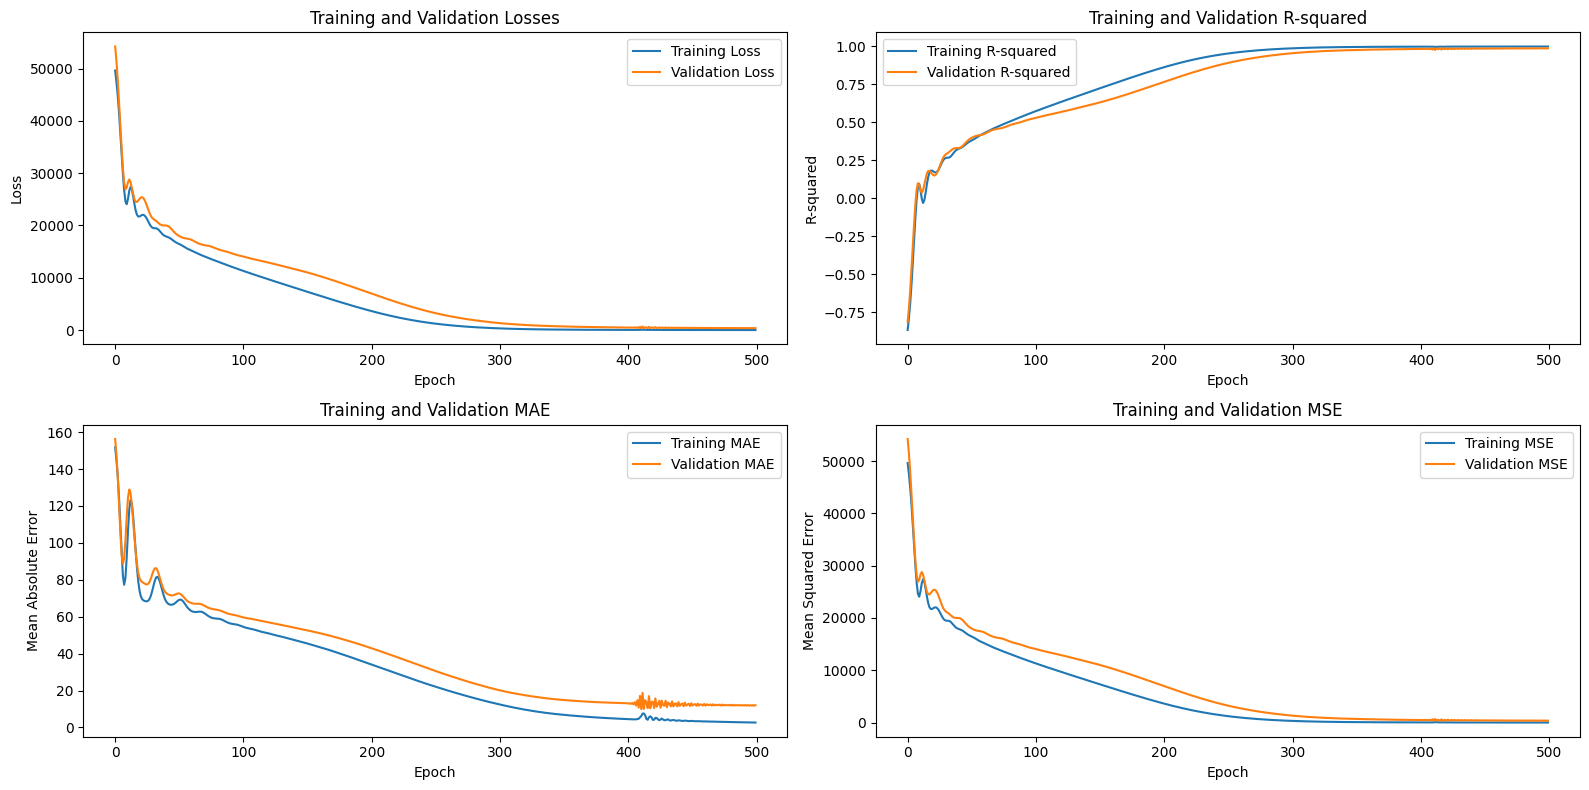

Test Loss: 5129.9609375, Test R-squared: 0.8983026137042761, Test MAE: 33.98234939575195, Test MSE: 5129.9609375


In [9]:
from google.colab import drive
import os
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_no_lstm.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_no_lstm.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_no_lstm.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Position encoding
def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

# PEGNN model definition
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 5, 30)  # Hyperparameter for k-nearest neighbors

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
    pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
    pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

    x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, out_channels=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    y_train_t = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
    y_val_t = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val_t)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], out_channels=1)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    model.train()

# Save the final model
save_model(model, model_path)

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')


PE-GNN model
Hier kan het model terug ingeladen worden indien er een versie is opgeslagen.

In [8]:
from google.colab import drive
import os
import torch
import joblib
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
model_filename = 'pegnn_model_reduced_features.pth'  # Custom filename used previously
model_path = os.path.join(drive_path, model_filename)
study_path = os.path.join(drive_path, 'optuna_study_pegnn_reduced_features.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_reduced_features.pkl')

# Function to load the model
def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to load input feature size
def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Reload the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_params = loaded_study.best_params
print("Best parameters: ", best_params)

# Reload the input feature size
input_feature_size = load_input_feature_size(input_size_path)

# Define the PEGNN model class
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Assuming train_coords_pegnn, val_coords_pegnn, test_coords_pegnn, train_features_pegnn, val_features_pegnn, and test_features_pegnn are defined
d_model = 128

def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)
y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

# Load the model with the best hyperparameters
loaded_model = load_model(PEGNN, model_path, input_feature_size, best_params['hidden_channels'], 1)

# Set the model to evaluation mode
loaded_model.eval()

# Create the optimizer and loss function
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

# Train the model and compute metrics
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

loaded_model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = loaded_model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    loaded_model.eval()
    with torch.no_grad():
        out_val = loaded_model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    loaded_model.train()

# Save the final model
# save_model(loaded_model, model_path)  # Uncomment if you want to save the model again

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

loaded_model.eval()
with torch.no_grad():
    out_test = loaded_model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')



Best parameters:  {'hidden_channels': 123, 'lr': 0.00992691227826793, 'k': 30}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6000x242 and 243x123)